In [1]:
##### import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from skimage.feature import hog
from sklearn.utils import shuffle

import pandas as pd  
from keras.models import Sequential
from keras.models import Model
from keras.layers import ELU
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Lambda
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2
from keras.models import model_from_json

from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
import simplejson as json
import random

/home/sayem/Softwares/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imgRow = 630
imgCol = 960

In [3]:
def showGrayImage(img):
    imgShow = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
    imgShow[:,:,2] = imgShow[:,:,0]*255
    imgShow[:,:,0:2] = 0    
    
    plt.imshow(imgShow)            
    plt.show()
def CropImage(image):
    #Crops the iamge so that the hood of the car and top of the image
    #which contains sky trees and other stuffs are removed.
    #height = len(image)
    #return image[int(height * 2/5.):int(height * 6/7.0), :, :]
    return cv2.resize(image,(512,512))

In [4]:
rootDir = "object-detection-crowdai/"
csvFile = pd.read_csv(rootDir+'labels.csv', header=0)

dataFile = csvFile[(csvFile['Label']!='Pedestrian')].reset_index()
dataFile = dataFile.drop('index', 1)
dataFile = dataFile.drop('Preview URL', 1)
dataFile['Frame'] = './' + rootDir + dataFile['Frame']
dataFile.columns = ['xmin', 'ymin', 'xmax','ymax', 'Frame', 'Label']


In [5]:
names = ['Frame',  'xmin', 'ymin', 'xmax','ymax', 'occluded', 'Label']
rootDir = "object-dataset/"
csvFile1 = pd.read_csv(rootDir+'labels.csv', delim_whitespace=True, names=names)
dataFile1 = csvFile1[(csvFile1['Label']!=str.lower('Pedestrian'))].reset_index()
dataFile1 = dataFile1.drop('index',1)
dataFile1 = dataFile1.drop('occluded',1)
dataFile1['Frame'] = './' + rootDir + dataFile1['Frame']
dataFile1.tail(10)

,Frame,xmin,ymin,xmax,ymax,Label
83210,./object-dataset/1478901535817639152.jpg,162,598,404,754,car
83211,./object-dataset/1478901535817639152.jpg,400,592,506,714,car
83212,./object-dataset/1478901535817639152.jpg,1118,556,1346,740,car
83213,./object-dataset/1478901536388465963.jpg,234,594,388,728,car
83214,./object-dataset/1478901536388465963.jpg,364,604,430,678,car
83215,./object-dataset/1478901536388465963.jpg,1048,552,1348,748,car
83216,./object-dataset/1478901536960505700.jpg,0,606,142,780,car
83217,./object-dataset/1478901536960505700.jpg,146,604,246,692,car
83218,./object-dataset/1478901536960505700.jpg,710,582,800,618,car
83219,./object-dataset/1478901536960505700.jpg,896,546,1228,790,car


In [6]:
dataFile.tail()

,xmin,ymin,xmax,ymax,Frame,Label
66384,958,559,1045,621,./object-detection-crowdai/1479506176491553178...,Car
66385,1038,558,1122,630,./object-detection-crowdai/1479506176491553178...,Car
66386,667,558,747,626,./object-detection-crowdai/1479506176491553178...,Car
66387,730,568,818,613,./object-detection-crowdai/1479506176491553178...,Car
66388,435,551,532,589,./object-detection-crowdai/1479506176491553178...,Car


In [7]:
from keras.models import model_from_json

with open('model.json', 'r') as jfile:
    model = model_from_json(json.loads(jfile.read())) 
    print('model loaded')

#model.compile(optimizer=Adam(lr=1e-4), loss="mse", metrics=['accuracy'])
weights_file = './weights/weights.04--0.9208.h5'
model.load_weights(weights_file)

model loaded


In [ ]:
train_samples_per_epoch = 2560
valid_samples_per_epoch = 16384
trainBatchSize = 16
validationBatchSize = 64

def TrainDataGenerator(dataInfoList,batchSize,rootDir):
    batch_x, batch_y = [], []
    while True:
        dataInfo = dataInfoList[random.randint(0,1)]
        row = np.random.randint(len(dataInfo))
        fileName = dataInfo['Frame'][row]
        print(fileName, row)
        img = cv2.imread(fileName)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        origShape = img.shape
        img = cv2.resize(img, (imgCol, imgRow))
        
        data = dataInfo[dataInfo['Frame'][row] == dataInfo['Frame']].reset_index()
        data['xmin'] = np.round(data['xmin'] / origShape[1] * imgCol)
        data['xmax'] = np.round(data['xmax'] / origShape[1] * imgCol)
        data['ymin'] = np.round(data['ymin'] / origShape[0] * imgRow)
        data['ymax'] = np.round(data['ymax'] / origShape[0] * imgRow)
        
        targetImg = np.zeros_like(img[:, :, 2])
        for i in range(len(data)):
            targetImg[data.iloc[i]['ymin']:data.iloc[i]['ymax'], data.iloc[i]['xmin']:data.iloc[i]['xmax']] = 1

        targetImg = np.reshape(targetImg, (imgRow, imgCol, 1))        
        targetImg = CropImage(targetImg)
        img = CropImage(img)
        
        
        xy_array = np.asarray(img)
        xy_array = np.reshape(xy_array,(1,img.shape[0],img.shape[1],3))
        
        img = model.predict(xy_array)
        mask_array  = np.reshape(targetImg,(1,targetImg.shape[0],targetImg.shape[1],1))
        
          
        im = np.array(xy_array[0],dtype=np.uint8)
        im_mask = np.array(255*mask_array[0],dtype=np.uint8)
        im_pred = np.array(255*img[0],dtype=np.uint8)

        rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
        rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
        rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
        rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
        rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]

        img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
        img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)

        plt.figure(figsize=(22,16))
        plt.subplot(1,3,1)
        plt.imshow(im)
        plt.title('Original image')
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(img_pred)
        plt.title('Predicted segmentation mask')
        plt.axis('off')
        plt.subplot(1,3,3)        
        plt.imshow(img_true)
        plt.title('Ground truth')
        plt.axis('off')
        plt.show()
        
        break
    
trainGenerator = TrainDataGenerator((dataFile,dataFile1),trainBatchSize,rootDir)

In [8]:
def process_frame(img):
    img = cv2.resize(img,(imgCol,imgRow))    
    resizedImage = img.copy()
    img = CropImage(img)
    x_array = np.asarray(img)
    x_array = np.reshape(x_array,(1,img.shape[0],img.shape[1],3))
    
    img = model.predict(x_array,verbose=1)
    
    im = np.array(x_array[0],dtype=np.uint8)
    #img[0] = np.round(img[0])
    #print(set(img.flatten()))
    predImg = np.array(255*img[0],dtype=np.uint8)
    #return predImg
    rgb_mask_pred = cv2.cvtColor(predImg,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    #return rgb_mask_pred
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_pred = cv2.resize(img_pred,(1280,720))
    return img_pred

In [10]:
clip = VideoFileClip('./6.mp4')
outClip = clip.fl_image(process_frame)
%time outClip.write_videofile('./output6_weights.04--0.9208.mp4', audio=False)

1/1 [==============================] - 0s 447ms/step
[MoviePy] >>>> Building video ./output6_weights.04--0.9208.mp4
[MoviePy] Writing video ./output6_weights.04--0.9208.mp4


  0%|          | 0/2649 [00:00<?, ?it/s]

1/1 [==============================] - 0s 463ms/step


  0%|          | 1/2649 [00:00<21:25,  2.06it/s]

1/1 [==============================] - 0s 488ms/step


  0%|          | 2/2649 [00:01<22:09,  1.99it/s]

1/1 [==============================] - 0s 457ms/step


  0%|          | 3/2649 [00:01<22:02,  2.00it/s]

1/1 [==============================] - 0s 463ms/step


  0%|          | 4/2649 [00:01<21:59,  2.01it/s]

1/1 [==============================] - 0s 455ms/step


  0%|          | 5/2649 [00:02<21:50,  2.02it/s]

1/1 [==============================] - 0s 466ms/step


  0%|          | 6/2649 [00:02<21:52,  2.01it/s]

1/1 [==============================] - 0s 488ms/step


  0%|          | 7/2649 [00:03<22:00,  2.00it/s]

1/1 [==============================] - 0s 463ms/step


  0%|          | 8/2649 [00:03<21:56,  2.01it/s]

1/1 [==============================] - 0s 453ms/step


  0%|          | 9/2649 [00:04<21:51,  2.01it/s]

1/1 [==============================] - 0s 445ms/step


  0%|          | 10/2649 [00:04<21:45,  2.02it/s]

1/1 [==============================] - 0s 456ms/step


  0%|          | 11/2649 [00:05<21:41,  2.03it/s]

1/1 [==============================] - 0s 449ms/step


  0%|          | 12/2649 [00:05<21:38,  2.03it/s]

1/1 [==============================] - 0s 444ms/step


  0%|          | 13/2649 [00:06<21:33,  2.04it/s]

1/1 [==============================] - 0s 445ms/step


  1%|          | 14/2649 [00:06<21:29,  2.04it/s]

1/1 [==============================] - 0s 462ms/step


  1%|          | 15/2649 [00:07<21:30,  2.04it/s]

1/1 [==============================] - 1s 535ms/step


  1%|          | 16/2649 [00:07<21:42,  2.02it/s]

1/1 [==============================] - 1s 635ms/step


  1%|          | 17/2649 [00:08<22:12,  1.98it/s]

1/1 [==============================] - 1s 909ms/step


  1%|          | 18/2649 [00:09<23:16,  1.88it/s]

1/1 [==============================] - 1s 744ms/step


  1%|          | 19/2649 [00:10<23:52,  1.84it/s]

1/1 [==============================] - 1s 725ms/step


  1%|          | 20/2649 [00:11<24:24,  1.80it/s]

1/1 [==============================] - 1s 699ms/step


  1%|          | 21/2649 [00:11<24:46,  1.77it/s]

1/1 [==============================] - 1s 705ms/step


  1%|          | 22/2649 [00:12<25:07,  1.74it/s]

1/1 [==============================] - 1s 720ms/step


  1%|          | 23/2649 [00:13<25:29,  1.72it/s]

1/1 [==============================] - 1s 711ms/step


  1%|          | 24/2649 [00:14<25:48,  1.70it/s]

1/1 [==============================] - 1s 758ms/step


  1%|          | 25/2649 [00:14<26:10,  1.67it/s]

1/1 [==============================] - 1s 735ms/step


  1%|          | 26/2649 [00:15<26:29,  1.65it/s]

1/1 [==============================] - 1s 768ms/step


  1%|          | 27/2649 [00:16<26:48,  1.63it/s]

1/1 [==============================] - 1s 730ms/step


  1%|          | 28/2649 [00:17<27:04,  1.61it/s]

1/1 [==============================] - 1s 759ms/step


  1%|          | 29/2649 [00:18<27:20,  1.60it/s]

1/1 [==============================] - 1s 756ms/step


  1%|          | 30/2649 [00:18<27:35,  1.58it/s]

1/1 [==============================] - 1s 843ms/step


  1%|          | 31/2649 [00:19<27:57,  1.56it/s]

1/1 [==============================] - 1s 761ms/step


  1%|          | 32/2649 [00:20<28:10,  1.55it/s]

1/1 [==============================] - 1s 742ms/step


  1%|          | 33/2649 [00:21<28:21,  1.54it/s]

1/1 [==============================] - 1s 730ms/step


  1%|▏         | 34/2649 [00:22<28:29,  1.53it/s]

1/1 [==============================] - 1s 756ms/step


  1%|▏         | 35/2649 [00:23<28:41,  1.52it/s]

1/1 [==============================] - 1s 764ms/step


  1%|▏         | 36/2649 [00:23<28:51,  1.51it/s]

1/1 [==============================] - 1s 751ms/step


  1%|▏         | 37/2649 [00:24<28:59,  1.50it/s]

1/1 [==============================] - 1s 745ms/step


  1%|▏         | 38/2649 [00:25<29:08,  1.49it/s]

1/1 [==============================] - 1s 767ms/step


  1%|▏         | 39/2649 [00:26<29:17,  1.48it/s]

1/1 [==============================] - 1s 758ms/step


  2%|▏         | 40/2649 [00:27<29:26,  1.48it/s]

1/1 [==============================] - 1s 741ms/step


  2%|▏         | 41/2649 [00:27<29:33,  1.47it/s]

1/1 [==============================] - 1s 736ms/step


  2%|▏         | 42/2649 [00:28<29:39,  1.46it/s]

1/1 [==============================] - 1s 620ms/step


  2%|▏         | 43/2649 [00:29<29:38,  1.47it/s]

1/1 [==============================] - 1s 567ms/step


  2%|▏         | 44/2649 [00:29<29:34,  1.47it/s]

1/1 [==============================] - 1s 569ms/step


  2%|▏         | 45/2649 [00:30<29:28,  1.47it/s]

1/1 [==============================] - 1s 555ms/step


  2%|▏         | 46/2649 [00:31<29:23,  1.48it/s]

1/1 [==============================] - 1s 634ms/step


  2%|▏         | 47/2649 [00:31<29:21,  1.48it/s]

1/1 [==============================] - 1s 578ms/step


  2%|▏         | 48/2649 [00:32<29:17,  1.48it/s]

1/1 [==============================] - 1s 572ms/step


  2%|▏         | 49/2649 [00:33<29:14,  1.48it/s]

1/1 [==============================] - 1s 567ms/step


  2%|▏         | 50/2649 [00:33<29:09,  1.49it/s]

1/1 [==============================] - 1s 585ms/step


  2%|▏         | 51/2649 [00:34<29:06,  1.49it/s]

1/1 [==============================] - 1s 577ms/step


  2%|▏         | 52/2649 [00:34<29:02,  1.49it/s]

1/1 [==============================] - 1s 573ms/step


  2%|▏         | 53/2649 [00:35<28:58,  1.49it/s]

1/1 [==============================] - 1s 567ms/step


  2%|▏         | 54/2649 [00:36<28:54,  1.50it/s]

1/1 [==============================] - 1s 579ms/step


  2%|▏         | 55/2649 [00:36<28:51,  1.50it/s]

1/1 [==============================] - 1s 574ms/step


  2%|▏         | 56/2649 [00:37<28:48,  1.50it/s]

1/1 [==============================] - 1s 571ms/step


  2%|▏         | 57/2649 [00:37<28:45,  1.50it/s]

1/1 [==============================] - 1s 573ms/step


  2%|▏         | 58/2649 [00:38<28:42,  1.50it/s]

1/1 [==============================] - 1s 560ms/step


  2%|▏         | 59/2649 [00:39<28:39,  1.51it/s]

1/1 [==============================] - 1s 580ms/step


  2%|▏         | 60/2649 [00:39<28:36,  1.51it/s]

1/1 [==============================] - 1s 586ms/step


  2%|▏         | 61/2649 [00:40<28:34,  1.51it/s]

1/1 [==============================] - 0s 456ms/step


  2%|▏         | 62/2649 [00:40<28:26,  1.52it/s]

1/1 [==============================] - 0s 478ms/step


  2%|▏         | 63/2649 [00:41<28:19,  1.52it/s]

1/1 [==============================] - 0s 452ms/step


  2%|▏         | 64/2649 [00:41<28:12,  1.53it/s]

1/1 [==============================] - 0s 459ms/step


  2%|▏         | 65/2649 [00:42<28:04,  1.53it/s]

1/1 [==============================] - 0s 490ms/step


  2%|▏         | 66/2649 [00:42<27:59,  1.54it/s]

1/1 [==============================] - 0s 470ms/step


  3%|▎         | 67/2649 [00:43<27:52,  1.54it/s]

1/1 [==============================] - 0s 464ms/step


  3%|▎         | 68/2649 [00:43<27:47,  1.55it/s]

1/1 [==============================] - 0s 456ms/step


  3%|▎         | 69/2649 [00:44<27:40,  1.55it/s]

1/1 [==============================] - 0s 459ms/step


  3%|▎         | 70/2649 [00:44<27:34,  1.56it/s]

1/1 [==============================] - 0s 467ms/step


  3%|▎         | 71/2649 [00:45<27:28,  1.56it/s]

1/1 [==============================] - 0s 460ms/step


  3%|▎         | 72/2649 [00:45<27:22,  1.57it/s]

1/1 [==============================] - 0s 442ms/step


  3%|▎         | 73/2649 [00:46<27:15,  1.57it/s]

1/1 [==============================] - 0s 460ms/step


  3%|▎         | 74/2649 [00:46<27:10,  1.58it/s]

1/1 [==============================] - 0s 477ms/step


  3%|▎         | 75/2649 [00:47<27:05,  1.58it/s]

1/1 [==============================] - 0s 490ms/step


  3%|▎         | 76/2649 [00:47<27:01,  1.59it/s]

1/1 [==============================] - 0s 492ms/step


  3%|▎         | 77/2649 [00:48<26:57,  1.59it/s]

1/1 [==============================] - 0s 471ms/step


  3%|▎         | 78/2649 [00:48<26:52,  1.59it/s]

1/1 [==============================] - 1s 523ms/step


  3%|▎         | 79/2649 [00:49<26:49,  1.60it/s]

1/1 [==============================] - 1s 547ms/step


  3%|▎         | 80/2649 [00:50<26:47,  1.60it/s]

1/1 [==============================] - 0s 462ms/step


  3%|▎         | 81/2649 [00:50<26:42,  1.60it/s]

1/1 [==============================] - 0s 443ms/step


  3%|▎         | 82/2649 [00:50<26:36,  1.61it/s]

1/1 [==============================] - 0s 451ms/step


  3%|▎         | 83/2649 [00:51<26:31,  1.61it/s]

1/1 [==============================] - 0s 448ms/step


  3%|▎         | 84/2649 [00:51<26:26,  1.62it/s]

1/1 [==============================] - 0s 442ms/step


  3%|▎         | 85/2649 [00:52<26:21,  1.62it/s]

1/1 [==============================] - 0s 449ms/step


  3%|▎         | 86/2649 [00:52<26:16,  1.63it/s]

1/1 [==============================] - 0s 452ms/step


  3%|▎         | 87/2649 [00:53<26:11,  1.63it/s]

1/1 [==============================] - 0s 453ms/step


  3%|▎         | 88/2649 [00:53<26:06,  1.63it/s]

1/1 [==============================] - 0s 445ms/step


  3%|▎         | 89/2649 [00:54<26:02,  1.64it/s]

1/1 [==============================] - 0s 447ms/step


  3%|▎         | 90/2649 [00:54<25:57,  1.64it/s]

1/1 [==============================] - 0s 447ms/step


  3%|▎         | 91/2649 [00:55<25:52,  1.65it/s]

1/1 [==============================] - 0s 452ms/step


  3%|▎         | 92/2649 [00:55<25:48,  1.65it/s]

1/1 [==============================] - 0s 448ms/step


  4%|▎         | 93/2649 [00:56<25:44,  1.66it/s]

1/1 [==============================] - 0s 445ms/step


  4%|▎         | 94/2649 [00:56<25:39,  1.66it/s]

1/1 [==============================] - 0s 449ms/step


  4%|▎         | 95/2649 [00:57<25:35,  1.66it/s]

1/1 [==============================] - 0s 451ms/step


  4%|▎         | 96/2649 [00:57<25:31,  1.67it/s]

1/1 [==============================] - 0s 446ms/step


  4%|▎         | 97/2649 [00:58<25:27,  1.67it/s]

1/1 [==============================] - 0s 450ms/step


  4%|▎         | 98/2649 [00:58<25:23,  1.67it/s]

1/1 [==============================] - 0s 446ms/step


  4%|▎         | 99/2649 [00:59<25:20,  1.68it/s]

1/1 [==============================] - 0s 447ms/step


  4%|▍         | 100/2649 [00:59<25:16,  1.68it/s]

1/1 [==============================] - 0s 449ms/step


  4%|▍         | 101/2649 [00:59<25:12,  1.68it/s]

1/1 [==============================] - 0s 445ms/step


  4%|▍         | 102/2649 [01:00<25:08,  1.69it/s]

1/1 [==============================] - 0s 443ms/step


  4%|▍         | 103/2649 [01:00<25:05,  1.69it/s]

1/1 [==============================] - 0s 448ms/step


  4%|▍         | 104/2649 [01:01<25:01,  1.69it/s]

1/1 [==============================] - 0s 446ms/step


  4%|▍         | 105/2649 [01:01<24:58,  1.70it/s]

1/1 [==============================] - 0s 444ms/step


  4%|▍         | 106/2649 [01:02<24:54,  1.70it/s]

1/1 [==============================] - 0s 446ms/step


  4%|▍         | 107/2649 [01:02<24:51,  1.70it/s]

1/1 [==============================] - 0s 486ms/step


  4%|▍         | 108/2649 [01:03<24:48,  1.71it/s]

1/1 [==============================] - 1s 561ms/step


  4%|▍         | 109/2649 [01:03<24:48,  1.71it/s]

1/1 [==============================] - 1s 555ms/step


  4%|▍         | 110/2649 [01:04<24:47,  1.71it/s]

1/1 [==============================] - 0s 447ms/step


  4%|▍         | 111/2649 [01:04<24:44,  1.71it/s]

1/1 [==============================] - 0s 473ms/step


  4%|▍         | 112/2649 [01:05<24:42,  1.71it/s]

1/1 [==============================] - 0s 463ms/step


  4%|▍         | 113/2649 [01:05<24:39,  1.71it/s]

1/1 [==============================] - 1s 570ms/step


  4%|▍         | 114/2649 [01:06<24:39,  1.71it/s]

1/1 [==============================] - 0s 472ms/step


  4%|▍         | 115/2649 [01:07<24:36,  1.72it/s]

1/1 [==============================] - 1s 558ms/step


  4%|▍         | 116/2649 [01:07<24:36,  1.72it/s]

1/1 [==============================] - 0s 463ms/step


  4%|▍         | 117/2649 [01:08<24:33,  1.72it/s]

1/1 [==============================] - 0s 489ms/step


  4%|▍         | 118/2649 [01:08<24:31,  1.72it/s]

1/1 [==============================] - 0s 448ms/step


  4%|▍         | 119/2649 [01:09<24:28,  1.72it/s]

1/1 [==============================] - 0s 495ms/step


  5%|▍         | 120/2649 [01:09<24:26,  1.72it/s]

1/1 [==============================] - 0s 459ms/step


  5%|▍         | 121/2649 [01:10<24:24,  1.73it/s]

1/1 [==============================] - 0s 447ms/step


  5%|▍         | 122/2649 [01:10<24:21,  1.73it/s]

1/1 [==============================] - 1s 590ms/step


  5%|▍         | 123/2649 [01:11<24:21,  1.73it/s]

1/1 [==============================] - 1s 519ms/step


  5%|▍         | 124/2649 [01:11<24:20,  1.73it/s]

1/1 [==============================] - 1s 621ms/step


  5%|▍         | 125/2649 [01:12<24:21,  1.73it/s]

1/1 [==============================] - 1s 774ms/step


  5%|▍         | 126/2649 [01:13<24:25,  1.72it/s]

1/1 [==============================] - 1s 828ms/step


  5%|▍         | 127/2649 [01:14<24:32,  1.71it/s]

1/1 [==============================] - 1s 857ms/step


  5%|▍         | 128/2649 [01:15<24:37,  1.71it/s]

1/1 [==============================] - 1s 614ms/step


  5%|▍         | 129/2649 [01:15<24:38,  1.70it/s]

1/1 [==============================] - 1s 618ms/step


  5%|▍         | 130/2649 [01:16<24:39,  1.70it/s]

1/1 [==============================] - 1s 524ms/step


  5%|▍         | 131/2649 [01:16<24:38,  1.70it/s]

1/1 [==============================] - 1s 516ms/step


  5%|▍         | 132/2649 [01:17<24:36,  1.70it/s]

1/1 [==============================] - 1s 525ms/step


  5%|▌         | 133/2649 [01:18<24:35,  1.71it/s]

1/1 [==============================] - 1s 522ms/step


  5%|▌         | 134/2649 [01:18<24:34,  1.71it/s]

1/1 [==============================] - 1s 520ms/step


  5%|▌         | 135/2649 [01:19<24:33,  1.71it/s]

1/1 [==============================] - 0s 495ms/step


  5%|▌         | 136/2649 [01:19<24:31,  1.71it/s]

1/1 [==============================] - 0s 453ms/step


  5%|▌         | 137/2649 [01:20<24:28,  1.71it/s]

1/1 [==============================] - 0s 450ms/step


  5%|▌         | 138/2649 [01:20<24:26,  1.71it/s]

1/1 [==============================] - 0s 450ms/step


  5%|▌         | 139/2649 [01:21<24:23,  1.72it/s]

1/1 [==============================] - 0s 463ms/step


  5%|▌         | 140/2649 [01:21<24:21,  1.72it/s]

1/1 [==============================] - 0s 489ms/step


  5%|▌         | 141/2649 [01:22<24:19,  1.72it/s]

1/1 [==============================] - 1s 534ms/step


  5%|▌         | 142/2649 [01:22<24:18,  1.72it/s]

1/1 [==============================] - 0s 463ms/step


  5%|▌         | 143/2649 [01:23<24:16,  1.72it/s]

1/1 [==============================] - 0s 456ms/step


  5%|▌         | 144/2649 [01:23<24:14,  1.72it/s]

1/1 [==============================] - 0s 491ms/step


  5%|▌         | 145/2649 [01:24<24:12,  1.72it/s]

1/1 [==============================] - 0s 485ms/step


  6%|▌         | 146/2649 [01:24<24:10,  1.73it/s]

1/1 [==============================] - 0s 451ms/step


  6%|▌         | 147/2649 [01:25<24:08,  1.73it/s]

1/1 [==============================] - 0s 460ms/step


  6%|▌         | 148/2649 [01:25<24:06,  1.73it/s]

1/1 [==============================] - 0s 466ms/step


  6%|▌         | 149/2649 [01:26<24:03,  1.73it/s]

1/1 [==============================] - 0s 459ms/step


  6%|▌         | 150/2649 [01:26<24:01,  1.73it/s]

1/1 [==============================] - 0s 455ms/step


  6%|▌         | 151/2649 [01:27<23:59,  1.74it/s]

1/1 [==============================] - 0s 491ms/step


  6%|▌         | 152/2649 [01:27<23:58,  1.74it/s]

1/1 [==============================] - 0s 491ms/step


  6%|▌         | 153/2649 [01:28<23:56,  1.74it/s]

1/1 [==============================] - 1s 501ms/step


  6%|▌         | 154/2649 [01:28<23:55,  1.74it/s]

1/1 [==============================] - 0s 470ms/step


  6%|▌         | 155/2649 [01:29<23:53,  1.74it/s]

1/1 [==============================] - 0s 465ms/step


  6%|▌         | 156/2649 [01:29<23:51,  1.74it/s]

1/1 [==============================] - 0s 451ms/step


  6%|▌         | 157/2649 [01:30<23:49,  1.74it/s]

1/1 [==============================] - 0s 490ms/step


  6%|▌         | 158/2649 [01:30<23:47,  1.74it/s]

1/1 [==============================] - 0s 452ms/step


  6%|▌         | 159/2649 [01:31<23:45,  1.75it/s]

1/1 [==============================] - 0s 454ms/step


  6%|▌         | 160/2649 [01:31<23:43,  1.75it/s]

1/1 [==============================] - 0s 453ms/step


  6%|▌         | 161/2649 [01:31<23:41,  1.75it/s]

1/1 [==============================] - 0s 450ms/step


  6%|▌         | 162/2649 [01:32<23:39,  1.75it/s]

1/1 [==============================] - 0s 447ms/step


  6%|▌         | 163/2649 [01:32<23:37,  1.75it/s]

1/1 [==============================] - 0s 460ms/step


  6%|▌         | 164/2649 [01:33<23:35,  1.76it/s]

1/1 [==============================] - 0s 445ms/step


  6%|▌         | 165/2649 [01:33<23:33,  1.76it/s]

1/1 [==============================] - 0s 444ms/step


  6%|▋         | 166/2649 [01:34<23:31,  1.76it/s]

1/1 [==============================] - 0s 443ms/step


  6%|▋         | 167/2649 [01:34<23:29,  1.76it/s]

1/1 [==============================] - 0s 447ms/step


  6%|▋         | 168/2649 [01:35<23:27,  1.76it/s]

1/1 [==============================] - 0s 437ms/step


  6%|▋         | 169/2649 [01:35<23:25,  1.76it/s]

1/1 [==============================] - 0s 437ms/step


  6%|▋         | 170/2649 [01:36<23:23,  1.77it/s]

1/1 [==============================] - 0s 440ms/step


  6%|▋         | 171/2649 [01:36<23:21,  1.77it/s]

1/1 [==============================] - 0s 452ms/step


  6%|▋         | 172/2649 [01:37<23:19,  1.77it/s]

1/1 [==============================] - 0s 439ms/step


  7%|▋         | 173/2649 [01:37<23:17,  1.77it/s]

1/1 [==============================] - 0s 445ms/step


  7%|▋         | 174/2649 [01:38<23:15,  1.77it/s]

1/1 [==============================] - 0s 486ms/step


  7%|▋         | 175/2649 [01:38<23:13,  1.77it/s]

1/1 [==============================] - 0s 475ms/step


  7%|▋         | 176/2649 [01:39<23:12,  1.78it/s]

1/1 [==============================] - 0s 446ms/step


  7%|▋         | 177/2649 [01:39<23:10,  1.78it/s]

1/1 [==============================] - 0s 442ms/step


  7%|▋         | 178/2649 [01:40<23:08,  1.78it/s]

1/1 [==============================] - 0s 439ms/step


  7%|▋         | 179/2649 [01:40<23:06,  1.78it/s]

1/1 [==============================] - 0s 444ms/step


  7%|▋         | 180/2649 [01:40<23:04,  1.78it/s]

1/1 [==============================] - 0s 438ms/step


  7%|▋         | 181/2649 [01:41<23:03,  1.78it/s]

1/1 [==============================] - 0s 437ms/step


  7%|▋         | 182/2649 [01:41<23:01,  1.79it/s]

1/1 [==============================] - 0s 435ms/step


  7%|▋         | 183/2649 [01:42<22:59,  1.79it/s]

1/1 [==============================] - 0s 445ms/step


  7%|▋         | 184/2649 [01:42<22:57,  1.79it/s]

1/1 [==============================] - 0s 440ms/step


  7%|▋         | 185/2649 [01:43<22:55,  1.79it/s]

1/1 [==============================] - 0s 439ms/step


  7%|▋         | 186/2649 [01:43<22:53,  1.79it/s]

1/1 [==============================] - 0s 440ms/step


  7%|▋         | 187/2649 [01:44<22:52,  1.79it/s]

1/1 [==============================] - 0s 439ms/step


  7%|▋         | 188/2649 [01:44<22:50,  1.80it/s]

1/1 [==============================] - 0s 442ms/step


  7%|▋         | 189/2649 [01:45<22:48,  1.80it/s]

1/1 [==============================] - 0s 445ms/step


  7%|▋         | 190/2649 [01:45<22:46,  1.80it/s]

1/1 [==============================] - 0s 444ms/step


  7%|▋         | 191/2649 [01:46<22:45,  1.80it/s]

1/1 [==============================] - 0s 446ms/step


  7%|▋         | 192/2649 [01:46<22:43,  1.80it/s]

1/1 [==============================] - 0s 447ms/step


  7%|▋         | 193/2649 [01:47<22:41,  1.80it/s]

1/1 [==============================] - 0s 438ms/step


  7%|▋         | 194/2649 [01:47<22:40,  1.80it/s]

1/1 [==============================] - 0s 439ms/step


  7%|▋         | 195/2649 [01:47<22:38,  1.81it/s]

1/1 [==============================] - 0s 439ms/step


  7%|▋         | 196/2649 [01:48<22:36,  1.81it/s]

1/1 [==============================] - 0s 446ms/step


  7%|▋         | 197/2649 [01:48<22:35,  1.81it/s]

1/1 [==============================] - 0s 447ms/step


  7%|▋         | 198/2649 [01:49<22:33,  1.81it/s]

1/1 [==============================] - 0s 454ms/step


  8%|▊         | 199/2649 [01:49<22:32,  1.81it/s]

1/1 [==============================] - 0s 437ms/step


  8%|▊         | 200/2649 [01:50<22:30,  1.81it/s]

1/1 [==============================] - 0s 442ms/step


  8%|▊         | 201/2649 [01:50<22:28,  1.81it/s]

1/1 [==============================] - 0s 446ms/step


  8%|▊         | 202/2649 [01:51<22:27,  1.82it/s]

1/1 [==============================] - 0s 443ms/step


  8%|▊         | 203/2649 [01:51<22:25,  1.82it/s]

1/1 [==============================] - 1s 503ms/step


  8%|▊         | 204/2649 [01:52<22:24,  1.82it/s]

1/1 [==============================] - 0s 491ms/step


  8%|▊         | 205/2649 [01:52<22:23,  1.82it/s]

1/1 [==============================] - 0s 444ms/step


  8%|▊         | 206/2649 [01:53<22:22,  1.82it/s]

1/1 [==============================] - 0s 440ms/step


  8%|▊         | 207/2649 [01:53<22:20,  1.82it/s]

1/1 [==============================] - 0s 440ms/step


  8%|▊         | 208/2649 [01:54<22:19,  1.82it/s]

1/1 [==============================] - 0s 461ms/step


  8%|▊         | 209/2649 [01:54<22:18,  1.82it/s]

1/1 [==============================] - 1s 510ms/step


  8%|▊         | 210/2649 [01:55<22:17,  1.82it/s]

1/1 [==============================] - 0s 443ms/step


  8%|▊         | 211/2649 [01:55<22:16,  1.82it/s]

1/1 [==============================] - 0s 464ms/step


  8%|▊         | 212/2649 [01:56<22:14,  1.83it/s]

1/1 [==============================] - 1s 504ms/step


  8%|▊         | 213/2649 [01:56<22:14,  1.83it/s]

1/1 [==============================] - 1s 542ms/step


  8%|▊         | 214/2649 [01:57<22:13,  1.83it/s]

1/1 [==============================] - 0s 489ms/step


  8%|▊         | 215/2649 [01:57<22:12,  1.83it/s]

1/1 [==============================] - 1s 565ms/step


  8%|▊         | 216/2649 [01:58<22:13,  1.83it/s]

1/1 [==============================] - 1s 792ms/step


  8%|▊         | 217/2649 [01:59<22:15,  1.82it/s]

1/1 [==============================] - 1s 651ms/step


  8%|▊         | 218/2649 [01:59<22:16,  1.82it/s]

1/1 [==============================] - 1s 598ms/step


  8%|▊         | 219/2649 [02:00<22:17,  1.82it/s]

1/1 [==============================] - 1s 584ms/step


  8%|▊         | 220/2649 [02:01<22:17,  1.82it/s]

1/1 [==============================] - 1s 632ms/step


  8%|▊         | 221/2649 [02:01<22:17,  1.81it/s]

1/1 [==============================] - 1s 633ms/step


  8%|▊         | 222/2649 [02:02<22:18,  1.81it/s]

1/1 [==============================] - 1s 627ms/step


  8%|▊         | 223/2649 [02:03<22:19,  1.81it/s]

1/1 [==============================] - 1s 654ms/step


  8%|▊         | 224/2649 [02:03<22:20,  1.81it/s]

1/1 [==============================] - 1s 551ms/step


  8%|▊         | 225/2649 [02:04<22:20,  1.81it/s]

1/1 [==============================] - 1s 527ms/step


  9%|▊         | 226/2649 [02:04<22:19,  1.81it/s]

1/1 [==============================] - 1s 523ms/step


  9%|▊         | 227/2649 [02:05<22:19,  1.81it/s]

1/1 [==============================] - 1s 539ms/step


  9%|▊         | 228/2649 [02:06<22:18,  1.81it/s]

1/1 [==============================] - 1s 565ms/step


  9%|▊         | 229/2649 [02:06<22:18,  1.81it/s]

1/1 [==============================] - 1s 543ms/step


  9%|▊         | 230/2649 [02:07<22:18,  1.81it/s]

1/1 [==============================] - 1s 552ms/step


  9%|▊         | 231/2649 [02:07<22:17,  1.81it/s]

1/1 [==============================] - 1s 564ms/step


  9%|▉         | 232/2649 [02:08<22:17,  1.81it/s]

1/1 [==============================] - 1s 606ms/step


  9%|▉         | 233/2649 [02:09<22:17,  1.81it/s]

1/1 [==============================] - 1s 574ms/step


  9%|▉         | 234/2649 [02:09<22:17,  1.81it/s]

1/1 [==============================] - 1s 574ms/step


  9%|▉         | 235/2649 [02:10<22:17,  1.80it/s]

1/1 [==============================] - 1s 537ms/step


  9%|▉         | 236/2649 [02:10<22:17,  1.80it/s]

1/1 [==============================] - 1s 544ms/step


  9%|▉         | 237/2649 [02:11<22:16,  1.80it/s]

1/1 [==============================] - 1s 618ms/step


  9%|▉         | 238/2649 [02:12<22:17,  1.80it/s]

1/1 [==============================] - 1s 610ms/step


  9%|▉         | 239/2649 [02:12<22:17,  1.80it/s]

1/1 [==============================] - 1s 545ms/step


  9%|▉         | 240/2649 [02:13<22:17,  1.80it/s]

1/1 [==============================] - 1s 559ms/step


  9%|▉         | 241/2649 [02:13<22:17,  1.80it/s]

1/1 [==============================] - 1s 530ms/step


  9%|▉         | 242/2649 [02:14<22:16,  1.80it/s]

1/1 [==============================] - 0s 498ms/step


  9%|▉         | 243/2649 [02:14<22:15,  1.80it/s]

1/1 [==============================] - 1s 541ms/step


  9%|▉         | 244/2649 [02:15<22:15,  1.80it/s]

1/1 [==============================] - 1s 557ms/step


  9%|▉         | 245/2649 [02:16<22:15,  1.80it/s]

1/1 [==============================] - 1s 523ms/step


  9%|▉         | 246/2649 [02:16<22:14,  1.80it/s]

1/1 [==============================] - 0s 492ms/step


  9%|▉         | 247/2649 [02:17<22:13,  1.80it/s]

1/1 [==============================] - 1s 594ms/step


  9%|▉         | 248/2649 [02:17<22:13,  1.80it/s]

1/1 [==============================] - 1s 580ms/step


  9%|▉         | 249/2649 [02:18<22:13,  1.80it/s]

1/1 [==============================] - 1s 578ms/step


  9%|▉         | 250/2649 [02:18<22:13,  1.80it/s]

1/1 [==============================] - 1s 587ms/step


  9%|▉         | 251/2649 [02:19<22:13,  1.80it/s]

1/1 [==============================] - 1s 581ms/step


 10%|▉         | 252/2649 [02:20<22:13,  1.80it/s]

1/1 [==============================] - 1s 621ms/step


 10%|▉         | 253/2649 [02:20<22:14,  1.80it/s]

1/1 [==============================] - 1s 689ms/step


 10%|▉         | 254/2649 [02:21<22:15,  1.79it/s]

1/1 [==============================] - 1s 596ms/step


 10%|▉         | 255/2649 [02:22<22:15,  1.79it/s]

1/1 [==============================] - 1s 603ms/step


 10%|▉         | 256/2649 [02:22<22:15,  1.79it/s]

1/1 [==============================] - 1s 598ms/step


 10%|▉         | 257/2649 [02:23<22:15,  1.79it/s]

1/1 [==============================] - 1s 579ms/step


 10%|▉         | 258/2649 [02:24<22:15,  1.79it/s]

1/1 [==============================] - 1s 517ms/step


 10%|▉         | 259/2649 [02:24<22:14,  1.79it/s]

1/1 [==============================] - 1s 533ms/step


 10%|▉         | 260/2649 [02:25<22:14,  1.79it/s]

1/1 [==============================] - 1s 525ms/step


 10%|▉         | 261/2649 [02:25<22:13,  1.79it/s]

1/1 [==============================] - 1s 524ms/step


 10%|▉         | 262/2649 [02:26<22:13,  1.79it/s]

1/1 [==============================] - 1s 518ms/step


 10%|▉         | 263/2649 [02:26<22:12,  1.79it/s]

1/1 [==============================] - 1s 521ms/step


 10%|▉         | 264/2649 [02:27<22:11,  1.79it/s]

1/1 [==============================] - 1s 514ms/step


 10%|█         | 265/2649 [02:27<22:11,  1.79it/s]

1/1 [==============================] - 1s 514ms/step


 10%|█         | 266/2649 [02:28<22:10,  1.79it/s]

1/1 [==============================] - 1s 519ms/step


 10%|█         | 267/2649 [02:29<22:09,  1.79it/s]

1/1 [==============================] - 1s 515ms/step


 10%|█         | 268/2649 [02:29<22:08,  1.79it/s]

1/1 [==============================] - 1s 516ms/step


 10%|█         | 269/2649 [02:30<22:08,  1.79it/s]

1/1 [==============================] - 1s 508ms/step


 10%|█         | 270/2649 [02:30<22:07,  1.79it/s]

1/1 [==============================] - 1s 520ms/step


 10%|█         | 271/2649 [02:31<22:06,  1.79it/s]

1/1 [==============================] - 1s 528ms/step


 10%|█         | 272/2649 [02:31<22:06,  1.79it/s]

1/1 [==============================] - 1s 688ms/step


 10%|█         | 273/2649 [02:32<22:07,  1.79it/s]

1/1 [==============================] - 1s 672ms/step


 10%|█         | 274/2649 [02:33<22:07,  1.79it/s]

1/1 [==============================] - 1s 626ms/step


 10%|█         | 275/2649 [02:33<22:08,  1.79it/s]

1/1 [==============================] - 1s 607ms/step


 10%|█         | 276/2649 [02:34<22:08,  1.79it/s]

1/1 [==============================] - 1s 585ms/step


 10%|█         | 277/2649 [02:35<22:08,  1.79it/s]

1/1 [==============================] - 1s 796ms/step


 10%|█         | 278/2649 [02:35<22:10,  1.78it/s]

1/1 [==============================] - 1s 897ms/step


 11%|█         | 279/2649 [02:36<22:12,  1.78it/s]

1/1 [==============================] - 1s 764ms/step


 11%|█         | 280/2649 [02:37<22:14,  1.78it/s]

1/1 [==============================] - 1s 637ms/step


 11%|█         | 281/2649 [02:38<22:14,  1.77it/s]

1/1 [==============================] - 1s 811ms/step


 11%|█         | 282/2649 [02:39<22:16,  1.77it/s]

1/1 [==============================] - 1s 514ms/step


 11%|█         | 283/2649 [02:39<22:15,  1.77it/s]

1/1 [==============================] - 1s 525ms/step


 11%|█         | 284/2649 [02:40<22:14,  1.77it/s]

1/1 [==============================] - 1s 538ms/step


 11%|█         | 285/2649 [02:40<22:14,  1.77it/s]

1/1 [==============================] - 0s 471ms/step


 11%|█         | 286/2649 [02:41<22:13,  1.77it/s]

1/1 [==============================] - 0s 473ms/step


 11%|█         | 287/2649 [02:41<22:12,  1.77it/s]

1/1 [==============================] - 0s 479ms/step


 11%|█         | 288/2649 [02:42<22:11,  1.77it/s]

1/1 [==============================] - 0s 475ms/step


 11%|█         | 289/2649 [02:42<22:09,  1.77it/s]

1/1 [==============================] - 0s 451ms/step


 11%|█         | 290/2649 [02:43<22:08,  1.78it/s]

1/1 [==============================] - 0s 446ms/step


 11%|█         | 291/2649 [02:43<22:07,  1.78it/s]

1/1 [==============================] - 1s 581ms/step


 11%|█         | 292/2649 [02:44<22:07,  1.78it/s]

1/1 [==============================] - 1s 557ms/step


 11%|█         | 293/2649 [02:44<22:06,  1.78it/s]

1/1 [==============================] - 1s 547ms/step


 11%|█         | 294/2649 [02:45<22:06,  1.78it/s]

1/1 [==============================] - 1s 589ms/step


 11%|█         | 295/2649 [02:46<22:06,  1.78it/s]

1/1 [==============================] - 1s 539ms/step


 11%|█         | 296/2649 [02:46<22:05,  1.78it/s]

1/1 [==============================] - 1s 532ms/step


 11%|█         | 297/2649 [02:47<22:05,  1.78it/s]

1/1 [==============================] - 1s 577ms/step


 11%|█         | 298/2649 [02:47<22:04,  1.77it/s]

1/1 [==============================] - 0s 484ms/step


 11%|█▏        | 299/2649 [02:48<22:03,  1.78it/s]

1/1 [==============================] - 1s 543ms/step


 11%|█▏        | 300/2649 [02:49<22:03,  1.77it/s]

1/1 [==============================] - 0s 444ms/step


 11%|█▏        | 301/2649 [02:49<22:02,  1.78it/s]

1/1 [==============================] - 0s 482ms/step


 11%|█▏        | 302/2649 [02:50<22:01,  1.78it/s]

1/1 [==============================] - 0s 466ms/step


 11%|█▏        | 303/2649 [02:50<22:00,  1.78it/s]

1/1 [==============================] - 1s 540ms/step


 11%|█▏        | 304/2649 [02:51<21:59,  1.78it/s]

1/1 [==============================] - 0s 454ms/step


 12%|█▏        | 305/2649 [02:51<21:58,  1.78it/s]

1/1 [==============================] - 1s 526ms/step


 12%|█▏        | 306/2649 [02:52<21:57,  1.78it/s]

1/1 [==============================] - 0s 455ms/step


 12%|█▏        | 307/2649 [02:52<21:56,  1.78it/s]

1/1 [==============================] - 0s 479ms/step


 12%|█▏        | 308/2649 [02:53<21:55,  1.78it/s]

1/1 [==============================] - 1s 553ms/step


 12%|█▏        | 309/2649 [02:53<21:55,  1.78it/s]

1/1 [==============================] - 1s 528ms/step


 12%|█▏        | 310/2649 [02:54<21:54,  1.78it/s]

1/1 [==============================] - 0s 491ms/step


 12%|█▏        | 311/2649 [02:54<21:53,  1.78it/s]

1/1 [==============================] - 1s 523ms/step


 12%|█▏        | 312/2649 [02:55<21:53,  1.78it/s]

1/1 [==============================] - 0s 463ms/step


 12%|█▏        | 313/2649 [02:55<21:51,  1.78it/s]

1/1 [==============================] - 1s 535ms/step


 12%|█▏        | 314/2649 [02:56<21:51,  1.78it/s]

1/1 [==============================] - 1s 501ms/step


 12%|█▏        | 315/2649 [02:56<21:50,  1.78it/s]

1/1 [==============================] - 0s 478ms/step


 12%|█▏        | 316/2649 [02:57<21:49,  1.78it/s]

1/1 [==============================] - 1s 507ms/step


 12%|█▏        | 317/2649 [02:57<21:48,  1.78it/s]

1/1 [==============================] - 1s 551ms/step


 12%|█▏        | 318/2649 [02:58<21:48,  1.78it/s]

1/1 [==============================] - 1s 579ms/step


 12%|█▏        | 319/2649 [02:59<21:48,  1.78it/s]

1/1 [==============================] - 1s 569ms/step


 12%|█▏        | 320/2649 [02:59<21:48,  1.78it/s]

1/1 [==============================] - 1s 570ms/step


 12%|█▏        | 321/2649 [03:00<21:47,  1.78it/s]

1/1 [==============================] - 1s 642ms/step


 12%|█▏        | 322/2649 [03:00<21:47,  1.78it/s]

1/1 [==============================] - 1s 556ms/step


 12%|█▏        | 323/2649 [03:01<21:47,  1.78it/s]

1/1 [==============================] - 1s 512ms/step


 12%|█▏        | 324/2649 [03:02<21:46,  1.78it/s]

1/1 [==============================] - 0s 479ms/step


 12%|█▏        | 325/2649 [03:02<21:45,  1.78it/s]

1/1 [==============================] - 0s 472ms/step


 12%|█▏        | 326/2649 [03:03<21:44,  1.78it/s]

1/1 [==============================] - 1s 520ms/step


 12%|█▏        | 327/2649 [03:03<21:44,  1.78it/s]

1/1 [==============================] - 1s 659ms/step


 12%|█▏        | 328/2649 [03:04<21:44,  1.78it/s]

1/1 [==============================] - 1s 656ms/step


 12%|█▏        | 329/2649 [03:05<21:44,  1.78it/s]

1/1 [==============================] - 1s 677ms/step


 12%|█▏        | 330/2649 [03:05<21:45,  1.78it/s]

1/1 [==============================] - 1s 654ms/step


 12%|█▏        | 331/2649 [03:06<21:45,  1.78it/s]

1/1 [==============================] - 1s 669ms/step


 13%|█▎        | 332/2649 [03:07<21:46,  1.77it/s]

1/1 [==============================] - 1s 547ms/step


 13%|█▎        | 333/2649 [03:07<21:45,  1.77it/s]

1/1 [==============================] - 0s 491ms/step


 13%|█▎        | 334/2649 [03:08<21:44,  1.77it/s]

1/1 [==============================] - 0s 461ms/step


 13%|█▎        | 335/2649 [03:08<21:43,  1.77it/s]

1/1 [==============================] - 0s 457ms/step


 13%|█▎        | 336/2649 [03:09<21:42,  1.78it/s]

1/1 [==============================] - 0s 455ms/step


 13%|█▎        | 337/2649 [03:09<21:41,  1.78it/s]

1/1 [==============================] - 0s 473ms/step


 13%|█▎        | 338/2649 [03:10<21:40,  1.78it/s]

1/1 [==============================] - 0s 460ms/step


 13%|█▎        | 339/2649 [03:10<21:39,  1.78it/s]

1/1 [==============================] - 0s 460ms/step


 13%|█▎        | 340/2649 [03:11<21:38,  1.78it/s]

1/1 [==============================] - 1s 540ms/step


 13%|█▎        | 341/2649 [03:11<21:37,  1.78it/s]

1/1 [==============================] - 1s 677ms/step


 13%|█▎        | 342/2649 [03:12<21:38,  1.78it/s]

1/1 [==============================] - 1s 725ms/step


 13%|█▎        | 343/2649 [03:13<21:39,  1.78it/s]

1/1 [==============================] - 1s 656ms/step


 13%|█▎        | 344/2649 [03:13<21:39,  1.77it/s]

1/1 [==============================] - 1s 660ms/step


 13%|█▎        | 345/2649 [03:14<21:39,  1.77it/s]

1/1 [==============================] - 1s 658ms/step


 13%|█▎        | 346/2649 [03:15<21:40,  1.77it/s]

1/1 [==============================] - 1s 513ms/step


 13%|█▎        | 347/2649 [03:15<21:39,  1.77it/s]

1/1 [==============================] - 0s 487ms/step


 13%|█▎        | 348/2649 [03:16<21:38,  1.77it/s]

1/1 [==============================] - 0s 471ms/step


 13%|█▎        | 349/2649 [03:16<21:37,  1.77it/s]

1/1 [==============================] - 0s 480ms/step


 13%|█▎        | 350/2649 [03:17<21:36,  1.77it/s]

1/1 [==============================] - 0s 475ms/step


 13%|█▎        | 351/2649 [03:17<21:35,  1.77it/s]

1/1 [==============================] - 0s 499ms/step


 13%|█▎        | 352/2649 [03:18<21:34,  1.77it/s]

1/1 [==============================] - 0s 477ms/step


 13%|█▎        | 353/2649 [03:18<21:33,  1.77it/s]

1/1 [==============================] - 0s 481ms/step


 13%|█▎        | 354/2649 [03:19<21:32,  1.78it/s]

1/1 [==============================] - 0s 479ms/step


 13%|█▎        | 355/2649 [03:19<21:31,  1.78it/s]

1/1 [==============================] - 0s 494ms/step


 13%|█▎        | 356/2649 [03:20<21:30,  1.78it/s]

1/1 [==============================] - 0s 481ms/step


 13%|█▎        | 357/2649 [03:20<21:30,  1.78it/s]

1/1 [==============================] - 0s 470ms/step


 14%|█▎        | 358/2649 [03:21<21:29,  1.78it/s]

1/1 [==============================] - 0s 475ms/step


 14%|█▎        | 359/2649 [03:21<21:28,  1.78it/s]

1/1 [==============================] - 0s 490ms/step


 14%|█▎        | 360/2649 [03:22<21:27,  1.78it/s]

1/1 [==============================] - 0s 478ms/step


 14%|█▎        | 361/2649 [03:22<21:26,  1.78it/s]

1/1 [==============================] - 0s 473ms/step


 14%|█▎        | 362/2649 [03:23<21:25,  1.78it/s]

1/1 [==============================] - 0s 475ms/step


 14%|█▎        | 363/2649 [03:23<21:24,  1.78it/s]

1/1 [==============================] - 0s 500ms/step


 14%|█▎        | 364/2649 [03:24<21:23,  1.78it/s]

1/1 [==============================] - 0s 482ms/step


 14%|█▍        | 365/2649 [03:24<21:22,  1.78it/s]

1/1 [==============================] - 0s 475ms/step


 14%|█▍        | 366/2649 [03:25<21:21,  1.78it/s]

1/1 [==============================] - 1s 538ms/step


 14%|█▍        | 367/2649 [03:26<21:21,  1.78it/s]

1/1 [==============================] - 1s 518ms/step


 14%|█▍        | 368/2649 [03:26<21:20,  1.78it/s]

1/1 [==============================] - 0s 464ms/step


 14%|█▍        | 369/2649 [03:27<21:19,  1.78it/s]

1/1 [==============================] - 0s 454ms/step


 14%|█▍        | 370/2649 [03:27<21:18,  1.78it/s]

1/1 [==============================] - 0s 451ms/step


 14%|█▍        | 371/2649 [03:28<21:17,  1.78it/s]

1/1 [==============================] - 0s 472ms/step


 14%|█▍        | 372/2649 [03:28<21:16,  1.78it/s]

1/1 [==============================] - 0s 460ms/step


 14%|█▍        | 373/2649 [03:29<21:15,  1.78it/s]

1/1 [==============================] - 0s 453ms/step


 14%|█▍        | 374/2649 [03:29<21:14,  1.79it/s]

1/1 [==============================] - 0s 452ms/step


 14%|█▍        | 375/2649 [03:29<21:13,  1.79it/s]

1/1 [==============================] - 0s 474ms/step


 14%|█▍        | 376/2649 [03:30<21:12,  1.79it/s]

1/1 [==============================] - 0s 459ms/step


 14%|█▍        | 377/2649 [03:30<21:11,  1.79it/s]

1/1 [==============================] - 0s 450ms/step


 14%|█▍        | 378/2649 [03:31<21:10,  1.79it/s]

1/1 [==============================] - 0s 449ms/step


 14%|█▍        | 379/2649 [03:31<21:09,  1.79it/s]

1/1 [==============================] - 0s 481ms/step


 14%|█▍        | 380/2649 [03:32<21:08,  1.79it/s]

1/1 [==============================] - 0s 459ms/step


 14%|█▍        | 381/2649 [03:32<21:07,  1.79it/s]

1/1 [==============================] - 0s 450ms/step


 14%|█▍        | 382/2649 [03:33<21:06,  1.79it/s]

1/1 [==============================] - 0s 450ms/step


 14%|█▍        | 383/2649 [03:33<21:05,  1.79it/s]

1/1 [==============================] - 0s 475ms/step


 14%|█▍        | 384/2649 [03:34<21:04,  1.79it/s]

1/1 [==============================] - 0s 460ms/step


 15%|█▍        | 385/2649 [03:34<21:03,  1.79it/s]

1/1 [==============================] - 0s 454ms/step


 15%|█▍        | 386/2649 [03:35<21:02,  1.79it/s]

1/1 [==============================] - 0s 454ms/step


 15%|█▍        | 387/2649 [03:35<21:01,  1.79it/s]

1/1 [==============================] - 0s 465ms/step


 15%|█▍        | 388/2649 [03:36<21:00,  1.79it/s]

1/1 [==============================] - 0s 461ms/step


 15%|█▍        | 389/2649 [03:36<20:59,  1.79it/s]

1/1 [==============================] - 0s 449ms/step


 15%|█▍        | 390/2649 [03:37<20:58,  1.80it/s]

1/1 [==============================] - 0s 454ms/step


 15%|█▍        | 391/2649 [03:37<20:57,  1.80it/s]

1/1 [==============================] - 0s 464ms/step


 15%|█▍        | 392/2649 [03:38<20:56,  1.80it/s]

1/1 [==============================] - 0s 464ms/step


 15%|█▍        | 393/2649 [03:38<20:55,  1.80it/s]

1/1 [==============================] - 0s 453ms/step


 15%|█▍        | 394/2649 [03:39<20:54,  1.80it/s]

1/1 [==============================] - 0s 453ms/step


 15%|█▍        | 395/2649 [03:39<20:53,  1.80it/s]

1/1 [==============================] - 0s 467ms/step


 15%|█▍        | 396/2649 [03:40<20:52,  1.80it/s]

1/1 [==============================] - 0s 458ms/step


 15%|█▍        | 397/2649 [03:40<20:51,  1.80it/s]

1/1 [==============================] - 0s 447ms/step


 15%|█▌        | 398/2649 [03:41<20:50,  1.80it/s]

1/1 [==============================] - 0s 452ms/step


 15%|█▌        | 399/2649 [03:41<20:49,  1.80it/s]

1/1 [==============================] - 0s 461ms/step


 15%|█▌        | 400/2649 [03:42<20:48,  1.80it/s]

1/1 [==============================] - 0s 460ms/step


 15%|█▌        | 401/2649 [03:42<20:47,  1.80it/s]

1/1 [==============================] - 0s 450ms/step


 15%|█▌        | 402/2649 [03:43<20:46,  1.80it/s]

1/1 [==============================] - 0s 459ms/step


 15%|█▌        | 403/2649 [03:43<20:45,  1.80it/s]

1/1 [==============================] - 1s 669ms/step


 15%|█▌        | 404/2649 [03:44<20:45,  1.80it/s]

1/1 [==============================] - 1s 656ms/step


 15%|█▌        | 405/2649 [03:44<20:46,  1.80it/s]

1/1 [==============================] - 1s 651ms/step


 15%|█▌        | 406/2649 [03:45<20:46,  1.80it/s]

1/1 [==============================] - 1s 656ms/step


 15%|█▌        | 407/2649 [03:46<20:46,  1.80it/s]

1/1 [==============================] - 1s 686ms/step


 15%|█▌        | 408/2649 [03:47<20:46,  1.80it/s]

1/1 [==============================] - 1s 589ms/step


 15%|█▌        | 409/2649 [03:47<20:46,  1.80it/s]

1/1 [==============================] - 0s 451ms/step


 15%|█▌        | 410/2649 [03:48<20:45,  1.80it/s]

1/1 [==============================] - 0s 453ms/step


 16%|█▌        | 411/2649 [03:48<20:44,  1.80it/s]

1/1 [==============================] - 0s 471ms/step


 16%|█▌        | 412/2649 [03:49<20:43,  1.80it/s]

1/1 [==============================] - 0s 460ms/step


 16%|█▌        | 413/2649 [03:49<20:42,  1.80it/s]

1/1 [==============================] - 0s 449ms/step


 16%|█▌        | 414/2649 [03:50<20:41,  1.80it/s]

1/1 [==============================] - 0s 450ms/step


 16%|█▌        | 415/2649 [03:50<20:40,  1.80it/s]

1/1 [==============================] - 0s 471ms/step


 16%|█▌        | 416/2649 [03:51<20:40,  1.80it/s]

1/1 [==============================] - 0s 456ms/step


 16%|█▌        | 417/2649 [03:51<20:39,  1.80it/s]

1/1 [==============================] - 0s 464ms/step


 16%|█▌        | 418/2649 [03:51<20:38,  1.80it/s]

1/1 [==============================] - 1s 557ms/step


 16%|█▌        | 419/2649 [03:52<20:37,  1.80it/s]

1/1 [==============================] - 1s 541ms/step


 16%|█▌        | 420/2649 [03:53<20:37,  1.80it/s]

1/1 [==============================] - 0s 456ms/step


 16%|█▌        | 421/2649 [03:53<20:36,  1.80it/s]

1/1 [==============================] - 0s 449ms/step


 16%|█▌        | 422/2649 [03:54<20:35,  1.80it/s]

1/1 [==============================] - 0s 449ms/step


 16%|█▌        | 423/2649 [03:54<20:34,  1.80it/s]

1/1 [==============================] - 0s 468ms/step


 16%|█▌        | 424/2649 [03:55<20:33,  1.80it/s]

1/1 [==============================] - 0s 455ms/step


 16%|█▌        | 425/2649 [03:55<20:32,  1.80it/s]

1/1 [==============================] - 0s 451ms/step


 16%|█▌        | 426/2649 [03:56<20:31,  1.80it/s]

1/1 [==============================] - 0s 449ms/step


 16%|█▌        | 427/2649 [03:56<20:30,  1.81it/s]

1/1 [==============================] - 0s 463ms/step


 16%|█▌        | 428/2649 [03:56<20:29,  1.81it/s]

1/1 [==============================] - 0s 450ms/step


 16%|█▌        | 429/2649 [03:57<20:28,  1.81it/s]

1/1 [==============================] - 0s 450ms/step


 16%|█▌        | 430/2649 [03:57<20:27,  1.81it/s]

1/1 [==============================] - 0s 446ms/step


 16%|█▋        | 431/2649 [03:58<20:26,  1.81it/s]

1/1 [==============================] - 0s 466ms/step


 16%|█▋        | 432/2649 [03:58<20:26,  1.81it/s]

1/1 [==============================] - 0s 461ms/step


 16%|█▋        | 433/2649 [03:59<20:25,  1.81it/s]

1/1 [==============================] - 0s 448ms/step


 16%|█▋        | 434/2649 [03:59<20:24,  1.81it/s]

1/1 [==============================] - 0s 449ms/step


 16%|█▋        | 435/2649 [04:00<20:23,  1.81it/s]

1/1 [==============================] - 0s 472ms/step


 16%|█▋        | 436/2649 [04:00<20:22,  1.81it/s]

1/1 [==============================] - 0s 451ms/step


 16%|█▋        | 437/2649 [04:01<20:21,  1.81it/s]

1/1 [==============================] - 0s 449ms/step


 17%|█▋        | 438/2649 [04:01<20:20,  1.81it/s]

1/1 [==============================] - 0s 451ms/step


 17%|█▋        | 439/2649 [04:02<20:19,  1.81it/s]

1/1 [==============================] - 0s 464ms/step


 17%|█▋        | 440/2649 [04:02<20:18,  1.81it/s]

1/1 [==============================] - 0s 459ms/step


 17%|█▋        | 441/2649 [04:03<20:17,  1.81it/s]

1/1 [==============================] - 0s 446ms/step


 17%|█▋        | 442/2649 [04:03<20:16,  1.81it/s]

1/1 [==============================] - 0s 449ms/step


 17%|█▋        | 443/2649 [04:04<20:15,  1.81it/s]

1/1 [==============================] - 0s 469ms/step


 17%|█▋        | 444/2649 [04:04<20:15,  1.81it/s]

1/1 [==============================] - 0s 461ms/step


 17%|█▋        | 445/2649 [04:05<20:14,  1.82it/s]

1/1 [==============================] - 0s 452ms/step


 17%|█▋        | 446/2649 [04:05<20:13,  1.82it/s]

1/1 [==============================] - 0s 454ms/step


 17%|█▋        | 447/2649 [04:06<20:12,  1.82it/s]

1/1 [==============================] - 0s 467ms/step


 17%|█▋        | 448/2649 [04:06<20:11,  1.82it/s]

1/1 [==============================] - 0s 455ms/step


 17%|█▋        | 449/2649 [04:07<20:10,  1.82it/s]

1/1 [==============================] - 0s 471ms/step


 17%|█▋        | 450/2649 [04:07<20:09,  1.82it/s]

1/1 [==============================] - 1s 849ms/step


 17%|█▋        | 451/2649 [04:08<20:10,  1.82it/s]

1/1 [==============================] - 1s 653ms/step


 17%|█▋        | 452/2649 [04:09<20:10,  1.81it/s]

1/1 [==============================] - 1s 657ms/step


 17%|█▋        | 453/2649 [04:09<20:11,  1.81it/s]

1/1 [==============================] - 1s 655ms/step


 17%|█▋        | 454/2649 [04:10<20:11,  1.81it/s]

1/1 [==============================] - 1s 690ms/step


 17%|█▋        | 455/2649 [04:11<20:11,  1.81it/s]

1/1 [==============================] - 1s 535ms/step


 17%|█▋        | 456/2649 [04:11<20:10,  1.81it/s]

1/1 [==============================] - 0s 456ms/step


 17%|█▋        | 457/2649 [04:12<20:10,  1.81it/s]

1/1 [==============================] - 0s 450ms/step


 17%|█▋        | 458/2649 [04:12<20:09,  1.81it/s]

1/1 [==============================] - 0s 479ms/step


 17%|█▋        | 459/2649 [04:13<20:08,  1.81it/s]

1/1 [==============================] - 0s 460ms/step


 17%|█▋        | 460/2649 [04:13<20:07,  1.81it/s]

1/1 [==============================] - 0s 452ms/step


 17%|█▋        | 461/2649 [04:14<20:06,  1.81it/s]

1/1 [==============================] - 0s 447ms/step


 17%|█▋        | 462/2649 [04:14<20:05,  1.81it/s]

1/1 [==============================] - 0s 479ms/step


 17%|█▋        | 463/2649 [04:15<20:04,  1.81it/s]

1/1 [==============================] - 0s 456ms/step


 18%|█▊        | 464/2649 [04:15<20:03,  1.81it/s]

1/1 [==============================] - 0s 472ms/step


 18%|█▊        | 465/2649 [04:16<20:03,  1.82it/s]

1/1 [==============================] - 1s 513ms/step


 18%|█▊        | 466/2649 [04:16<20:02,  1.82it/s]

1/1 [==============================] - 1s 518ms/step


 18%|█▊        | 467/2649 [04:17<20:01,  1.82it/s]

1/1 [==============================] - 0s 458ms/step


 18%|█▊        | 468/2649 [04:17<20:01,  1.82it/s]

1/1 [==============================] - 0s 453ms/step


 18%|█▊        | 469/2649 [04:18<20:00,  1.82it/s]

1/1 [==============================] - 0s 449ms/step


 18%|█▊        | 470/2649 [04:18<19:59,  1.82it/s]

1/1 [==============================] - 0s 479ms/step


 18%|█▊        | 471/2649 [04:19<19:58,  1.82it/s]

1/1 [==============================] - 0s 460ms/step


 18%|█▊        | 472/2649 [04:19<19:57,  1.82it/s]

1/1 [==============================] - 0s 450ms/step


 18%|█▊        | 473/2649 [04:20<19:56,  1.82it/s]

1/1 [==============================] - 0s 449ms/step


 18%|█▊        | 474/2649 [04:20<19:55,  1.82it/s]

1/1 [==============================] - 0s 480ms/step


 18%|█▊        | 475/2649 [04:21<19:55,  1.82it/s]

1/1 [==============================] - 0s 457ms/step


 18%|█▊        | 476/2649 [04:21<19:54,  1.82it/s]

1/1 [==============================] - 0s 446ms/step


 18%|█▊        | 477/2649 [04:22<19:53,  1.82it/s]

1/1 [==============================] - 0s 457ms/step


 18%|█▊        | 478/2649 [04:22<19:52,  1.82it/s]

1/1 [==============================] - 0s 480ms/step


 18%|█▊        | 479/2649 [04:23<19:51,  1.82it/s]

1/1 [==============================] - 0s 458ms/step


 18%|█▊        | 480/2649 [04:23<19:50,  1.82it/s]

1/1 [==============================] - 0s 456ms/step


 18%|█▊        | 481/2649 [04:24<19:50,  1.82it/s]

1/1 [==============================] - 0s 458ms/step


 18%|█▊        | 482/2649 [04:24<19:49,  1.82it/s]

1/1 [==============================] - 0s 478ms/step


 18%|█▊        | 483/2649 [04:25<19:48,  1.82it/s]

1/1 [==============================] - 0s 461ms/step


 18%|█▊        | 484/2649 [04:25<19:47,  1.82it/s]

1/1 [==============================] - 0s 453ms/step


 18%|█▊        | 485/2649 [04:25<19:46,  1.82it/s]

1/1 [==============================] - 0s 455ms/step


 18%|█▊        | 486/2649 [04:26<19:45,  1.82it/s]

1/1 [==============================] - 0s 482ms/step


 18%|█▊        | 487/2649 [04:26<19:45,  1.82it/s]

1/1 [==============================] - 0s 462ms/step


 18%|█▊        | 488/2649 [04:27<19:44,  1.82it/s]

1/1 [==============================] - 0s 454ms/step


 18%|█▊        | 489/2649 [04:27<19:43,  1.83it/s]

1/1 [==============================] - 0s 452ms/step


 18%|█▊        | 490/2649 [04:28<19:42,  1.83it/s]

1/1 [==============================] - 0s 485ms/step


 19%|█▊        | 491/2649 [04:28<19:41,  1.83it/s]

1/1 [==============================] - 0s 455ms/step


 19%|█▊        | 492/2649 [04:29<19:41,  1.83it/s]

1/1 [==============================] - 0s 452ms/step


 19%|█▊        | 493/2649 [04:29<19:40,  1.83it/s]

1/1 [==============================] - 0s 460ms/step


 19%|█▊        | 494/2649 [04:30<19:39,  1.83it/s]

1/1 [==============================] - 0s 479ms/step


 19%|█▊        | 495/2649 [04:30<19:38,  1.83it/s]

1/1 [==============================] - 0s 466ms/step


 19%|█▊        | 496/2649 [04:31<19:37,  1.83it/s]

1/1 [==============================] - 1s 589ms/step


 19%|█▉        | 497/2649 [04:31<19:37,  1.83it/s]

1/1 [==============================] - 1s 655ms/step


 19%|█▉        | 498/2649 [04:32<19:37,  1.83it/s]

1/1 [==============================] - 1s 695ms/step


 19%|█▉        | 499/2649 [04:33<19:37,  1.83it/s]

1/1 [==============================] - 1s 668ms/step


 19%|█▉        | 500/2649 [04:34<19:38,  1.82it/s]

1/1 [==============================] - 1s 655ms/step


 19%|█▉        | 501/2649 [04:34<19:38,  1.82it/s]

1/1 [==============================] - 1s 655ms/step


 19%|█▉        | 502/2649 [04:35<19:38,  1.82it/s]

1/1 [==============================] - 1s 707ms/step


 19%|█▉        | 503/2649 [04:36<19:38,  1.82it/s]

1/1 [==============================] - 1s 670ms/step


 19%|█▉        | 504/2649 [04:36<19:38,  1.82it/s]

1/1 [==============================] - 1s 659ms/step


 19%|█▉        | 505/2649 [04:37<19:38,  1.82it/s]

1/1 [==============================] - 1s 662ms/step


 19%|█▉        | 506/2649 [04:38<19:38,  1.82it/s]

1/1 [==============================] - 1s 688ms/step


 19%|█▉        | 507/2649 [04:39<19:38,  1.82it/s]

1/1 [==============================] - 1s 606ms/step


 19%|█▉        | 508/2649 [04:39<19:38,  1.82it/s]

1/1 [==============================] - 0s 456ms/step


 19%|█▉        | 509/2649 [04:40<19:37,  1.82it/s]

1/1 [==============================] - 0s 458ms/step


 19%|█▉        | 510/2649 [04:40<19:37,  1.82it/s]

1/1 [==============================] - 0s 487ms/step


 19%|█▉        | 511/2649 [04:41<19:36,  1.82it/s]

1/1 [==============================] - 0s 462ms/step


 19%|█▉        | 512/2649 [04:41<19:35,  1.82it/s]

1/1 [==============================] - 0s 472ms/step


 19%|█▉        | 513/2649 [04:42<19:34,  1.82it/s]

1/1 [==============================] - 0s 456ms/step


 19%|█▉        | 514/2649 [04:42<19:33,  1.82it/s]

1/1 [==============================] - 0s 479ms/step


 19%|█▉        | 515/2649 [04:43<19:33,  1.82it/s]

1/1 [==============================] - 0s 459ms/step


 19%|█▉        | 516/2649 [04:43<19:32,  1.82it/s]

1/1 [==============================] - 0s 493ms/step


 20%|█▉        | 517/2649 [04:44<19:31,  1.82it/s]

1/1 [==============================] - 0s 460ms/step


 20%|█▉        | 518/2649 [04:44<19:30,  1.82it/s]

1/1 [==============================] - 0s 479ms/step


 20%|█▉        | 519/2649 [04:45<19:30,  1.82it/s]

1/1 [==============================] - 0s 462ms/step


 20%|█▉        | 520/2649 [04:45<19:29,  1.82it/s]

1/1 [==============================] - 0s 458ms/step


 20%|█▉        | 521/2649 [04:46<19:28,  1.82it/s]

1/1 [==============================] - 0s 454ms/step


 20%|█▉        | 522/2649 [04:46<19:27,  1.82it/s]

1/1 [==============================] - 0s 486ms/step


 20%|█▉        | 523/2649 [04:47<19:27,  1.82it/s]

1/1 [==============================] - 0s 465ms/step


 20%|█▉        | 524/2649 [04:47<19:26,  1.82it/s]

1/1 [==============================] - 0s 453ms/step


 20%|█▉        | 525/2649 [04:48<19:25,  1.82it/s]

1/1 [==============================] - 0s 457ms/step


 20%|█▉        | 526/2649 [04:48<19:24,  1.82it/s]

1/1 [==============================] - 0s 482ms/step


 20%|█▉        | 527/2649 [04:49<19:23,  1.82it/s]

1/1 [==============================] - 0s 464ms/step


 20%|█▉        | 528/2649 [04:49<19:23,  1.82it/s]

1/1 [==============================] - 0s 460ms/step


 20%|█▉        | 529/2649 [04:50<19:22,  1.82it/s]

1/1 [==============================] - 0s 454ms/step


 20%|██        | 530/2649 [04:50<19:21,  1.82it/s]

1/1 [==============================] - 0s 478ms/step


 20%|██        | 531/2649 [04:51<19:20,  1.82it/s]

1/1 [==============================] - 0s 458ms/step


 20%|██        | 532/2649 [04:51<19:19,  1.83it/s]

1/1 [==============================] - 0s 458ms/step


 20%|██        | 533/2649 [04:51<19:19,  1.83it/s]

1/1 [==============================] - 0s 454ms/step


 20%|██        | 534/2649 [04:52<19:18,  1.83it/s]

1/1 [==============================] - 0s 485ms/step


 20%|██        | 535/2649 [04:52<19:17,  1.83it/s]

1/1 [==============================] - 0s 463ms/step


 20%|██        | 536/2649 [04:53<19:16,  1.83it/s]

1/1 [==============================] - 0s 453ms/step


 20%|██        | 537/2649 [04:53<19:16,  1.83it/s]

1/1 [==============================] - 0s 461ms/step


 20%|██        | 538/2649 [04:54<19:15,  1.83it/s]

1/1 [==============================] - 0s 477ms/step


 20%|██        | 539/2649 [04:54<19:14,  1.83it/s]

1/1 [==============================] - 0s 459ms/step


 20%|██        | 540/2649 [04:55<19:13,  1.83it/s]

1/1 [==============================] - 0s 462ms/step


 20%|██        | 541/2649 [04:55<19:12,  1.83it/s]

1/1 [==============================] - 0s 462ms/step


 20%|██        | 542/2649 [04:56<19:12,  1.83it/s]

1/1 [==============================] - 0s 480ms/step


 20%|██        | 543/2649 [04:56<19:11,  1.83it/s]

1/1 [==============================] - 0s 460ms/step


 21%|██        | 544/2649 [04:57<19:10,  1.83it/s]

1/1 [==============================] - 0s 464ms/step


 21%|██        | 545/2649 [04:57<19:09,  1.83it/s]

1/1 [==============================] - 0s 456ms/step


 21%|██        | 546/2649 [04:58<19:09,  1.83it/s]

1/1 [==============================] - 0s 480ms/step


 21%|██        | 547/2649 [04:58<19:08,  1.83it/s]

1/1 [==============================] - 0s 457ms/step


 21%|██        | 548/2649 [04:59<19:07,  1.83it/s]

1/1 [==============================] - 0s 454ms/step


 21%|██        | 549/2649 [04:59<19:06,  1.83it/s]

1/1 [==============================] - 0s 463ms/step


 21%|██        | 550/2649 [05:00<19:06,  1.83it/s]

1/1 [==============================] - 0s 489ms/step


 21%|██        | 551/2649 [05:00<19:05,  1.83it/s]

1/1 [==============================] - 0s 462ms/step


 21%|██        | 552/2649 [05:01<19:04,  1.83it/s]

1/1 [==============================] - 0s 457ms/step


 21%|██        | 553/2649 [05:01<19:03,  1.83it/s]

1/1 [==============================] - 0s 461ms/step


 21%|██        | 554/2649 [05:02<19:03,  1.83it/s]

1/1 [==============================] - 0s 478ms/step


 21%|██        | 555/2649 [05:02<19:02,  1.83it/s]

1/1 [==============================] - 0s 462ms/step


 21%|██        | 556/2649 [05:03<19:01,  1.83it/s]

1/1 [==============================] - 1s 536ms/step


 21%|██        | 557/2649 [05:03<19:01,  1.83it/s]

1/1 [==============================] - 1s 656ms/step


 21%|██        | 558/2649 [05:04<19:01,  1.83it/s]

1/1 [==============================] - 1s 693ms/step


 21%|██        | 559/2649 [05:05<19:01,  1.83it/s]

1/1 [==============================] - 1s 666ms/step


 21%|██        | 560/2649 [05:05<19:01,  1.83it/s]

1/1 [==============================] - 1s 656ms/step


 21%|██        | 561/2649 [05:06<19:01,  1.83it/s]

1/1 [==============================] - 1s 673ms/step


 21%|██        | 562/2649 [05:07<19:01,  1.83it/s]

1/1 [==============================] - 1s 546ms/step


 21%|██▏       | 563/2649 [05:07<19:00,  1.83it/s]

1/1 [==============================] - 0s 488ms/step


 21%|██▏       | 564/2649 [05:08<19:00,  1.83it/s]

1/1 [==============================] - 0s 462ms/step


 21%|██▏       | 565/2649 [05:08<18:59,  1.83it/s]

1/1 [==============================] - 0s 457ms/step


 21%|██▏       | 566/2649 [05:09<18:58,  1.83it/s]

1/1 [==============================] - 0s 478ms/step


 21%|██▏       | 567/2649 [05:09<18:58,  1.83it/s]

1/1 [==============================] - 0s 464ms/step


 21%|██▏       | 568/2649 [05:10<18:57,  1.83it/s]

1/1 [==============================] - 0s 464ms/step


 21%|██▏       | 569/2649 [05:10<18:56,  1.83it/s]

1/1 [==============================] - 0s 457ms/step


 22%|██▏       | 570/2649 [05:11<18:55,  1.83it/s]

1/1 [==============================] - 0s 484ms/step


 22%|██▏       | 571/2649 [05:11<18:55,  1.83it/s]

1/1 [==============================] - 0s 469ms/step


 22%|██▏       | 572/2649 [05:12<18:54,  1.83it/s]

1/1 [==============================] - 0s 459ms/step


 22%|██▏       | 573/2649 [05:12<18:53,  1.83it/s]

1/1 [==============================] - 0s 458ms/step


 22%|██▏       | 574/2649 [05:13<18:52,  1.83it/s]

1/1 [==============================] - 0s 478ms/step


 22%|██▏       | 575/2649 [05:13<18:52,  1.83it/s]

1/1 [==============================] - 0s 468ms/step


 22%|██▏       | 576/2649 [05:14<18:51,  1.83it/s]

1/1 [==============================] - 0s 459ms/step


 22%|██▏       | 577/2649 [05:14<18:50,  1.83it/s]

1/1 [==============================] - 0s 458ms/step


 22%|██▏       | 578/2649 [05:15<18:49,  1.83it/s]

1/1 [==============================] - 0s 476ms/step


 22%|██▏       | 579/2649 [05:15<18:49,  1.83it/s]

1/1 [==============================] - 0s 463ms/step


 22%|██▏       | 580/2649 [05:16<18:48,  1.83it/s]

1/1 [==============================] - 0s 459ms/step


 22%|██▏       | 581/2649 [05:16<18:47,  1.83it/s]

1/1 [==============================] - 0s 457ms/step


 22%|██▏       | 582/2649 [05:17<18:46,  1.83it/s]

1/1 [==============================] - 0s 483ms/step


 22%|██▏       | 583/2649 [05:17<18:46,  1.83it/s]

1/1 [==============================] - 0s 466ms/step


 22%|██▏       | 584/2649 [05:18<18:45,  1.83it/s]

1/1 [==============================] - 0s 452ms/step


 22%|██▏       | 585/2649 [05:18<18:44,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 22%|██▏       | 586/2649 [05:19<18:43,  1.84it/s]

1/1 [==============================] - 1s 525ms/step


 22%|██▏       | 587/2649 [05:19<18:43,  1.84it/s]

1/1 [==============================] - 1s 655ms/step


 22%|██▏       | 588/2649 [05:20<18:43,  1.83it/s]

1/1 [==============================] - 1s 656ms/step


 22%|██▏       | 589/2649 [05:21<18:43,  1.83it/s]

1/1 [==============================] - 1s 657ms/step


 22%|██▏       | 590/2649 [05:21<18:43,  1.83it/s]

1/1 [==============================] - 1s 681ms/step


 22%|██▏       | 591/2649 [05:22<18:43,  1.83it/s]

1/1 [==============================] - 1s 668ms/step


 22%|██▏       | 592/2649 [05:23<18:43,  1.83it/s]

1/1 [==============================] - 1s 714ms/step


 22%|██▏       | 593/2649 [05:24<18:43,  1.83it/s]

1/1 [==============================] - 1s 659ms/step


 22%|██▏       | 594/2649 [05:24<18:43,  1.83it/s]

1/1 [==============================] - 1s 655ms/step


 22%|██▏       | 595/2649 [05:25<18:43,  1.83it/s]

1/1 [==============================] - 1s 653ms/step


 22%|██▏       | 596/2649 [05:26<18:43,  1.83it/s]

1/1 [==============================] - 1s 651ms/step


 23%|██▎       | 597/2649 [05:26<18:43,  1.83it/s]

1/1 [==============================] - 1s 673ms/step


 23%|██▎       | 598/2649 [05:27<18:43,  1.83it/s]

1/1 [==============================] - 0s 488ms/step


 23%|██▎       | 599/2649 [05:27<18:42,  1.83it/s]

1/1 [==============================] - 0s 453ms/step


 23%|██▎       | 600/2649 [05:28<18:41,  1.83it/s]

1/1 [==============================] - 0s 461ms/step


 23%|██▎       | 601/2649 [05:28<18:40,  1.83it/s]

1/1 [==============================] - 0s 479ms/step


 23%|██▎       | 602/2649 [05:29<18:40,  1.83it/s]

1/1 [==============================] - 0s 456ms/step


 23%|██▎       | 603/2649 [05:29<18:39,  1.83it/s]

1/1 [==============================] - 0s 451ms/step


 23%|██▎       | 604/2649 [05:30<18:38,  1.83it/s]

1/1 [==============================] - 0s 455ms/step


 23%|██▎       | 605/2649 [05:30<18:37,  1.83it/s]

1/1 [==============================] - 0s 471ms/step


 23%|██▎       | 606/2649 [05:31<18:37,  1.83it/s]

1/1 [==============================] - 0s 465ms/step


 23%|██▎       | 607/2649 [05:31<18:36,  1.83it/s]

1/1 [==============================] - 0s 453ms/step


 23%|██▎       | 608/2649 [05:32<18:35,  1.83it/s]

1/1 [==============================] - 0s 455ms/step


 23%|██▎       | 609/2649 [05:32<18:34,  1.83it/s]

1/1 [==============================] - 0s 472ms/step


 23%|██▎       | 610/2649 [05:33<18:34,  1.83it/s]

1/1 [==============================] - 0s 456ms/step


 23%|██▎       | 611/2649 [05:33<18:33,  1.83it/s]

1/1 [==============================] - 0s 454ms/step


 23%|██▎       | 612/2649 [05:34<18:32,  1.83it/s]

1/1 [==============================] - 0s 451ms/step


 23%|██▎       | 613/2649 [05:34<18:32,  1.83it/s]

1/1 [==============================] - 0s 480ms/step


 23%|██▎       | 614/2649 [05:35<18:31,  1.83it/s]

1/1 [==============================] - 0s 463ms/step


 23%|██▎       | 615/2649 [05:35<18:30,  1.83it/s]

1/1 [==============================] - 0s 458ms/step


 23%|██▎       | 616/2649 [05:36<18:29,  1.83it/s]

1/1 [==============================] - 0s 457ms/step


 23%|██▎       | 617/2649 [05:36<18:29,  1.83it/s]

1/1 [==============================] - 0s 480ms/step


 23%|██▎       | 618/2649 [05:37<18:28,  1.83it/s]

1/1 [==============================] - 0s 463ms/step


 23%|██▎       | 619/2649 [05:37<18:27,  1.83it/s]

1/1 [==============================] - 0s 452ms/step


 23%|██▎       | 620/2649 [05:38<18:26,  1.83it/s]

1/1 [==============================] - 0s 450ms/step


 23%|██▎       | 621/2649 [05:38<18:26,  1.83it/s]

1/1 [==============================] - 0s 487ms/step


 23%|██▎       | 622/2649 [05:39<18:25,  1.83it/s]

1/1 [==============================] - 0s 462ms/step


 24%|██▎       | 623/2649 [05:39<18:24,  1.83it/s]

1/1 [==============================] - 0s 456ms/step


 24%|██▎       | 624/2649 [05:40<18:23,  1.83it/s]

1/1 [==============================] - 0s 453ms/step


 24%|██▎       | 625/2649 [05:40<18:23,  1.83it/s]

1/1 [==============================] - 0s 482ms/step


 24%|██▎       | 626/2649 [05:41<18:22,  1.83it/s]

1/1 [==============================] - 0s 464ms/step


 24%|██▎       | 627/2649 [05:41<18:21,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 24%|██▎       | 628/2649 [05:42<18:21,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 24%|██▎       | 629/2649 [05:42<18:20,  1.84it/s]

1/1 [==============================] - 0s 479ms/step


 24%|██▍       | 630/2649 [05:43<18:19,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 24%|██▍       | 631/2649 [05:43<18:18,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 24%|██▍       | 632/2649 [05:44<18:18,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 24%|██▍       | 633/2649 [05:44<18:17,  1.84it/s]

1/1 [==============================] - 0s 485ms/step


 24%|██▍       | 634/2649 [05:45<18:16,  1.84it/s]

1/1 [==============================] - 0s 465ms/step


 24%|██▍       | 635/2649 [05:45<18:16,  1.84it/s]

1/1 [==============================] - 0s 454ms/step


 24%|██▍       | 636/2649 [05:46<18:15,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 24%|██▍       | 637/2649 [05:46<18:14,  1.84it/s]

1/1 [==============================] - 0s 475ms/step


 24%|██▍       | 638/2649 [05:47<18:13,  1.84it/s]

1/1 [==============================] - 0s 459ms/step


 24%|██▍       | 639/2649 [05:47<18:13,  1.84it/s]

1/1 [==============================] - 0s 458ms/step


 24%|██▍       | 640/2649 [05:47<18:12,  1.84it/s]

1/1 [==============================] - 0s 456ms/step


 24%|██▍       | 641/2649 [05:48<18:11,  1.84it/s]

1/1 [==============================] - 0s 480ms/step


 24%|██▍       | 642/2649 [05:48<18:10,  1.84it/s]

1/1 [==============================] - 0s 460ms/step


 24%|██▍       | 643/2649 [05:49<18:10,  1.84it/s]

1/1 [==============================] - 1s 549ms/step


 24%|██▍       | 644/2649 [05:50<18:09,  1.84it/s]

1/1 [==============================] - 1s 520ms/step


 24%|██▍       | 645/2649 [05:50<18:09,  1.84it/s]

1/1 [==============================] - 1s 552ms/step


 24%|██▍       | 646/2649 [05:51<18:08,  1.84it/s]

1/1 [==============================] - 0s 495ms/step


 24%|██▍       | 647/2649 [05:51<18:08,  1.84it/s]

1/1 [==============================] - 1s 823ms/step


 24%|██▍       | 648/2649 [05:52<18:08,  1.84it/s]

1/1 [==============================] - 1s 872ms/step


 24%|██▍       | 649/2649 [05:53<18:09,  1.84it/s]

1/1 [==============================] - 1s 835ms/step


 25%|██▍       | 650/2649 [05:54<18:09,  1.83it/s]

1/1 [==============================] - 1s 660ms/step


 25%|██▍       | 651/2649 [05:55<18:09,  1.83it/s]

1/1 [==============================] - 1s 622ms/step


 25%|██▍       | 652/2649 [05:55<18:09,  1.83it/s]

1/1 [==============================] - 0s 451ms/step


 25%|██▍       | 653/2649 [05:56<18:08,  1.83it/s]

1/1 [==============================] - 0s 484ms/step


 25%|██▍       | 654/2649 [05:56<18:08,  1.83it/s]

1/1 [==============================] - 0s 462ms/step


 25%|██▍       | 655/2649 [05:57<18:07,  1.83it/s]

1/1 [==============================] - 0s 449ms/step


 25%|██▍       | 656/2649 [05:57<18:06,  1.83it/s]

1/1 [==============================] - 1s 523ms/step


 25%|██▍       | 657/2649 [05:58<18:06,  1.83it/s]

1/1 [==============================] - 0s 469ms/step


 25%|██▍       | 658/2649 [05:58<18:05,  1.83it/s]

1/1 [==============================] - 0s 455ms/step


 25%|██▍       | 659/2649 [05:59<18:04,  1.83it/s]

1/1 [==============================] - 0s 452ms/step


 25%|██▍       | 660/2649 [05:59<18:03,  1.84it/s]

1/1 [==============================] - 0s 449ms/step


 25%|██▍       | 661/2649 [06:00<18:03,  1.84it/s]

1/1 [==============================] - 0s 467ms/step


 25%|██▍       | 662/2649 [06:00<18:02,  1.84it/s]

1/1 [==============================] - 0s 465ms/step


 25%|██▌       | 663/2649 [06:01<18:01,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 25%|██▌       | 664/2649 [06:01<18:00,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 25%|██▌       | 665/2649 [06:02<18:00,  1.84it/s]

1/1 [==============================] - 0s 474ms/step


 25%|██▌       | 666/2649 [06:02<17:59,  1.84it/s]

1/1 [==============================] - 0s 461ms/step


 25%|██▌       | 667/2649 [06:03<17:58,  1.84it/s]

1/1 [==============================] - 0s 449ms/step


 25%|██▌       | 668/2649 [06:03<17:58,  1.84it/s]

1/1 [==============================] - 0s 459ms/step


 25%|██▌       | 669/2649 [06:04<17:57,  1.84it/s]

1/1 [==============================] - 0s 474ms/step


 25%|██▌       | 670/2649 [06:04<17:56,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 25%|██▌       | 671/2649 [06:04<17:55,  1.84it/s]

1/1 [==============================] - 0s 451ms/step


 25%|██▌       | 672/2649 [06:05<17:55,  1.84it/s]

1/1 [==============================] - 0s 456ms/step


 25%|██▌       | 673/2649 [06:05<17:54,  1.84it/s]

1/1 [==============================] - 0s 476ms/step


 25%|██▌       | 674/2649 [06:06<17:53,  1.84it/s]

1/1 [==============================] - 1s 503ms/step


 25%|██▌       | 675/2649 [06:07<17:53,  1.84it/s]

1/1 [==============================] - 0s 449ms/step


 26%|██▌       | 676/2649 [06:07<17:52,  1.84it/s]

1/1 [==============================] - 0s 464ms/step


 26%|██▌       | 677/2649 [06:07<17:51,  1.84it/s]

1/1 [==============================] - 0s 497ms/step


 26%|██▌       | 678/2649 [06:08<17:51,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 26%|██▌       | 679/2649 [06:08<17:50,  1.84it/s]

1/1 [==============================] - 0s 453ms/step


 26%|██▌       | 680/2649 [06:09<17:49,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 26%|██▌       | 681/2649 [06:09<17:49,  1.84it/s]

1/1 [==============================] - 0s 470ms/step


 26%|██▌       | 682/2649 [06:10<17:48,  1.84it/s]

1/1 [==============================] - 0s 462ms/step


 26%|██▌       | 683/2649 [06:10<17:47,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 26%|██▌       | 684/2649 [06:11<17:47,  1.84it/s]

1/1 [==============================] - 0s 458ms/step


 26%|██▌       | 685/2649 [06:11<17:46,  1.84it/s]

1/1 [==============================] - 0s 485ms/step


 26%|██▌       | 686/2649 [06:12<17:45,  1.84it/s]

1/1 [==============================] - 0s 466ms/step


 26%|██▌       | 687/2649 [06:12<17:44,  1.84it/s]

1/1 [==============================] - 0s 451ms/step


 26%|██▌       | 688/2649 [06:13<17:44,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 26%|██▌       | 689/2649 [06:13<17:43,  1.84it/s]

1/1 [==============================] - 0s 472ms/step


 26%|██▌       | 690/2649 [06:14<17:42,  1.84it/s]

1/1 [==============================] - 0s 458ms/step


 26%|██▌       | 691/2649 [06:14<17:42,  1.84it/s]

1/1 [==============================] - 0s 453ms/step


 26%|██▌       | 692/2649 [06:15<17:41,  1.84it/s]

1/1 [==============================] - 1s 525ms/step


 26%|██▌       | 693/2649 [06:15<17:40,  1.84it/s]

1/1 [==============================] - 1s 691ms/step


 26%|██▌       | 694/2649 [06:16<17:40,  1.84it/s]

1/1 [==============================] - 1s 666ms/step


 26%|██▌       | 695/2649 [06:17<17:40,  1.84it/s]

1/1 [==============================] - 1s 658ms/step


 26%|██▋       | 696/2649 [06:18<17:40,  1.84it/s]

1/1 [==============================] - 1s 653ms/step


 26%|██▋       | 697/2649 [06:18<17:40,  1.84it/s]

1/1 [==============================] - 1s 685ms/step


 26%|██▋       | 698/2649 [06:19<17:40,  1.84it/s]

1/1 [==============================] - 1s 657ms/step


 26%|██▋       | 699/2649 [06:20<17:40,  1.84it/s]

1/1 [==============================] - 1s 652ms/step


 26%|██▋       | 700/2649 [06:20<17:40,  1.84it/s]

1/1 [==============================] - 1s 655ms/step


 26%|██▋       | 701/2649 [06:21<17:40,  1.84it/s]

1/1 [==============================] - 1s 683ms/step


 27%|██▋       | 702/2649 [06:22<17:40,  1.84it/s]

1/1 [==============================] - 1s 652ms/step


 27%|██▋       | 703/2649 [06:22<17:39,  1.84it/s]

1/1 [==============================] - 1s 655ms/step


 27%|██▋       | 704/2649 [06:23<17:39,  1.84it/s]

1/1 [==============================] - 0s 473ms/step


 27%|██▋       | 705/2649 [06:24<17:39,  1.84it/s]

1/1 [==============================] - 0s 473ms/step


 27%|██▋       | 706/2649 [06:24<17:38,  1.84it/s]

1/1 [==============================] - 0s 461ms/step


 27%|██▋       | 707/2649 [06:25<17:37,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 27%|██▋       | 708/2649 [06:25<17:36,  1.84it/s]

1/1 [==============================] - 0s 451ms/step


 27%|██▋       | 709/2649 [06:26<17:36,  1.84it/s]

1/1 [==============================] - 0s 476ms/step


 27%|██▋       | 710/2649 [06:26<17:35,  1.84it/s]

1/1 [==============================] - 0s 462ms/step


 27%|██▋       | 711/2649 [06:27<17:34,  1.84it/s]

1/1 [==============================] - 0s 460ms/step


 27%|██▋       | 712/2649 [06:27<17:34,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 27%|██▋       | 713/2649 [06:27<17:33,  1.84it/s]

1/1 [==============================] - 0s 476ms/step


 27%|██▋       | 714/2649 [06:28<17:32,  1.84it/s]

1/1 [==============================] - 0s 458ms/step


 27%|██▋       | 715/2649 [06:28<17:32,  1.84it/s]

1/1 [==============================] - 0s 454ms/step


 27%|██▋       | 716/2649 [06:29<17:31,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 27%|██▋       | 717/2649 [06:29<17:30,  1.84it/s]

1/1 [==============================] - 0s 482ms/step


 27%|██▋       | 718/2649 [06:30<17:30,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 27%|██▋       | 719/2649 [06:30<17:29,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 27%|██▋       | 720/2649 [06:31<17:28,  1.84it/s]

1/1 [==============================] - 0s 451ms/step


 27%|██▋       | 721/2649 [06:31<17:27,  1.84it/s]

1/1 [==============================] - 0s 480ms/step


 27%|██▋       | 722/2649 [06:32<17:27,  1.84it/s]

1/1 [==============================] - 0s 460ms/step


 27%|██▋       | 723/2649 [06:32<17:26,  1.84it/s]

1/1 [==============================] - 0s 458ms/step


 27%|██▋       | 724/2649 [06:33<17:25,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 27%|██▋       | 725/2649 [06:33<17:25,  1.84it/s]

1/1 [==============================] - 0s 486ms/step


 27%|██▋       | 726/2649 [06:34<17:24,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 27%|██▋       | 727/2649 [06:34<17:23,  1.84it/s]

1/1 [==============================] - 0s 458ms/step


 27%|██▋       | 728/2649 [06:35<17:23,  1.84it/s]

1/1 [==============================] - 1s 513ms/step


 28%|██▊       | 729/2649 [06:35<17:22,  1.84it/s]

1/1 [==============================] - 1s 672ms/step


 28%|██▊       | 730/2649 [06:36<17:22,  1.84it/s]

1/1 [==============================] - 1s 657ms/step


 28%|██▊       | 731/2649 [06:37<17:22,  1.84it/s]

1/1 [==============================] - 1s 656ms/step


 28%|██▊       | 732/2649 [06:37<17:22,  1.84it/s]

1/1 [==============================] - 1s 651ms/step


 28%|██▊       | 733/2649 [06:38<17:22,  1.84it/s]

1/1 [==============================] - 1s 679ms/step


 28%|██▊       | 734/2649 [06:39<17:21,  1.84it/s]

1/1 [==============================] - 1s 667ms/step


 28%|██▊       | 735/2649 [06:40<17:21,  1.84it/s]

1/1 [==============================] - 1s 660ms/step


 28%|██▊       | 736/2649 [06:40<17:21,  1.84it/s]

1/1 [==============================] - 1s 658ms/step


 28%|██▊       | 737/2649 [06:41<17:21,  1.84it/s]

1/1 [==============================] - 1s 692ms/step


 28%|██▊       | 738/2649 [06:42<17:21,  1.84it/s]

1/1 [==============================] - 1s 660ms/step


 28%|██▊       | 739/2649 [06:42<17:21,  1.83it/s]

1/1 [==============================] - 1s 658ms/step


 28%|██▊       | 740/2649 [06:43<17:21,  1.83it/s]

1/1 [==============================] - 0s 486ms/step


 28%|██▊       | 741/2649 [06:44<17:20,  1.83it/s]

1/1 [==============================] - 0s 476ms/step


 28%|██▊       | 742/2649 [06:44<17:19,  1.83it/s]

1/1 [==============================] - 0s 467ms/step


 28%|██▊       | 743/2649 [06:45<17:19,  1.83it/s]

1/1 [==============================] - 0s 465ms/step


 28%|██▊       | 744/2649 [06:45<17:18,  1.83it/s]

1/1 [==============================] - 0s 455ms/step


 28%|██▊       | 745/2649 [06:46<17:17,  1.83it/s]

1/1 [==============================] - 0s 478ms/step


 28%|██▊       | 746/2649 [06:46<17:17,  1.84it/s]

1/1 [==============================] - 0s 478ms/step


 28%|██▊       | 747/2649 [06:47<17:16,  1.84it/s]

1/1 [==============================] - 0s 464ms/step


 28%|██▊       | 748/2649 [06:47<17:15,  1.84it/s]

1/1 [==============================] - 0s 458ms/step


 28%|██▊       | 749/2649 [06:48<17:14,  1.84it/s]

1/1 [==============================] - 0s 481ms/step


 28%|██▊       | 750/2649 [06:48<17:14,  1.84it/s]

1/1 [==============================] - 0s 461ms/step


 28%|██▊       | 751/2649 [06:48<17:13,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 28%|██▊       | 752/2649 [06:49<17:12,  1.84it/s]

1/1 [==============================] - 0s 461ms/step


 28%|██▊       | 753/2649 [06:49<17:12,  1.84it/s]

1/1 [==============================] - 0s 477ms/step


 28%|██▊       | 754/2649 [06:50<17:11,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 29%|██▊       | 755/2649 [06:50<17:10,  1.84it/s]

1/1 [==============================] - 0s 459ms/step


 29%|██▊       | 756/2649 [06:51<17:10,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 29%|██▊       | 757/2649 [06:51<17:09,  1.84it/s]

1/1 [==============================] - 0s 477ms/step


 29%|██▊       | 758/2649 [06:52<17:08,  1.84it/s]

1/1 [==============================] - 0s 467ms/step


 29%|██▊       | 759/2649 [06:52<17:08,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 29%|██▊       | 760/2649 [06:53<17:07,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 29%|██▊       | 761/2649 [06:53<17:06,  1.84it/s]

1/1 [==============================] - 0s 474ms/step


 29%|██▉       | 762/2649 [06:54<17:06,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 29%|██▉       | 763/2649 [06:54<17:05,  1.84it/s]

1/1 [==============================] - 0s 453ms/step


 29%|██▉       | 764/2649 [06:55<17:04,  1.84it/s]

1/1 [==============================] - 1s 518ms/step


 29%|██▉       | 765/2649 [06:55<17:04,  1.84it/s]

1/1 [==============================] - 1s 691ms/step


 29%|██▉       | 766/2649 [06:56<17:04,  1.84it/s]

1/1 [==============================] - 1s 666ms/step


 29%|██▉       | 767/2649 [06:57<17:03,  1.84it/s]

1/1 [==============================] - 1s 658ms/step


 29%|██▉       | 768/2649 [06:58<17:03,  1.84it/s]

1/1 [==============================] - 1s 657ms/step


 29%|██▉       | 769/2649 [06:58<17:03,  1.84it/s]

1/1 [==============================] - 1s 682ms/step


 29%|██▉       | 770/2649 [06:59<17:03,  1.84it/s]

1/1 [==============================] - 1s 665ms/step


 29%|██▉       | 771/2649 [07:00<17:03,  1.84it/s]

1/1 [==============================] - 1s 652ms/step


 29%|██▉       | 772/2649 [07:00<17:03,  1.83it/s]

1/1 [==============================] - 1s 655ms/step


 29%|██▉       | 773/2649 [07:01<17:02,  1.83it/s]

1/1 [==============================] - 1s 692ms/step


 29%|██▉       | 774/2649 [07:02<17:02,  1.83it/s]

1/1 [==============================] - 1s 663ms/step


 29%|██▉       | 775/2649 [07:02<17:02,  1.83it/s]

1/1 [==============================] - 1s 652ms/step


 29%|██▉       | 776/2649 [07:03<17:02,  1.83it/s]

1/1 [==============================] - 0s 479ms/step


 29%|██▉       | 777/2649 [07:04<17:01,  1.83it/s]

1/1 [==============================] - 0s 471ms/step


 29%|██▉       | 778/2649 [07:04<17:01,  1.83it/s]

1/1 [==============================] - 0s 465ms/step


 29%|██▉       | 779/2649 [07:05<17:00,  1.83it/s]

1/1 [==============================] - 0s 454ms/step


 29%|██▉       | 780/2649 [07:05<16:59,  1.83it/s]

1/1 [==============================] - 0s 458ms/step


 29%|██▉       | 781/2649 [07:06<16:59,  1.83it/s]

1/1 [==============================] - 0s 477ms/step


 30%|██▉       | 782/2649 [07:06<16:58,  1.83it/s]

1/1 [==============================] - 0s 471ms/step


 30%|██▉       | 783/2649 [07:07<16:57,  1.83it/s]

1/1 [==============================] - 0s 470ms/step


 30%|██▉       | 784/2649 [07:07<16:57,  1.83it/s]

1/1 [==============================] - 0s 458ms/step


 30%|██▉       | 785/2649 [07:08<16:56,  1.83it/s]

1/1 [==============================] - 1s 503ms/step


 30%|██▉       | 786/2649 [07:08<16:55,  1.83it/s]

1/1 [==============================] - 0s 465ms/step


 30%|██▉       | 787/2649 [07:09<16:55,  1.83it/s]

1/1 [==============================] - 0s 453ms/step


 30%|██▉       | 788/2649 [07:09<16:54,  1.83it/s]

1/1 [==============================] - 0s 458ms/step


 30%|██▉       | 789/2649 [07:10<16:53,  1.83it/s]

1/1 [==============================] - 0s 475ms/step


 30%|██▉       | 790/2649 [07:10<16:53,  1.84it/s]

1/1 [==============================] - 0s 459ms/step


 30%|██▉       | 791/2649 [07:10<16:52,  1.84it/s]

1/1 [==============================] - 0s 454ms/step


 30%|██▉       | 792/2649 [07:11<16:51,  1.84it/s]

1/1 [==============================] - 0s 454ms/step


 30%|██▉       | 793/2649 [07:11<16:50,  1.84it/s]

1/1 [==============================] - 0s 473ms/step


 30%|██▉       | 794/2649 [07:12<16:50,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 30%|███       | 795/2649 [07:12<16:49,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 30%|███       | 796/2649 [07:13<16:48,  1.84it/s]

1/1 [==============================] - 0s 456ms/step


 30%|███       | 797/2649 [07:13<16:48,  1.84it/s]

1/1 [==============================] - 0s 477ms/step


 30%|███       | 798/2649 [07:14<16:47,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 30%|███       | 799/2649 [07:14<16:46,  1.84it/s]

1/1 [==============================] - 0s 459ms/step


 30%|███       | 800/2649 [07:15<16:46,  1.84it/s]

1/1 [==============================] - 1s 533ms/step


 30%|███       | 801/2649 [07:15<16:45,  1.84it/s]

1/1 [==============================] - 1s 690ms/step


 30%|███       | 802/2649 [07:16<16:45,  1.84it/s]

1/1 [==============================] - 1s 664ms/step


 30%|███       | 803/2649 [07:17<16:45,  1.84it/s]

1/1 [==============================] - 1s 654ms/step


 30%|███       | 804/2649 [07:18<16:45,  1.84it/s]

1/1 [==============================] - 1s 653ms/step


 30%|███       | 805/2649 [07:18<16:45,  1.83it/s]

1/1 [==============================] - 1s 698ms/step


 30%|███       | 806/2649 [07:19<16:44,  1.83it/s]

1/1 [==============================] - 1s 652ms/step


 30%|███       | 807/2649 [07:20<16:44,  1.83it/s]

1/1 [==============================] - 1s 651ms/step


 31%|███       | 808/2649 [07:20<16:44,  1.83it/s]

1/1 [==============================] - 1s 652ms/step


 31%|███       | 809/2649 [07:21<16:44,  1.83it/s]

1/1 [==============================] - 1s 693ms/step


 31%|███       | 810/2649 [07:22<16:44,  1.83it/s]

1/1 [==============================] - 1s 671ms/step


 31%|███       | 811/2649 [07:22<16:43,  1.83it/s]

1/1 [==============================] - 1s 655ms/step


 31%|███       | 812/2649 [07:23<16:43,  1.83it/s]

1/1 [==============================] - 0s 455ms/step


 31%|███       | 813/2649 [07:24<16:43,  1.83it/s]

1/1 [==============================] - 0s 476ms/step


 31%|███       | 814/2649 [07:24<16:42,  1.83it/s]

1/1 [==============================] - 0s 462ms/step


 31%|███       | 815/2649 [07:25<16:41,  1.83it/s]

1/1 [==============================] - 0s 453ms/step


 31%|███       | 816/2649 [07:25<16:41,  1.83it/s]

1/1 [==============================] - 0s 458ms/step


 31%|███       | 817/2649 [07:26<16:40,  1.83it/s]

1/1 [==============================] - 0s 473ms/step


 31%|███       | 818/2649 [07:26<16:39,  1.83it/s]

1/1 [==============================] - 0s 462ms/step


 31%|███       | 819/2649 [07:27<16:38,  1.83it/s]

1/1 [==============================] - 0s 456ms/step


 31%|███       | 820/2649 [07:27<16:38,  1.83it/s]

1/1 [==============================] - 0s 457ms/step


 31%|███       | 821/2649 [07:28<16:37,  1.83it/s]

1/1 [==============================] - 1s 505ms/step


 31%|███       | 822/2649 [07:28<16:37,  1.83it/s]

1/1 [==============================] - 0s 461ms/step


 31%|███       | 823/2649 [07:29<16:36,  1.83it/s]

1/1 [==============================] - 0s 453ms/step


 31%|███       | 824/2649 [07:29<16:35,  1.83it/s]

1/1 [==============================] - 0s 453ms/step


 31%|███       | 825/2649 [07:30<16:34,  1.83it/s]

1/1 [==============================] - 0s 478ms/step


 31%|███       | 826/2649 [07:30<16:34,  1.83it/s]

1/1 [==============================] - 0s 459ms/step


 31%|███       | 827/2649 [07:31<16:33,  1.83it/s]

1/1 [==============================] - 0s 456ms/step


 31%|███▏      | 828/2649 [07:31<16:32,  1.83it/s]

1/1 [==============================] - 0s 457ms/step


 31%|███▏      | 829/2649 [07:31<16:32,  1.83it/s]

1/1 [==============================] - 0s 478ms/step


 31%|███▏      | 830/2649 [07:32<16:31,  1.83it/s]

1/1 [==============================] - 0s 464ms/step


 31%|███▏      | 831/2649 [07:32<16:30,  1.83it/s]

1/1 [==============================] - 0s 454ms/step


 31%|███▏      | 832/2649 [07:33<16:30,  1.83it/s]

1/1 [==============================] - 0s 456ms/step


 31%|███▏      | 833/2649 [07:33<16:29,  1.84it/s]

1/1 [==============================] - 0s 486ms/step


 31%|███▏      | 834/2649 [07:34<16:28,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 32%|███▏      | 835/2649 [07:34<16:28,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 32%|███▏      | 836/2649 [07:35<16:27,  1.84it/s]

1/1 [==============================] - 1s 532ms/step


 32%|███▏      | 837/2649 [07:35<16:27,  1.84it/s]

1/1 [==============================] - 1s 684ms/step


 32%|███▏      | 838/2649 [07:36<16:26,  1.83it/s]

1/1 [==============================] - 1s 662ms/step


 32%|███▏      | 839/2649 [07:37<16:26,  1.83it/s]

1/1 [==============================] - 1s 652ms/step


 32%|███▏      | 840/2649 [07:38<16:26,  1.83it/s]

1/1 [==============================] - 1s 653ms/step


 32%|███▏      | 841/2649 [07:38<16:26,  1.83it/s]

1/1 [==============================] - 1s 684ms/step


 32%|███▏      | 842/2649 [07:39<16:26,  1.83it/s]

1/1 [==============================] - 1s 733ms/step


 32%|███▏      | 843/2649 [07:40<16:26,  1.83it/s]

1/1 [==============================] - 1s 657ms/step


 32%|███▏      | 844/2649 [07:40<16:25,  1.83it/s]

1/1 [==============================] - 1s 653ms/step


 32%|███▏      | 845/2649 [07:41<16:25,  1.83it/s]

1/1 [==============================] - 1s 651ms/step


 32%|███▏      | 846/2649 [07:42<16:25,  1.83it/s]

1/1 [==============================] - 1s 656ms/step


 32%|███▏      | 847/2649 [07:43<16:25,  1.83it/s]

1/1 [==============================] - 1s 669ms/step


 32%|███▏      | 848/2649 [07:43<16:24,  1.83it/s]

1/1 [==============================] - 0s 450ms/step


 32%|███▏      | 849/2649 [07:44<16:24,  1.83it/s]

1/1 [==============================] - 0s 457ms/step


 32%|███▏      | 850/2649 [07:44<16:23,  1.83it/s]

1/1 [==============================] - 0s 467ms/step


 32%|███▏      | 851/2649 [07:45<16:22,  1.83it/s]

1/1 [==============================] - 0s 472ms/step


 32%|███▏      | 852/2649 [07:45<16:22,  1.83it/s]

1/1 [==============================] - 0s 458ms/step


 32%|███▏      | 853/2649 [07:46<16:21,  1.83it/s]

1/1 [==============================] - 0s 457ms/step


 32%|███▏      | 854/2649 [07:46<16:20,  1.83it/s]

1/1 [==============================] - 0s 454ms/step


 32%|███▏      | 855/2649 [07:47<16:20,  1.83it/s]

1/1 [==============================] - 0s 472ms/step


 32%|███▏      | 856/2649 [07:47<16:19,  1.83it/s]

1/1 [==============================] - 0s 456ms/step


 32%|███▏      | 857/2649 [07:48<16:18,  1.83it/s]

1/1 [==============================] - 0s 454ms/step


 32%|███▏      | 858/2649 [07:48<16:18,  1.83it/s]

1/1 [==============================] - 0s 451ms/step


 32%|███▏      | 859/2649 [07:49<16:17,  1.83it/s]

1/1 [==============================] - 0s 474ms/step


 32%|███▏      | 860/2649 [07:49<16:16,  1.83it/s]

1/1 [==============================] - 0s 464ms/step


 33%|███▎      | 861/2649 [07:50<16:16,  1.83it/s]

1/1 [==============================] - 0s 456ms/step


 33%|███▎      | 862/2649 [07:50<16:15,  1.83it/s]

1/1 [==============================] - 0s 460ms/step


 33%|███▎      | 863/2649 [07:51<16:14,  1.83it/s]

1/1 [==============================] - 0s 479ms/step


 33%|███▎      | 864/2649 [07:51<16:14,  1.83it/s]

1/1 [==============================] - 0s 497ms/step


 33%|███▎      | 865/2649 [07:52<16:13,  1.83it/s]

1/1 [==============================] - 1s 582ms/step


 33%|███▎      | 866/2649 [07:52<16:13,  1.83it/s]

1/1 [==============================] - 1s 551ms/step


 33%|███▎      | 867/2649 [07:53<16:12,  1.83it/s]

1/1 [==============================] - 1s 595ms/step


 33%|███▎      | 868/2649 [07:53<16:12,  1.83it/s]

1/1 [==============================] - 0s 465ms/step


 33%|███▎      | 869/2649 [07:54<16:11,  1.83it/s]

1/1 [==============================] - 0s 457ms/step


 33%|███▎      | 870/2649 [07:54<16:10,  1.83it/s]

1/1 [==============================] - 0s 460ms/step


 33%|███▎      | 871/2649 [07:55<16:10,  1.83it/s]

1/1 [==============================] - 0s 478ms/step


 33%|███▎      | 872/2649 [07:55<16:09,  1.83it/s]

1/1 [==============================] - 0s 466ms/step


 33%|███▎      | 873/2649 [07:56<16:08,  1.83it/s]

1/1 [==============================] - 0s 457ms/step


 33%|███▎      | 874/2649 [07:56<16:08,  1.83it/s]

1/1 [==============================] - 0s 459ms/step


 33%|███▎      | 875/2649 [07:57<16:07,  1.83it/s]

1/1 [==============================] - 0s 480ms/step


 33%|███▎      | 876/2649 [07:57<16:07,  1.83it/s]

1/1 [==============================] - 0s 470ms/step


 33%|███▎      | 877/2649 [07:58<16:06,  1.83it/s]

1/1 [==============================] - 0s 455ms/step


 33%|███▎      | 878/2649 [07:58<16:05,  1.83it/s]

1/1 [==============================] - 0s 452ms/step


 33%|███▎      | 879/2649 [07:59<16:05,  1.83it/s]

1/1 [==============================] - 0s 474ms/step


 33%|███▎      | 880/2649 [07:59<16:04,  1.83it/s]

1/1 [==============================] - 0s 460ms/step


 33%|███▎      | 881/2649 [08:00<16:03,  1.83it/s]

1/1 [==============================] - 0s 454ms/step


 33%|███▎      | 882/2649 [08:00<16:03,  1.83it/s]

1/1 [==============================] - 0s 456ms/step


 33%|███▎      | 883/2649 [08:01<16:02,  1.84it/s]

1/1 [==============================] - 0s 476ms/step


 33%|███▎      | 884/2649 [08:01<16:01,  1.84it/s]

1/1 [==============================] - 0s 466ms/step


 33%|███▎      | 885/2649 [08:02<16:01,  1.84it/s]

1/1 [==============================] - 0s 480ms/step


 33%|███▎      | 886/2649 [08:02<16:00,  1.84it/s]

1/1 [==============================] - 0s 458ms/step


 33%|███▎      | 887/2649 [08:03<15:59,  1.84it/s]

1/1 [==============================] - 0s 469ms/step


 34%|███▎      | 888/2649 [08:03<15:59,  1.84it/s]

1/1 [==============================] - 0s 461ms/step


 34%|███▎      | 889/2649 [08:04<15:58,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 34%|███▎      | 890/2649 [08:04<15:57,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 34%|███▎      | 891/2649 [08:05<15:57,  1.84it/s]

1/1 [==============================] - 0s 485ms/step


 34%|███▎      | 892/2649 [08:05<15:56,  1.84it/s]

1/1 [==============================] - 0s 461ms/step


 34%|███▎      | 893/2649 [08:06<15:55,  1.84it/s]

1/1 [==============================] - 0s 453ms/step


 34%|███▎      | 894/2649 [08:06<15:55,  1.84it/s]

1/1 [==============================] - 0s 456ms/step


 34%|███▍      | 895/2649 [08:07<15:54,  1.84it/s]

1/1 [==============================] - 0s 470ms/step


 34%|███▍      | 896/2649 [08:07<15:53,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 34%|███▍      | 897/2649 [08:08<15:53,  1.84it/s]

1/1 [==============================] - 0s 484ms/step


 34%|███▍      | 898/2649 [08:08<15:52,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 34%|███▍      | 899/2649 [08:09<15:51,  1.84it/s]

1/1 [==============================] - 1s 514ms/step


 34%|███▍      | 900/2649 [08:09<15:51,  1.84it/s]

1/1 [==============================] - 0s 475ms/step


 34%|███▍      | 901/2649 [08:10<15:50,  1.84it/s]

1/1 [==============================] - 0s 459ms/step


 34%|███▍      | 902/2649 [08:10<15:50,  1.84it/s]

1/1 [==============================] - 0s 464ms/step


 34%|███▍      | 903/2649 [08:11<15:49,  1.84it/s]

1/1 [==============================] - 0s 491ms/step


 34%|███▍      | 904/2649 [08:11<15:48,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 34%|███▍      | 905/2649 [08:12<15:48,  1.84it/s]

1/1 [==============================] - 0s 454ms/step


 34%|███▍      | 906/2649 [08:12<15:47,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 34%|███▍      | 907/2649 [08:13<15:46,  1.84it/s]

1/1 [==============================] - 1s 655ms/step


 34%|███▍      | 908/2649 [08:13<15:46,  1.84it/s]

1/1 [==============================] - 1s 657ms/step


 34%|███▍      | 909/2649 [08:14<15:46,  1.84it/s]

1/1 [==============================] - 1s 655ms/step


 34%|███▍      | 910/2649 [08:15<15:46,  1.84it/s]

1/1 [==============================] - 1s 656ms/step


 34%|███▍      | 911/2649 [08:15<15:45,  1.84it/s]

1/1 [==============================] - 1s 696ms/step


 34%|███▍      | 912/2649 [08:16<15:45,  1.84it/s]

1/1 [==============================] - 1s 652ms/step


 34%|███▍      | 913/2649 [08:17<15:45,  1.84it/s]

1/1 [==============================] - 0s 454ms/step


 35%|███▍      | 914/2649 [08:17<15:44,  1.84it/s]

1/1 [==============================] - 0s 456ms/step


 35%|███▍      | 915/2649 [08:18<15:43,  1.84it/s]

1/1 [==============================] - 0s 469ms/step


 35%|███▍      | 916/2649 [08:18<15:43,  1.84it/s]

1/1 [==============================] - 0s 461ms/step


 35%|███▍      | 917/2649 [08:19<15:42,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 35%|███▍      | 918/2649 [08:19<15:42,  1.84it/s]

1/1 [==============================] - 0s 453ms/step


 35%|███▍      | 919/2649 [08:20<15:41,  1.84it/s]

1/1 [==============================] - 0s 473ms/step


 35%|███▍      | 920/2649 [08:20<15:40,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 35%|███▍      | 921/2649 [08:21<15:40,  1.84it/s]

1/1 [==============================] - 0s 453ms/step


 35%|███▍      | 922/2649 [08:21<15:39,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 35%|███▍      | 923/2649 [08:22<15:38,  1.84it/s]

1/1 [==============================] - 0s 476ms/step


 35%|███▍      | 924/2649 [08:22<15:38,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 35%|███▍      | 925/2649 [08:22<15:37,  1.84it/s]

1/1 [==============================] - 0s 453ms/step


 35%|███▍      | 926/2649 [08:23<15:36,  1.84it/s]

1/1 [==============================] - 0s 456ms/step


 35%|███▍      | 927/2649 [08:23<15:36,  1.84it/s]

1/1 [==============================] - 0s 476ms/step


 35%|███▌      | 928/2649 [08:24<15:35,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 35%|███▌      | 929/2649 [08:24<15:34,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 35%|███▌      | 930/2649 [08:25<15:34,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 35%|███▌      | 931/2649 [08:25<15:33,  1.84it/s]

1/1 [==============================] - 0s 465ms/step


 35%|███▌      | 932/2649 [08:26<15:32,  1.84it/s]

1/1 [==============================] - 0s 458ms/step


 35%|███▌      | 933/2649 [08:26<15:32,  1.84it/s]

1/1 [==============================] - 0s 451ms/step


 35%|███▌      | 934/2649 [08:27<15:31,  1.84it/s]

1/1 [==============================] - 0s 448ms/step


 35%|███▌      | 935/2649 [08:27<15:30,  1.84it/s]

1/1 [==============================] - 0s 472ms/step


 35%|███▌      | 936/2649 [08:28<15:30,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 35%|███▌      | 937/2649 [08:28<15:29,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 35%|███▌      | 938/2649 [08:29<15:28,  1.84it/s]

1/1 [==============================] - 0s 447ms/step


 35%|███▌      | 939/2649 [08:29<15:28,  1.84it/s]

1/1 [==============================] - 0s 476ms/step


 35%|███▌      | 940/2649 [08:30<15:27,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 36%|███▌      | 941/2649 [08:30<15:26,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 36%|███▌      | 942/2649 [08:31<15:26,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 36%|███▌      | 943/2649 [08:31<15:25,  1.84it/s]

1/1 [==============================] - 0s 472ms/step


 36%|███▌      | 944/2649 [08:32<15:25,  1.84it/s]

1/1 [==============================] - 0s 461ms/step


 36%|███▌      | 945/2649 [08:32<15:24,  1.84it/s]

1/1 [==============================] - 0s 450ms/step


 36%|███▌      | 946/2649 [08:33<15:23,  1.84it/s]

1/1 [==============================] - 0s 450ms/step


 36%|███▌      | 947/2649 [08:33<15:23,  1.84it/s]

1/1 [==============================] - 0s 467ms/step


 36%|███▌      | 948/2649 [08:34<15:22,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 36%|███▌      | 949/2649 [08:34<15:21,  1.84it/s]

1/1 [==============================] - 0s 449ms/step


 36%|███▌      | 950/2649 [08:35<15:21,  1.84it/s]

1/1 [==============================] - 0s 452ms/step


 36%|███▌      | 951/2649 [08:35<15:20,  1.84it/s]

1/1 [==============================] - 0s 467ms/step


 36%|███▌      | 952/2649 [08:36<15:19,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 36%|███▌      | 953/2649 [08:36<15:19,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 36%|███▌      | 954/2649 [08:36<15:18,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 36%|███▌      | 955/2649 [08:37<15:17,  1.85it/s]

1/1 [==============================] - 0s 469ms/step


 36%|███▌      | 956/2649 [08:37<15:17,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 36%|███▌      | 957/2649 [08:38<15:16,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 36%|███▌      | 958/2649 [08:38<15:15,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 36%|███▌      | 959/2649 [08:39<15:15,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 36%|███▌      | 960/2649 [08:39<15:14,  1.85it/s]

1/1 [==============================] - 0s 464ms/step


 36%|███▋      | 961/2649 [08:40<15:14,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 36%|███▋      | 962/2649 [08:40<15:13,  1.85it/s]

1/1 [==============================] - 1s 542ms/step


 36%|███▋      | 963/2649 [08:41<15:12,  1.85it/s]

1/1 [==============================] - 1s 683ms/step


 36%|███▋      | 964/2649 [08:42<15:12,  1.85it/s]

1/1 [==============================] - 1s 660ms/step


 36%|███▋      | 965/2649 [08:42<15:12,  1.85it/s]

1/1 [==============================] - 1s 649ms/step


 36%|███▋      | 966/2649 [08:43<15:12,  1.85it/s]

1/1 [==============================] - 1s 646ms/step


 37%|███▋      | 967/2649 [08:44<15:11,  1.84it/s]

1/1 [==============================] - 1s 670ms/step


 37%|███▋      | 968/2649 [08:44<15:11,  1.84it/s]

1/1 [==============================] - 1s 523ms/step


 37%|███▋      | 969/2649 [08:45<15:11,  1.84it/s]

1/1 [==============================] - 0s 451ms/step


 37%|███▋      | 970/2649 [08:45<15:10,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 37%|███▋      | 971/2649 [08:46<15:09,  1.84it/s]

1/1 [==============================] - 0s 480ms/step


 37%|███▋      | 972/2649 [08:46<15:09,  1.84it/s]

1/1 [==============================] - 0s 462ms/step


 37%|███▋      | 973/2649 [08:47<15:08,  1.84it/s]

1/1 [==============================] - 0s 454ms/step


 37%|███▋      | 974/2649 [08:47<15:07,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 37%|███▋      | 975/2649 [08:48<15:07,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 37%|███▋      | 976/2649 [08:48<15:06,  1.85it/s]

1/1 [==============================] - 1s 540ms/step


 37%|███▋      | 977/2649 [08:49<15:06,  1.85it/s]

1/1 [==============================] - 1s 664ms/step


 37%|███▋      | 978/2649 [08:50<15:05,  1.84it/s]

1/1 [==============================] - 1s 652ms/step


 37%|███▋      | 979/2649 [08:50<15:05,  1.84it/s]

1/1 [==============================] - 1s 673ms/step


 37%|███▋      | 980/2649 [08:51<15:05,  1.84it/s]

1/1 [==============================] - 1s 657ms/step


 37%|███▋      | 981/2649 [08:52<15:04,  1.84it/s]

1/1 [==============================] - 1s 653ms/step


 37%|███▋      | 982/2649 [08:52<15:04,  1.84it/s]

1/1 [==============================] - 1s 517ms/step


 37%|███▋      | 983/2649 [08:53<15:04,  1.84it/s]

1/1 [==============================] - 0s 474ms/step


 37%|███▋      | 984/2649 [08:53<15:03,  1.84it/s]

1/1 [==============================] - 0s 458ms/step


 37%|███▋      | 985/2649 [08:54<15:02,  1.84it/s]

1/1 [==============================] - 0s 453ms/step


 37%|███▋      | 986/2649 [08:54<15:02,  1.84it/s]

1/1 [==============================] - 0s 454ms/step


 37%|███▋      | 987/2649 [08:55<15:01,  1.84it/s]

1/1 [==============================] - 0s 476ms/step


 37%|███▋      | 988/2649 [08:55<15:00,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 37%|███▋      | 989/2649 [08:56<15:00,  1.84it/s]

1/1 [==============================] - 0s 451ms/step


 37%|███▋      | 990/2649 [08:56<14:59,  1.84it/s]

1/1 [==============================] - 0s 451ms/step


 37%|███▋      | 991/2649 [08:57<14:58,  1.84it/s]

1/1 [==============================] - 0s 475ms/step


 37%|███▋      | 992/2649 [08:57<14:58,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 37%|███▋      | 993/2649 [08:58<14:57,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 38%|███▊      | 994/2649 [08:58<14:57,  1.84it/s]

1/1 [==============================] - 0s 451ms/step


 38%|███▊      | 995/2649 [08:59<14:56,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 38%|███▊      | 996/2649 [08:59<14:55,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 38%|███▊      | 997/2649 [09:00<14:55,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 38%|███▊      | 998/2649 [09:00<14:54,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 38%|███▊      | 999/2649 [09:01<14:53,  1.85it/s]

1/1 [==============================] - 0s 465ms/step


 38%|███▊      | 1000/2649 [09:01<14:53,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 38%|███▊      | 1001/2649 [09:02<14:52,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 38%|███▊      | 1002/2649 [09:02<14:51,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 38%|███▊      | 1003/2649 [09:03<14:51,  1.85it/s]

1/1 [==============================] - 0s 482ms/step


 38%|███▊      | 1004/2649 [09:03<14:50,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 38%|███▊      | 1005/2649 [09:04<14:50,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 38%|███▊      | 1006/2649 [09:04<14:49,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 38%|███▊      | 1007/2649 [09:05<14:48,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 38%|███▊      | 1008/2649 [09:05<14:48,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 38%|███▊      | 1009/2649 [09:06<14:47,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 38%|███▊      | 1010/2649 [09:06<14:46,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 38%|███▊      | 1011/2649 [09:06<14:46,  1.85it/s]

1/1 [==============================] - 0s 484ms/step


 38%|███▊      | 1012/2649 [09:07<14:45,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 38%|███▊      | 1013/2649 [09:07<14:45,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 38%|███▊      | 1014/2649 [09:08<14:44,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 38%|███▊      | 1015/2649 [09:08<14:43,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 38%|███▊      | 1016/2649 [09:09<14:43,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 38%|███▊      | 1017/2649 [09:09<14:42,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 38%|███▊      | 1018/2649 [09:10<14:41,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 38%|███▊      | 1019/2649 [09:10<14:41,  1.85it/s]

1/1 [==============================] - 0s 468ms/step


 39%|███▊      | 1020/2649 [09:11<14:40,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 39%|███▊      | 1021/2649 [09:11<14:40,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 39%|███▊      | 1022/2649 [09:12<14:39,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 39%|███▊      | 1023/2649 [09:12<14:38,  1.85it/s]

1/1 [==============================] - 0s 469ms/step


 39%|███▊      | 1024/2649 [09:13<14:38,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 39%|███▊      | 1025/2649 [09:13<14:37,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 39%|███▊      | 1026/2649 [09:14<14:36,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 39%|███▉      | 1027/2649 [09:14<14:36,  1.85it/s]

1/1 [==============================] - 0s 482ms/step


 39%|███▉      | 1028/2649 [09:15<14:35,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 39%|███▉      | 1029/2649 [09:15<14:35,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 39%|███▉      | 1030/2649 [09:16<14:34,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 39%|███▉      | 1031/2649 [09:16<14:33,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 39%|███▉      | 1032/2649 [09:17<14:33,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 39%|███▉      | 1033/2649 [09:17<14:32,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 39%|███▉      | 1034/2649 [09:18<14:31,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 39%|███▉      | 1035/2649 [09:18<14:31,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 39%|███▉      | 1036/2649 [09:19<14:30,  1.85it/s]

1/1 [==============================] - 0s 465ms/step


 39%|███▉      | 1037/2649 [09:19<14:30,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 39%|███▉      | 1038/2649 [09:20<14:29,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 39%|███▉      | 1039/2649 [09:20<14:28,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 39%|███▉      | 1040/2649 [09:21<14:28,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 39%|███▉      | 1041/2649 [09:21<14:27,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 39%|███▉      | 1042/2649 [09:22<14:26,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 39%|███▉      | 1043/2649 [09:22<14:26,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 39%|███▉      | 1044/2649 [09:23<14:25,  1.85it/s]

1/1 [==============================] - 0s 464ms/step


 39%|███▉      | 1045/2649 [09:23<14:25,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 39%|███▉      | 1046/2649 [09:24<14:24,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 40%|███▉      | 1047/2649 [09:24<14:23,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 40%|███▉      | 1048/2649 [09:25<14:23,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 40%|███▉      | 1049/2649 [09:25<14:22,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 40%|███▉      | 1050/2649 [09:26<14:21,  1.86it/s]

1/1 [==============================] - 0s 450ms/step


 40%|███▉      | 1051/2649 [09:26<14:21,  1.86it/s]

1/1 [==============================] - 0s 472ms/step


 40%|███▉      | 1052/2649 [09:26<14:20,  1.86it/s]

1/1 [==============================] - 0s 461ms/step


 40%|███▉      | 1053/2649 [09:27<14:20,  1.86it/s]

1/1 [==============================] - 0s 451ms/step


 40%|███▉      | 1054/2649 [09:27<14:19,  1.86it/s]

1/1 [==============================] - 0s 454ms/step


 40%|███▉      | 1055/2649 [09:28<14:18,  1.86it/s]

1/1 [==============================] - 0s 470ms/step


 40%|███▉      | 1056/2649 [09:28<14:18,  1.86it/s]

1/1 [==============================] - 1s 567ms/step


 40%|███▉      | 1057/2649 [09:29<14:17,  1.86it/s]

1/1 [==============================] - 1s 652ms/step


 40%|███▉      | 1058/2649 [09:30<14:17,  1.86it/s]

1/1 [==============================] - 1s 649ms/step


 40%|███▉      | 1059/2649 [09:30<14:17,  1.85it/s]

1/1 [==============================] - 1s 689ms/step


 40%|████      | 1060/2649 [09:31<14:16,  1.85it/s]

1/1 [==============================] - 1s 663ms/step


 40%|████      | 1061/2649 [09:32<14:16,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 40%|████      | 1062/2649 [09:33<14:16,  1.85it/s]

1/1 [==============================] - 1s 502ms/step


 40%|████      | 1063/2649 [09:33<14:15,  1.85it/s]

1/1 [==============================] - 0s 480ms/step


 40%|████      | 1064/2649 [09:34<14:15,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 40%|████      | 1065/2649 [09:34<14:14,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 40%|████      | 1066/2649 [09:35<14:13,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 40%|████      | 1067/2649 [09:35<14:13,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 40%|████      | 1068/2649 [09:36<14:12,  1.85it/s]

1/1 [==============================] - 0s 464ms/step


 40%|████      | 1069/2649 [09:36<14:12,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 40%|████      | 1070/2649 [09:36<14:11,  1.85it/s]

1/1 [==============================] - 1s 570ms/step


 40%|████      | 1071/2649 [09:37<14:10,  1.85it/s]

1/1 [==============================] - 1s 695ms/step


 40%|████      | 1072/2649 [09:38<14:10,  1.85it/s]

1/1 [==============================] - 1s 663ms/step


 41%|████      | 1073/2649 [09:38<14:10,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 41%|████      | 1074/2649 [09:39<14:10,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 41%|████      | 1075/2649 [09:40<14:09,  1.85it/s]

1/1 [==============================] - 1s 698ms/step


 41%|████      | 1076/2649 [09:41<14:09,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 41%|████      | 1077/2649 [09:41<14:08,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 41%|████      | 1078/2649 [09:42<14:08,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 41%|████      | 1079/2649 [09:42<14:07,  1.85it/s]

1/1 [==============================] - 0s 480ms/step


 41%|████      | 1080/2649 [09:43<14:07,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 41%|████      | 1081/2649 [09:43<14:06,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 41%|████      | 1082/2649 [09:44<14:05,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 41%|████      | 1083/2649 [09:44<14:05,  1.85it/s]

1/1 [==============================] - 0s 486ms/step


 41%|████      | 1084/2649 [09:45<14:04,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 41%|████      | 1085/2649 [09:45<14:04,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 41%|████      | 1086/2649 [09:46<14:03,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 41%|████      | 1087/2649 [09:46<14:02,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 41%|████      | 1088/2649 [09:46<14:02,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 41%|████      | 1089/2649 [09:47<14:01,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 41%|████      | 1090/2649 [09:47<14:00,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 41%|████      | 1091/2649 [09:48<14:00,  1.85it/s]

1/1 [==============================] - 0s 467ms/step


 41%|████      | 1092/2649 [09:48<13:59,  1.85it/s]

1/1 [==============================] - 0s 494ms/step


 41%|████▏     | 1093/2649 [09:49<13:59,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 41%|████▏     | 1094/2649 [09:49<13:58,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 41%|████▏     | 1095/2649 [09:50<13:57,  1.85it/s]

1/1 [==============================] - 0s 445ms/step


 41%|████▏     | 1096/2649 [09:50<13:57,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 41%|████▏     | 1097/2649 [09:51<13:56,  1.86it/s]

1/1 [==============================] - 0s 462ms/step


 41%|████▏     | 1098/2649 [09:51<13:55,  1.86it/s]

1/1 [==============================] - 1s 548ms/step


 41%|████▏     | 1099/2649 [09:52<13:55,  1.86it/s]

1/1 [==============================] - 1s 570ms/step


 42%|████▏     | 1100/2649 [09:52<13:55,  1.86it/s]

1/1 [==============================] - 1s 718ms/step


 42%|████▏     | 1101/2649 [09:53<13:54,  1.85it/s]

1/1 [==============================] - 1s 862ms/step


 42%|████▏     | 1102/2649 [09:54<13:54,  1.85it/s]

1/1 [==============================] - 1s 696ms/step


 42%|████▏     | 1103/2649 [09:55<13:54,  1.85it/s]

1/1 [==============================] - 1s 652ms/step


 42%|████▏     | 1104/2649 [09:56<13:54,  1.85it/s]

1/1 [==============================] - 1s 650ms/step


 42%|████▏     | 1105/2649 [09:56<13:53,  1.85it/s]

1/1 [==============================] - 1s 690ms/step


 42%|████▏     | 1106/2649 [09:57<13:53,  1.85it/s]

1/1 [==============================] - 1s 660ms/step


 42%|████▏     | 1107/2649 [09:58<13:53,  1.85it/s]

1/1 [==============================] - 1s 650ms/step


 42%|████▏     | 1108/2649 [09:58<13:52,  1.85it/s]

1/1 [==============================] - 1s 652ms/step


 42%|████▏     | 1109/2649 [09:59<13:52,  1.85it/s]

1/1 [==============================] - 1s 696ms/step


 42%|████▏     | 1110/2649 [10:00<13:52,  1.85it/s]

1/1 [==============================] - 1s 660ms/step


 42%|████▏     | 1111/2649 [10:00<13:51,  1.85it/s]

1/1 [==============================] - 1s 534ms/step


 42%|████▏     | 1112/2649 [10:01<13:51,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 42%|████▏     | 1113/2649 [10:01<13:50,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 42%|████▏     | 1114/2649 [10:02<13:50,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 42%|████▏     | 1115/2649 [10:02<13:49,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 42%|████▏     | 1116/2649 [10:03<13:48,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 42%|████▏     | 1117/2649 [10:03<13:48,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 42%|████▏     | 1118/2649 [10:04<13:47,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 42%|████▏     | 1119/2649 [10:04<13:47,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 42%|████▏     | 1120/2649 [10:05<13:46,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 42%|████▏     | 1121/2649 [10:05<13:45,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 42%|████▏     | 1122/2649 [10:06<13:45,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 42%|████▏     | 1123/2649 [10:06<13:44,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 42%|████▏     | 1124/2649 [10:07<13:44,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 42%|████▏     | 1125/2649 [10:07<13:43,  1.85it/s]

1/1 [==============================] - 0s 493ms/step


 43%|████▎     | 1126/2649 [10:08<13:42,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 43%|████▎     | 1127/2649 [10:08<13:42,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 43%|████▎     | 1128/2649 [10:09<13:41,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 43%|████▎     | 1129/2649 [10:09<13:40,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 43%|████▎     | 1130/2649 [10:10<13:40,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 43%|████▎     | 1131/2649 [10:10<13:39,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 43%|████▎     | 1132/2649 [10:11<13:39,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 43%|████▎     | 1133/2649 [10:11<13:38,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 43%|████▎     | 1134/2649 [10:12<13:37,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 43%|████▎     | 1135/2649 [10:12<13:37,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 43%|████▎     | 1136/2649 [10:13<13:36,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 43%|████▎     | 1137/2649 [10:13<13:36,  1.85it/s]

1/1 [==============================] - 0s 470ms/step


 43%|████▎     | 1138/2649 [10:14<13:35,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 43%|████▎     | 1139/2649 [10:14<13:34,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 43%|████▎     | 1140/2649 [10:15<13:34,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 43%|████▎     | 1141/2649 [10:15<13:33,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 43%|████▎     | 1142/2649 [10:16<13:32,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 43%|████▎     | 1143/2649 [10:16<13:32,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 43%|████▎     | 1144/2649 [10:17<13:31,  1.85it/s]

1/1 [==============================] - 1s 562ms/step


 43%|████▎     | 1145/2649 [10:17<13:31,  1.85it/s]

1/1 [==============================] - 1s 686ms/step


 43%|████▎     | 1146/2649 [10:18<13:30,  1.85it/s]

1/1 [==============================] - 1s 660ms/step


 43%|████▎     | 1147/2649 [10:19<13:30,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 43%|████▎     | 1148/2649 [10:19<13:30,  1.85it/s]

1/1 [==============================] - 1s 652ms/step


 43%|████▎     | 1149/2649 [10:20<13:29,  1.85it/s]

1/1 [==============================] - 1s 678ms/step


 43%|████▎     | 1150/2649 [10:21<13:29,  1.85it/s]

1/1 [==============================] - 0s 491ms/step


 43%|████▎     | 1151/2649 [10:21<13:29,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 43%|████▎     | 1152/2649 [10:22<13:28,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 44%|████▎     | 1153/2649 [10:22<13:27,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 44%|████▎     | 1154/2649 [10:23<13:27,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 44%|████▎     | 1155/2649 [10:23<13:26,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 44%|████▎     | 1156/2649 [10:24<13:25,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 44%|████▎     | 1157/2649 [10:24<13:25,  1.85it/s]

1/1 [==============================] - 0s 469ms/step


 44%|████▎     | 1158/2649 [10:25<13:24,  1.85it/s]

1/1 [==============================] - 1s 575ms/step


 44%|████▍     | 1159/2649 [10:25<13:24,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 44%|████▍     | 1160/2649 [10:26<13:23,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 44%|████▍     | 1161/2649 [10:27<13:23,  1.85it/s]

1/1 [==============================] - 1s 681ms/step


 44%|████▍     | 1162/2649 [10:27<13:23,  1.85it/s]

1/1 [==============================] - 1s 660ms/step


 44%|████▍     | 1163/2649 [10:28<13:22,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 44%|████▍     | 1164/2649 [10:29<13:22,  1.85it/s]

1/1 [==============================] - 0s 486ms/step


 44%|████▍     | 1165/2649 [10:29<13:22,  1.85it/s]

1/1 [==============================] - 0s 487ms/step


 44%|████▍     | 1166/2649 [10:30<13:21,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 44%|████▍     | 1167/2649 [10:30<13:20,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 44%|████▍     | 1168/2649 [10:31<13:20,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 44%|████▍     | 1169/2649 [10:31<13:19,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 44%|████▍     | 1170/2649 [10:32<13:18,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 44%|████▍     | 1171/2649 [10:32<13:18,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 44%|████▍     | 1172/2649 [10:33<13:17,  1.85it/s]

1/1 [==============================] - 1s 561ms/step


 44%|████▍     | 1173/2649 [10:33<13:17,  1.85it/s]

1/1 [==============================] - 1s 678ms/step


 44%|████▍     | 1174/2649 [10:34<13:16,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 44%|████▍     | 1175/2649 [10:35<13:16,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 44%|████▍     | 1176/2649 [10:35<13:16,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 44%|████▍     | 1177/2649 [10:36<13:15,  1.85it/s]

1/1 [==============================] - 1s 676ms/step


 44%|████▍     | 1178/2649 [10:37<13:15,  1.85it/s]

1/1 [==============================] - 1s 503ms/step


 45%|████▍     | 1179/2649 [10:37<13:15,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 45%|████▍     | 1180/2649 [10:38<13:14,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 45%|████▍     | 1181/2649 [10:38<13:13,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 45%|████▍     | 1182/2649 [10:39<13:13,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 45%|████▍     | 1183/2649 [10:39<13:12,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 45%|████▍     | 1184/2649 [10:40<13:11,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 45%|████▍     | 1185/2649 [10:40<13:11,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 45%|████▍     | 1186/2649 [10:41<13:10,  1.85it/s]

1/1 [==============================] - 1s 574ms/step


 45%|████▍     | 1187/2649 [10:41<13:10,  1.85it/s]

1/1 [==============================] - 1s 651ms/step


 45%|████▍     | 1188/2649 [10:42<13:09,  1.85it/s]

1/1 [==============================] - 1s 650ms/step


 45%|████▍     | 1189/2649 [10:42<13:09,  1.85it/s]

1/1 [==============================] - 1s 681ms/step


 45%|████▍     | 1190/2649 [10:43<13:09,  1.85it/s]

1/1 [==============================] - 1s 682ms/step


 45%|████▍     | 1191/2649 [10:44<13:08,  1.85it/s]

1/1 [==============================] - 1s 652ms/step


 45%|████▍     | 1192/2649 [10:45<13:08,  1.85it/s]

1/1 [==============================] - 0s 490ms/step


 45%|████▌     | 1193/2649 [10:45<13:07,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 45%|████▌     | 1194/2649 [10:46<13:07,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 45%|████▌     | 1195/2649 [10:46<13:06,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 45%|████▌     | 1196/2649 [10:47<13:06,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 45%|████▌     | 1197/2649 [10:47<13:05,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 45%|████▌     | 1198/2649 [10:48<13:04,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 45%|████▌     | 1199/2649 [10:48<13:04,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 45%|████▌     | 1200/2649 [10:49<13:03,  1.85it/s]

1/1 [==============================] - 1s 557ms/step


 45%|████▌     | 1201/2649 [10:49<13:03,  1.85it/s]

1/1 [==============================] - 1s 820ms/step


 45%|████▌     | 1202/2649 [10:50<13:03,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 45%|████▌     | 1203/2649 [10:51<13:02,  1.85it/s]

1/1 [==============================] - 1s 648ms/step


 45%|████▌     | 1204/2649 [10:51<13:02,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 45%|████▌     | 1205/2649 [10:52<13:01,  1.85it/s]

1/1 [==============================] - 1s 683ms/step


 46%|████▌     | 1206/2649 [10:53<13:01,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 46%|████▌     | 1207/2649 [10:53<13:01,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 46%|████▌     | 1208/2649 [10:54<13:00,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 46%|████▌     | 1209/2649 [10:54<12:59,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 46%|████▌     | 1210/2649 [10:55<12:59,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 46%|████▌     | 1211/2649 [10:55<12:58,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 46%|████▌     | 1212/2649 [10:56<12:57,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 46%|████▌     | 1213/2649 [10:56<12:57,  1.85it/s]

1/1 [==============================] - 0s 469ms/step


 46%|████▌     | 1214/2649 [10:57<12:56,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 46%|████▌     | 1215/2649 [10:57<12:56,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 46%|████▌     | 1216/2649 [10:58<12:55,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 46%|████▌     | 1217/2649 [10:58<12:54,  1.85it/s]

1/1 [==============================] - 0s 466ms/step


 46%|████▌     | 1218/2649 [10:59<12:54,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 46%|████▌     | 1219/2649 [10:59<12:53,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 46%|████▌     | 1220/2649 [10:59<12:53,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 46%|████▌     | 1221/2649 [11:00<12:52,  1.85it/s]

1/1 [==============================] - 0s 466ms/step


 46%|████▌     | 1222/2649 [11:00<12:51,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 46%|████▌     | 1223/2649 [11:01<12:51,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 46%|████▌     | 1224/2649 [11:01<12:50,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 46%|████▌     | 1225/2649 [11:02<12:49,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 46%|████▋     | 1226/2649 [11:02<12:49,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 46%|████▋     | 1227/2649 [11:03<12:48,  1.85it/s]

1/1 [==============================] - 0s 485ms/step


 46%|████▋     | 1228/2649 [11:03<12:48,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 46%|████▋     | 1229/2649 [11:04<12:47,  1.85it/s]

1/1 [==============================] - 0s 465ms/step


 46%|████▋     | 1230/2649 [11:04<12:46,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 46%|████▋     | 1231/2649 [11:05<12:46,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 47%|████▋     | 1232/2649 [11:05<12:45,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 47%|████▋     | 1233/2649 [11:06<12:45,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 47%|████▋     | 1234/2649 [11:06<12:44,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 47%|████▋     | 1235/2649 [11:07<12:43,  1.85it/s]

1/1 [==============================] - 0s 465ms/step


 47%|████▋     | 1236/2649 [11:07<12:43,  1.85it/s]

1/1 [==============================] - 0s 470ms/step


 47%|████▋     | 1237/2649 [11:08<12:42,  1.85it/s]

1/1 [==============================] - 0s 468ms/step


 47%|████▋     | 1238/2649 [11:08<12:42,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 47%|████▋     | 1239/2649 [11:09<12:41,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 47%|████▋     | 1240/2649 [11:09<12:40,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 47%|████▋     | 1241/2649 [11:10<12:40,  1.85it/s]

1/1 [==============================] - 0s 465ms/step


 47%|████▋     | 1242/2649 [11:10<12:39,  1.85it/s]

1/1 [==============================] - 0s 464ms/step


 47%|████▋     | 1243/2649 [11:11<12:39,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 47%|████▋     | 1244/2649 [11:11<12:38,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 47%|████▋     | 1245/2649 [11:12<12:37,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 47%|████▋     | 1246/2649 [11:12<12:37,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 47%|████▋     | 1247/2649 [11:13<12:36,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 47%|████▋     | 1248/2649 [11:13<12:36,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 47%|████▋     | 1249/2649 [11:14<12:35,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 47%|████▋     | 1250/2649 [11:14<12:34,  1.85it/s]

1/1 [==============================] - 0s 444ms/step


 47%|████▋     | 1251/2649 [11:14<12:34,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 47%|████▋     | 1252/2649 [11:15<12:33,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 47%|████▋     | 1253/2649 [11:15<12:33,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 47%|████▋     | 1254/2649 [11:16<12:32,  1.85it/s]

1/1 [==============================] - 0s 443ms/step


 47%|████▋     | 1255/2649 [11:16<12:31,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 47%|████▋     | 1256/2649 [11:17<12:31,  1.85it/s]

1/1 [==============================] - 1s 669ms/step


 47%|████▋     | 1257/2649 [11:18<12:30,  1.85it/s]

1/1 [==============================] - 1s 649ms/step


 47%|████▋     | 1258/2649 [11:18<12:30,  1.85it/s]

1/1 [==============================] - 1s 647ms/step


 48%|████▊     | 1259/2649 [11:19<12:30,  1.85it/s]

1/1 [==============================] - 1s 645ms/step


 48%|████▊     | 1260/2649 [11:20<12:29,  1.85it/s]

1/1 [==============================] - 1s 665ms/step


 48%|████▊     | 1261/2649 [11:20<12:29,  1.85it/s]

1/1 [==============================] - 1s 591ms/step


 48%|████▊     | 1262/2649 [11:21<12:28,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 48%|████▊     | 1263/2649 [11:21<12:28,  1.85it/s]

1/1 [==============================] - 0s 444ms/step


 48%|████▊     | 1264/2649 [11:22<12:27,  1.85it/s]

1/1 [==============================] - 0s 464ms/step


 48%|████▊     | 1265/2649 [11:22<12:27,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 48%|████▊     | 1266/2649 [11:23<12:26,  1.85it/s]

1/1 [==============================] - 0s 446ms/step


 48%|████▊     | 1267/2649 [11:23<12:25,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 48%|████▊     | 1268/2649 [11:24<12:25,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 48%|████▊     | 1269/2649 [11:24<12:24,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 48%|████▊     | 1270/2649 [11:25<12:24,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 48%|████▊     | 1271/2649 [11:25<12:23,  1.85it/s]

1/1 [==============================] - 0s 444ms/step


 48%|████▊     | 1272/2649 [11:26<12:22,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 48%|████▊     | 1273/2649 [11:26<12:22,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 48%|████▊     | 1274/2649 [11:27<12:21,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 48%|████▊     | 1275/2649 [11:27<12:21,  1.85it/s]

1/1 [==============================] - 0s 446ms/step


 48%|████▊     | 1276/2649 [11:28<12:20,  1.85it/s]

1/1 [==============================] - 0s 463ms/step


 48%|████▊     | 1277/2649 [11:28<12:19,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 48%|████▊     | 1278/2649 [11:29<12:19,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 48%|████▊     | 1279/2649 [11:29<12:18,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 48%|████▊     | 1280/2649 [11:30<12:17,  1.86it/s]

1/1 [==============================] - 0s 465ms/step


 48%|████▊     | 1281/2649 [11:30<12:17,  1.86it/s]

1/1 [==============================] - 0s 455ms/step


 48%|████▊     | 1282/2649 [11:30<12:16,  1.86it/s]

1/1 [==============================] - 0s 449ms/step


 48%|████▊     | 1283/2649 [11:31<12:16,  1.86it/s]

1/1 [==============================] - 0s 449ms/step


 48%|████▊     | 1284/2649 [11:31<12:15,  1.86it/s]

1/1 [==============================] - 0s 459ms/step


 49%|████▊     | 1285/2649 [11:32<12:14,  1.86it/s]

1/1 [==============================] - 0s 451ms/step


 49%|████▊     | 1286/2649 [11:32<12:14,  1.86it/s]

1/1 [==============================] - 0s 449ms/step


 49%|████▊     | 1287/2649 [11:33<12:13,  1.86it/s]

1/1 [==============================] - 0s 446ms/step


 49%|████▊     | 1288/2649 [11:33<12:13,  1.86it/s]

1/1 [==============================] - 0s 462ms/step


 49%|████▊     | 1289/2649 [11:34<12:12,  1.86it/s]

1/1 [==============================] - 0s 456ms/step


 49%|████▊     | 1290/2649 [11:34<12:11,  1.86it/s]

1/1 [==============================] - 0s 449ms/step


 49%|████▊     | 1291/2649 [11:35<12:11,  1.86it/s]

1/1 [==============================] - 0s 446ms/step


 49%|████▉     | 1292/2649 [11:35<12:10,  1.86it/s]

1/1 [==============================] - 0s 468ms/step


 49%|████▉     | 1293/2649 [11:36<12:10,  1.86it/s]

1/1 [==============================] - 0s 452ms/step


 49%|████▉     | 1294/2649 [11:36<12:09,  1.86it/s]

1/1 [==============================] - 0s 449ms/step


 49%|████▉     | 1295/2649 [11:37<12:08,  1.86it/s]

1/1 [==============================] - 0s 448ms/step


 49%|████▉     | 1296/2649 [11:37<12:08,  1.86it/s]

1/1 [==============================] - 0s 462ms/step


 49%|████▉     | 1297/2649 [11:38<12:07,  1.86it/s]

1/1 [==============================] - 0s 456ms/step


 49%|████▉     | 1298/2649 [11:38<12:07,  1.86it/s]

1/1 [==============================] - 0s 444ms/step


 49%|████▉     | 1299/2649 [11:39<12:06,  1.86it/s]

1/1 [==============================] - 0s 447ms/step


 49%|████▉     | 1300/2649 [11:39<12:05,  1.86it/s]

1/1 [==============================] - 0s 458ms/step


 49%|████▉     | 1301/2649 [11:40<12:05,  1.86it/s]

1/1 [==============================] - 0s 451ms/step


 49%|████▉     | 1302/2649 [11:40<12:04,  1.86it/s]

1/1 [==============================] - 0s 450ms/step


 49%|████▉     | 1303/2649 [11:40<12:04,  1.86it/s]

1/1 [==============================] - 1s 512ms/step


 49%|████▉     | 1304/2649 [11:41<12:03,  1.86it/s]

1/1 [==============================] - 1s 658ms/step


 49%|████▉     | 1305/2649 [11:42<12:03,  1.86it/s]

1/1 [==============================] - 1s 651ms/step


 49%|████▉     | 1306/2649 [11:42<12:02,  1.86it/s]

1/1 [==============================] - 1s 645ms/step


 49%|████▉     | 1307/2649 [11:43<12:02,  1.86it/s]

1/1 [==============================] - 1s 646ms/step


 49%|████▉     | 1308/2649 [11:44<12:02,  1.86it/s]

1/1 [==============================] - 1s 659ms/step


 49%|████▉     | 1309/2649 [11:44<12:01,  1.86it/s]

1/1 [==============================] - 1s 649ms/step


 49%|████▉     | 1310/2649 [11:45<12:01,  1.86it/s]

1/1 [==============================] - 1s 644ms/step


 49%|████▉     | 1311/2649 [11:46<12:00,  1.86it/s]

1/1 [==============================] - 1s 643ms/step


 50%|████▉     | 1312/2649 [11:47<12:00,  1.86it/s]

1/1 [==============================] - 1s 682ms/step


 50%|████▉     | 1313/2649 [11:47<12:00,  1.86it/s]

1/1 [==============================] - 1s 653ms/step


 50%|████▉     | 1314/2649 [11:48<11:59,  1.85it/s]

1/1 [==============================] - 1s 649ms/step


 50%|████▉     | 1315/2649 [11:49<11:59,  1.85it/s]

1/1 [==============================] - 1s 504ms/step


 50%|████▉     | 1316/2649 [11:49<11:58,  1.85it/s]

1/1 [==============================] - 0s 465ms/step


 50%|████▉     | 1317/2649 [11:50<11:58,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 50%|████▉     | 1318/2649 [11:50<11:57,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 50%|████▉     | 1319/2649 [11:51<11:57,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 50%|████▉     | 1320/2649 [11:51<11:56,  1.86it/s]

1/1 [==============================] - 0s 500ms/step


 50%|████▉     | 1321/2649 [11:52<11:55,  1.86it/s]

1/1 [==============================] - 1s 558ms/step


 50%|████▉     | 1322/2649 [11:52<11:55,  1.85it/s]

1/1 [==============================] - 1s 557ms/step


 50%|████▉     | 1323/2649 [11:53<11:54,  1.85it/s]

1/1 [==============================] - 1s 798ms/step


 50%|████▉     | 1324/2649 [11:54<11:54,  1.85it/s]

1/1 [==============================] - 1s 870ms/step


 50%|█████     | 1325/2649 [11:55<11:54,  1.85it/s]

1/1 [==============================] - 1s 716ms/step


 50%|█████     | 1326/2649 [11:55<11:54,  1.85it/s]

1/1 [==============================] - 1s 644ms/step


 50%|█████     | 1327/2649 [11:56<11:53,  1.85it/s]

1/1 [==============================] - 1s 712ms/step


 50%|█████     | 1328/2649 [11:57<11:53,  1.85it/s]

1/1 [==============================] - 1s 528ms/step


 50%|█████     | 1329/2649 [11:57<11:52,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 50%|█████     | 1330/2649 [11:58<11:52,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 50%|█████     | 1331/2649 [11:58<11:51,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 50%|█████     | 1332/2649 [11:59<11:51,  1.85it/s]

1/1 [==============================] - 0s 467ms/step


 50%|█████     | 1333/2649 [11:59<11:50,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 50%|█████     | 1334/2649 [12:00<11:49,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 50%|█████     | 1335/2649 [12:00<11:49,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 50%|█████     | 1336/2649 [12:01<11:48,  1.85it/s]

1/1 [==============================] - 1s 578ms/step


 50%|█████     | 1337/2649 [12:01<11:48,  1.85it/s]

1/1 [==============================] - 1s 651ms/step


 51%|█████     | 1338/2649 [12:02<11:47,  1.85it/s]

1/1 [==============================] - 1s 645ms/step


 51%|█████     | 1339/2649 [12:03<11:47,  1.85it/s]

1/1 [==============================] - 1s 644ms/step


 51%|█████     | 1340/2649 [12:03<11:47,  1.85it/s]

1/1 [==============================] - 1s 676ms/step


 51%|█████     | 1341/2649 [12:04<11:46,  1.85it/s]

1/1 [==============================] - 1s 650ms/step


 51%|█████     | 1342/2649 [12:05<11:46,  1.85it/s]

1/1 [==============================] - 0s 489ms/step


 51%|█████     | 1343/2649 [12:05<11:45,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 51%|█████     | 1344/2649 [12:06<11:45,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 51%|█████     | 1345/2649 [12:06<11:44,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 51%|█████     | 1346/2649 [12:07<11:43,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 51%|█████     | 1347/2649 [12:07<11:43,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 51%|█████     | 1348/2649 [12:08<11:42,  1.85it/s]

1/1 [==============================] - 0s 500ms/step


 51%|█████     | 1349/2649 [12:08<11:42,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 51%|█████     | 1350/2649 [12:09<11:41,  1.85it/s]

1/1 [==============================] - 1s 559ms/step


 51%|█████     | 1351/2649 [12:09<11:41,  1.85it/s]

1/1 [==============================] - 1s 644ms/step


 51%|█████     | 1352/2649 [12:10<11:40,  1.85it/s]

1/1 [==============================] - 1s 677ms/step


 51%|█████     | 1353/2649 [12:11<11:40,  1.85it/s]

1/1 [==============================] - 1s 657ms/step


 51%|█████     | 1354/2649 [12:11<11:39,  1.85it/s]

1/1 [==============================] - 1s 648ms/step


 51%|█████     | 1355/2649 [12:12<11:39,  1.85it/s]

1/1 [==============================] - 1s 646ms/step


 51%|█████     | 1356/2649 [12:13<11:39,  1.85it/s]

1/1 [==============================] - 1s 527ms/step


 51%|█████     | 1357/2649 [12:13<11:38,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 51%|█████▏    | 1358/2649 [12:14<11:37,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 51%|█████▏    | 1359/2649 [12:14<11:37,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 51%|█████▏    | 1360/2649 [12:15<11:36,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 51%|█████▏    | 1361/2649 [12:15<11:36,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 51%|█████▏    | 1362/2649 [12:16<11:35,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 51%|█████▏    | 1363/2649 [12:16<11:34,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 51%|█████▏    | 1364/2649 [12:17<11:34,  1.85it/s]

1/1 [==============================] - 1s 589ms/step


 52%|█████▏    | 1365/2649 [12:17<11:33,  1.85it/s]

1/1 [==============================] - 1s 663ms/step


 52%|█████▏    | 1366/2649 [12:18<11:33,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 52%|█████▏    | 1367/2649 [12:19<11:33,  1.85it/s]

1/1 [==============================] - 1s 650ms/step


 52%|█████▏    | 1368/2649 [12:19<11:32,  1.85it/s]

1/1 [==============================] - 1s 679ms/step


 52%|█████▏    | 1369/2649 [12:20<11:32,  1.85it/s]

1/1 [==============================] - 1s 663ms/step


 52%|█████▏    | 1370/2649 [12:21<11:31,  1.85it/s]

1/1 [==============================] - 1s 500ms/step


 52%|█████▏    | 1371/2649 [12:21<11:31,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 52%|█████▏    | 1372/2649 [12:22<11:30,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 52%|█████▏    | 1373/2649 [12:22<11:30,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 52%|█████▏    | 1374/2649 [12:23<11:29,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 52%|█████▏    | 1375/2649 [12:23<11:29,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 52%|█████▏    | 1376/2649 [12:24<11:28,  1.85it/s]

1/1 [==============================] - 0s 482ms/step


 52%|█████▏    | 1377/2649 [12:24<11:27,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 52%|█████▏    | 1378/2649 [12:25<11:27,  1.85it/s]

1/1 [==============================] - 1s 558ms/step


 52%|█████▏    | 1379/2649 [12:25<11:26,  1.85it/s]

1/1 [==============================] - 1s 652ms/step


 52%|█████▏    | 1380/2649 [12:26<11:26,  1.85it/s]

1/1 [==============================] - 1s 685ms/step


 52%|█████▏    | 1381/2649 [12:27<11:25,  1.85it/s]

1/1 [==============================] - 1s 659ms/step


 52%|█████▏    | 1382/2649 [12:27<11:25,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 52%|█████▏    | 1383/2649 [12:28<11:25,  1.85it/s]

1/1 [==============================] - 1s 650ms/step


 52%|█████▏    | 1384/2649 [12:29<11:24,  1.85it/s]

1/1 [==============================] - 1s 519ms/step


 52%|█████▏    | 1385/2649 [12:29<11:24,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 52%|█████▏    | 1386/2649 [12:30<11:23,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 52%|█████▏    | 1387/2649 [12:30<11:23,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 52%|█████▏    | 1388/2649 [12:31<11:22,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 52%|█████▏    | 1389/2649 [12:31<11:21,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 52%|█████▏    | 1390/2649 [12:32<11:21,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 53%|█████▎    | 1391/2649 [12:32<11:20,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 53%|█████▎    | 1392/2649 [12:33<11:20,  1.85it/s]

1/1 [==============================] - 1s 585ms/step


 53%|█████▎    | 1393/2649 [12:33<11:19,  1.85it/s]

1/1 [==============================] - 1s 666ms/step


 53%|█████▎    | 1394/2649 [12:34<11:19,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 53%|█████▎    | 1395/2649 [12:35<11:18,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 53%|█████▎    | 1396/2649 [12:35<11:18,  1.85it/s]

1/1 [==============================] - 1s 687ms/step


 53%|█████▎    | 1397/2649 [12:36<11:18,  1.85it/s]

1/1 [==============================] - 1s 662ms/step


 53%|█████▎    | 1398/2649 [12:37<11:17,  1.85it/s]

1/1 [==============================] - 0s 492ms/step


 53%|█████▎    | 1399/2649 [12:37<11:17,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 53%|█████▎    | 1400/2649 [12:38<11:16,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 53%|█████▎    | 1401/2649 [12:38<11:15,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 53%|█████▎    | 1402/2649 [12:39<11:15,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 53%|█████▎    | 1403/2649 [12:39<11:14,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 53%|█████▎    | 1404/2649 [12:40<11:14,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 53%|█████▎    | 1405/2649 [12:40<11:13,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 53%|█████▎    | 1406/2649 [12:41<11:12,  1.85it/s]

1/1 [==============================] - 1s 558ms/step


 53%|█████▎    | 1407/2649 [12:41<11:12,  1.85it/s]

1/1 [==============================] - 1s 650ms/step


 53%|█████▎    | 1408/2649 [12:42<11:11,  1.85it/s]

1/1 [==============================] - 1s 691ms/step


 53%|█████▎    | 1409/2649 [12:43<11:11,  1.85it/s]

1/1 [==============================] - 1s 657ms/step


 53%|█████▎    | 1410/2649 [12:43<11:11,  1.85it/s]

1/1 [==============================] - 1s 645ms/step


 53%|█████▎    | 1411/2649 [12:44<11:10,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 53%|█████▎    | 1412/2649 [12:45<11:10,  1.85it/s]

1/1 [==============================] - 1s 523ms/step


 53%|█████▎    | 1413/2649 [12:45<11:09,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 53%|█████▎    | 1414/2649 [12:46<11:09,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 53%|█████▎    | 1415/2649 [12:46<11:08,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 53%|█████▎    | 1416/2649 [12:47<11:08,  1.85it/s]

1/1 [==============================] - 0s 470ms/step


 53%|█████▎    | 1417/2649 [12:47<11:07,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 54%|█████▎    | 1418/2649 [12:48<11:06,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 54%|█████▎    | 1419/2649 [12:48<11:06,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 54%|█████▎    | 1420/2649 [12:49<11:05,  1.85it/s]

1/1 [==============================] - 1s 575ms/step


 54%|█████▎    | 1421/2649 [12:49<11:05,  1.85it/s]

1/1 [==============================] - 1s 664ms/step


 54%|█████▎    | 1422/2649 [12:50<11:04,  1.85it/s]

1/1 [==============================] - 1s 645ms/step


 54%|█████▎    | 1423/2649 [12:51<11:04,  1.85it/s]

1/1 [==============================] - 1s 648ms/step


 54%|█████▍    | 1424/2649 [12:51<11:03,  1.85it/s]

1/1 [==============================] - 1s 686ms/step


 54%|█████▍    | 1425/2649 [12:52<11:03,  1.84it/s]

1/1 [==============================] - 1s 665ms/step


 54%|█████▍    | 1426/2649 [12:53<11:03,  1.84it/s]

1/1 [==============================] - 0s 497ms/step


 54%|█████▍    | 1427/2649 [12:53<11:02,  1.84it/s]

1/1 [==============================] - 0s 456ms/step


 54%|█████▍    | 1428/2649 [12:54<11:01,  1.84it/s]

1/1 [==============================] - 0s 472ms/step


 54%|█████▍    | 1429/2649 [12:54<11:01,  1.84it/s]

1/1 [==============================] - 0s 464ms/step


 54%|█████▍    | 1430/2649 [12:55<11:00,  1.84it/s]

1/1 [==============================] - 0s 463ms/step


 54%|█████▍    | 1431/2649 [12:55<11:00,  1.84it/s]

1/1 [==============================] - 0s 455ms/step


 54%|█████▍    | 1432/2649 [12:56<10:59,  1.84it/s]

1/1 [==============================] - 0s 481ms/step


 54%|█████▍    | 1433/2649 [12:56<10:59,  1.85it/s]

1/1 [==============================] - 0s 496ms/step


 54%|█████▍    | 1434/2649 [12:57<10:58,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 54%|█████▍    | 1435/2649 [12:57<10:57,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 54%|█████▍    | 1436/2649 [12:58<10:57,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 54%|█████▍    | 1437/2649 [12:58<10:56,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 54%|█████▍    | 1438/2649 [12:59<10:56,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 54%|█████▍    | 1439/2649 [12:59<10:55,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 54%|█████▍    | 1440/2649 [13:00<10:54,  1.85it/s]

1/1 [==============================] - 0s 464ms/step


 54%|█████▍    | 1441/2649 [13:00<10:54,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 54%|█████▍    | 1442/2649 [13:01<10:53,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 54%|█████▍    | 1443/2649 [13:01<10:53,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 55%|█████▍    | 1444/2649 [13:02<10:52,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 55%|█████▍    | 1445/2649 [13:02<10:52,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 55%|█████▍    | 1446/2649 [13:03<10:51,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 55%|█████▍    | 1447/2649 [13:03<10:50,  1.85it/s]

1/1 [==============================] - 0s 463ms/step


 55%|█████▍    | 1448/2649 [13:03<10:50,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 55%|█████▍    | 1449/2649 [13:04<10:49,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 55%|█████▍    | 1450/2649 [13:04<10:49,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 55%|█████▍    | 1451/2649 [13:05<10:48,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 55%|█████▍    | 1452/2649 [13:05<10:47,  1.85it/s]

1/1 [==============================] - 0s 470ms/step


 55%|█████▍    | 1453/2649 [13:06<10:47,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 55%|█████▍    | 1454/2649 [13:06<10:46,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 55%|█████▍    | 1455/2649 [13:07<10:46,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 55%|█████▍    | 1456/2649 [13:07<10:45,  1.85it/s]

1/1 [==============================] - 1s 500ms/step


 55%|█████▌    | 1457/2649 [13:08<10:45,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 55%|█████▌    | 1458/2649 [13:08<10:44,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 55%|█████▌    | 1459/2649 [13:09<10:43,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 55%|█████▌    | 1460/2649 [13:09<10:43,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 55%|█████▌    | 1461/2649 [13:10<10:42,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 55%|█████▌    | 1462/2649 [13:10<10:42,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 55%|█████▌    | 1463/2649 [13:11<10:41,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 55%|█████▌    | 1464/2649 [13:11<10:40,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 55%|█████▌    | 1465/2649 [13:12<10:40,  1.85it/s]

1/1 [==============================] - 0s 463ms/step


 55%|█████▌    | 1466/2649 [13:12<10:39,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 55%|█████▌    | 1467/2649 [13:13<10:39,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 55%|█████▌    | 1468/2649 [13:13<10:38,  1.85it/s]

1/1 [==============================] - 0s 467ms/step


 55%|█████▌    | 1469/2649 [13:14<10:37,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 55%|█████▌    | 1470/2649 [13:14<10:37,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 56%|█████▌    | 1471/2649 [13:15<10:36,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 56%|█████▌    | 1472/2649 [13:15<10:36,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 56%|█████▌    | 1473/2649 [13:16<10:35,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 56%|█████▌    | 1474/2649 [13:16<10:35,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 56%|█████▌    | 1475/2649 [13:17<10:34,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 56%|█████▌    | 1476/2649 [13:17<10:33,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 56%|█████▌    | 1477/2649 [13:18<10:33,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 56%|█████▌    | 1478/2649 [13:18<10:32,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 56%|█████▌    | 1479/2649 [13:19<10:32,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 56%|█████▌    | 1480/2649 [13:19<10:31,  1.85it/s]

1/1 [==============================] - 0s 470ms/step


 56%|█████▌    | 1481/2649 [13:20<10:30,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 56%|█████▌    | 1482/2649 [13:20<10:30,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 56%|█████▌    | 1483/2649 [13:21<10:29,  1.85it/s]

1/1 [==============================] - 0s 490ms/step


 56%|█████▌    | 1484/2649 [13:21<10:29,  1.85it/s]

1/1 [==============================] - 1s 691ms/step


 56%|█████▌    | 1485/2649 [13:22<10:28,  1.85it/s]

1/1 [==============================] - 1s 665ms/step


 56%|█████▌    | 1486/2649 [13:22<10:28,  1.85it/s]

1/1 [==============================] - 1s 648ms/step


 56%|█████▌    | 1487/2649 [13:23<10:28,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 56%|█████▌    | 1488/2649 [13:24<10:27,  1.85it/s]

1/1 [==============================] - 1s 682ms/step


 56%|█████▌    | 1489/2649 [13:25<10:27,  1.85it/s]

1/1 [==============================] - 1s 563ms/step


 56%|█████▌    | 1490/2649 [13:25<10:26,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 56%|█████▋    | 1491/2649 [13:26<10:26,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 56%|█████▋    | 1492/2649 [13:26<10:25,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 56%|█████▋    | 1493/2649 [13:27<10:24,  1.85it/s]

1/1 [==============================] - 0s 500ms/step


 56%|█████▋    | 1494/2649 [13:27<10:24,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 56%|█████▋    | 1495/2649 [13:28<10:23,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 56%|█████▋    | 1496/2649 [13:28<10:23,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 57%|█████▋    | 1497/2649 [13:29<10:22,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 57%|█████▋    | 1498/2649 [13:29<10:22,  1.85it/s]

1/1 [==============================] - 0s 463ms/step


 57%|█████▋    | 1499/2649 [13:30<10:21,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 57%|█████▋    | 1500/2649 [13:30<10:20,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 57%|█████▋    | 1501/2649 [13:30<10:20,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 57%|█████▋    | 1502/2649 [13:31<10:19,  1.85it/s]

1/1 [==============================] - 0s 470ms/step


 57%|█████▋    | 1503/2649 [13:31<10:19,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 57%|█████▋    | 1504/2649 [13:32<10:18,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 57%|█████▋    | 1505/2649 [13:32<10:17,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 57%|█████▋    | 1506/2649 [13:33<10:17,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 57%|█████▋    | 1507/2649 [13:33<10:16,  1.85it/s]

1/1 [==============================] - 0s 464ms/step


 57%|█████▋    | 1508/2649 [13:34<10:16,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 57%|█████▋    | 1509/2649 [13:34<10:15,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 57%|█████▋    | 1510/2649 [13:35<10:15,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 57%|█████▋    | 1511/2649 [13:35<10:14,  1.85it/s]

1/1 [==============================] - 0s 463ms/step


 57%|█████▋    | 1512/2649 [13:36<10:13,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 57%|█████▋    | 1513/2649 [13:36<10:13,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 57%|█████▋    | 1514/2649 [13:37<10:12,  1.85it/s]

1/1 [==============================] - 0s 467ms/step


 57%|█████▋    | 1515/2649 [13:37<10:12,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 57%|█████▋    | 1516/2649 [13:38<10:11,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 57%|█████▋    | 1517/2649 [13:38<10:10,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 57%|█████▋    | 1518/2649 [13:39<10:10,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 57%|█████▋    | 1519/2649 [13:39<10:09,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 57%|█████▋    | 1520/2649 [13:40<10:09,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 57%|█████▋    | 1521/2649 [13:40<10:08,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 57%|█████▋    | 1522/2649 [13:41<10:08,  1.85it/s]

1/1 [==============================] - 1s 566ms/step


 57%|█████▋    | 1523/2649 [13:41<10:07,  1.85it/s]

1/1 [==============================] - 1s 662ms/step


 58%|█████▊    | 1524/2649 [13:42<10:07,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 58%|█████▊    | 1525/2649 [13:43<10:06,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 58%|█████▊    | 1526/2649 [13:43<10:06,  1.85it/s]

1/1 [==============================] - 1s 686ms/step


 58%|█████▊    | 1527/2649 [13:44<10:05,  1.85it/s]

1/1 [==============================] - 1s 671ms/step


 58%|█████▊    | 1528/2649 [13:45<10:05,  1.85it/s]

1/1 [==============================] - 1s 502ms/step


 58%|█████▊    | 1529/2649 [13:45<10:04,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 58%|█████▊    | 1530/2649 [13:46<10:04,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 58%|█████▊    | 1531/2649 [13:46<10:03,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 58%|█████▊    | 1532/2649 [13:47<10:03,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 58%|█████▊    | 1533/2649 [13:47<10:02,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 58%|█████▊    | 1534/2649 [13:48<10:01,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 58%|█████▊    | 1535/2649 [13:48<10:01,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 58%|█████▊    | 1536/2649 [13:49<10:00,  1.85it/s]

1/1 [==============================] - 1s 539ms/step


 58%|█████▊    | 1537/2649 [13:49<10:00,  1.85it/s]

1/1 [==============================] - 1s 651ms/step


 58%|█████▊    | 1538/2649 [13:50<09:59,  1.85it/s]

1/1 [==============================] - 1s 685ms/step


 58%|█████▊    | 1539/2649 [13:51<09:59,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 58%|█████▊    | 1540/2649 [13:51<09:59,  1.85it/s]

1/1 [==============================] - 1s 788ms/step


 58%|█████▊    | 1541/2649 [13:52<09:58,  1.85it/s]

1/1 [==============================] - 1s 800ms/step


 58%|█████▊    | 1542/2649 [13:53<09:58,  1.85it/s]

1/1 [==============================] - 1s 587ms/step


 58%|█████▊    | 1543/2649 [13:54<09:57,  1.85it/s]

1/1 [==============================] - 1s 554ms/step


 58%|█████▊    | 1544/2649 [13:54<09:57,  1.85it/s]

1/1 [==============================] - 1s 562ms/step


 58%|█████▊    | 1545/2649 [13:55<09:56,  1.85it/s]

1/1 [==============================] - 1s 550ms/step


 58%|█████▊    | 1546/2649 [13:55<09:56,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 58%|█████▊    | 1547/2649 [13:56<09:55,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 58%|█████▊    | 1548/2649 [13:56<09:55,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 58%|█████▊    | 1549/2649 [13:57<09:54,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 59%|█████▊    | 1550/2649 [13:57<09:54,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 59%|█████▊    | 1551/2649 [13:58<09:53,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 59%|█████▊    | 1552/2649 [13:58<09:52,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 59%|█████▊    | 1553/2649 [13:59<09:52,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 59%|█████▊    | 1554/2649 [13:59<09:51,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 59%|█████▊    | 1555/2649 [14:00<09:51,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 59%|█████▊    | 1556/2649 [14:00<09:50,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 59%|█████▉    | 1557/2649 [14:01<09:49,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 59%|█████▉    | 1558/2649 [14:01<09:49,  1.85it/s]

1/1 [==============================] - 0s 469ms/step


 59%|█████▉    | 1559/2649 [14:02<09:48,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 59%|█████▉    | 1560/2649 [14:02<09:48,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 59%|█████▉    | 1561/2649 [14:03<09:47,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 59%|█████▉    | 1562/2649 [14:03<09:47,  1.85it/s]

1/1 [==============================] - 0s 468ms/step


 59%|█████▉    | 1563/2649 [14:04<09:46,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 59%|█████▉    | 1564/2649 [14:04<09:45,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 59%|█████▉    | 1565/2649 [14:05<09:45,  1.85it/s]

1/1 [==============================] - 0s 466ms/step


 59%|█████▉    | 1566/2649 [14:05<09:44,  1.85it/s]

1/1 [==============================] - 1s 675ms/step


 59%|█████▉    | 1567/2649 [14:06<09:44,  1.85it/s]

1/1 [==============================] - 1s 663ms/step


 59%|█████▉    | 1568/2649 [14:06<09:43,  1.85it/s]

1/1 [==============================] - 1s 647ms/step


 59%|█████▉    | 1569/2649 [14:07<09:43,  1.85it/s]

1/1 [==============================] - 1s 672ms/step


 59%|█████▉    | 1570/2649 [14:08<09:43,  1.85it/s]

1/1 [==============================] - 1s 678ms/step


 59%|█████▉    | 1571/2649 [14:09<09:42,  1.85it/s]

1/1 [==============================] - 1s 659ms/step


 59%|█████▉    | 1572/2649 [14:09<09:42,  1.85it/s]

1/1 [==============================] - 1s 652ms/step


 59%|█████▉    | 1573/2649 [14:10<09:41,  1.85it/s]

1/1 [==============================] - 1s 649ms/step


 59%|█████▉    | 1574/2649 [14:11<09:41,  1.85it/s]

1/1 [==============================] - 1s 680ms/step


 59%|█████▉    | 1575/2649 [14:11<09:40,  1.85it/s]

1/1 [==============================] - 1s 659ms/step


 59%|█████▉    | 1576/2649 [14:12<09:40,  1.85it/s]

1/1 [==============================] - 1s 649ms/step


 60%|█████▉    | 1577/2649 [14:13<09:39,  1.85it/s]

1/1 [==============================] - 1s 524ms/step


 60%|█████▉    | 1578/2649 [14:13<09:39,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 60%|█████▉    | 1579/2649 [14:14<09:38,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 60%|█████▉    | 1580/2649 [14:14<09:38,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 60%|█████▉    | 1581/2649 [14:15<09:37,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 60%|█████▉    | 1582/2649 [14:15<09:37,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 60%|█████▉    | 1583/2649 [14:16<09:36,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 60%|█████▉    | 1584/2649 [14:16<09:35,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 60%|█████▉    | 1585/2649 [14:17<09:35,  1.85it/s]

1/1 [==============================] - 1s 514ms/step


 60%|█████▉    | 1586/2649 [14:17<09:34,  1.85it/s]

1/1 [==============================] - 1s 682ms/step


 60%|█████▉    | 1587/2649 [14:18<09:34,  1.85it/s]

1/1 [==============================] - 1s 658ms/step


 60%|█████▉    | 1588/2649 [14:19<09:33,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 60%|█████▉    | 1589/2649 [14:19<09:33,  1.85it/s]

1/1 [==============================] - 1s 651ms/step


 60%|██████    | 1590/2649 [14:20<09:33,  1.85it/s]

1/1 [==============================] - 1s 674ms/step


 60%|██████    | 1591/2649 [14:21<09:32,  1.85it/s]

1/1 [==============================] - 1s 540ms/step


 60%|██████    | 1592/2649 [14:21<09:32,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 60%|██████    | 1593/2649 [14:22<09:31,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 60%|██████    | 1594/2649 [14:22<09:30,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 60%|██████    | 1595/2649 [14:23<09:30,  1.85it/s]

1/1 [==============================] - 0s 464ms/step


 60%|██████    | 1596/2649 [14:23<09:29,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 60%|██████    | 1597/2649 [14:24<09:29,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 60%|██████    | 1598/2649 [14:24<09:28,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 60%|██████    | 1599/2649 [14:25<09:28,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 60%|██████    | 1600/2649 [14:25<09:27,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 60%|██████    | 1601/2649 [14:26<09:26,  1.85it/s]

1/1 [==============================] - 0s 443ms/step


 60%|██████    | 1602/2649 [14:26<09:26,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 61%|██████    | 1603/2649 [14:27<09:25,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 61%|██████    | 1604/2649 [14:27<09:25,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 61%|██████    | 1605/2649 [14:28<09:24,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 61%|██████    | 1606/2649 [14:28<09:24,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 61%|██████    | 1607/2649 [14:28<09:23,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 61%|██████    | 1608/2649 [14:29<09:22,  1.85it/s]

1/1 [==============================] - 0s 446ms/step


 61%|██████    | 1609/2649 [14:29<09:22,  1.85it/s]

1/1 [==============================] - 0s 446ms/step


 61%|██████    | 1610/2649 [14:30<09:21,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 61%|██████    | 1611/2649 [14:30<09:21,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 61%|██████    | 1612/2649 [14:31<09:20,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 61%|██████    | 1613/2649 [14:31<09:19,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 61%|██████    | 1614/2649 [14:32<09:19,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 61%|██████    | 1615/2649 [14:32<09:18,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 61%|██████    | 1616/2649 [14:33<09:18,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 61%|██████    | 1617/2649 [14:33<09:17,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 61%|██████    | 1618/2649 [14:34<09:17,  1.85it/s]

1/1 [==============================] - 0s 468ms/step


 61%|██████    | 1619/2649 [14:34<09:16,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 61%|██████    | 1620/2649 [14:35<09:15,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 61%|██████    | 1621/2649 [14:35<09:15,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 61%|██████    | 1622/2649 [14:36<09:14,  1.85it/s]

1/1 [==============================] - 0s 466ms/step


 61%|██████▏   | 1623/2649 [14:36<09:14,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 61%|██████▏   | 1624/2649 [14:37<09:13,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 61%|██████▏   | 1625/2649 [14:37<09:13,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 61%|██████▏   | 1626/2649 [14:38<09:12,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 61%|██████▏   | 1627/2649 [14:38<09:11,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 61%|██████▏   | 1628/2649 [14:39<09:11,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 61%|██████▏   | 1629/2649 [14:39<09:10,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 62%|██████▏   | 1630/2649 [14:40<09:10,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 62%|██████▏   | 1631/2649 [14:40<09:09,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 62%|██████▏   | 1632/2649 [14:41<09:09,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 62%|██████▏   | 1633/2649 [14:41<09:08,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 62%|██████▏   | 1634/2649 [14:41<09:07,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 62%|██████▏   | 1635/2649 [14:42<09:07,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 62%|██████▏   | 1636/2649 [14:42<09:06,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 62%|██████▏   | 1637/2649 [14:43<09:06,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 62%|██████▏   | 1638/2649 [14:43<09:05,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 62%|██████▏   | 1639/2649 [14:44<09:05,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 62%|██████▏   | 1640/2649 [14:44<09:04,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 62%|██████▏   | 1641/2649 [14:45<09:03,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 62%|██████▏   | 1642/2649 [14:45<09:03,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 62%|██████▏   | 1643/2649 [14:46<09:02,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 62%|██████▏   | 1644/2649 [14:46<09:02,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 62%|██████▏   | 1645/2649 [14:47<09:01,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 62%|██████▏   | 1646/2649 [14:47<09:00,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 62%|██████▏   | 1647/2649 [14:48<09:00,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 62%|██████▏   | 1648/2649 [14:48<08:59,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 62%|██████▏   | 1649/2649 [14:49<08:59,  1.85it/s]

1/1 [==============================] - 1s 559ms/step


 62%|██████▏   | 1650/2649 [14:49<08:58,  1.85it/s]

1/1 [==============================] - 1s 693ms/step


 62%|██████▏   | 1651/2649 [14:50<08:58,  1.85it/s]

1/1 [==============================] - 1s 682ms/step


 62%|██████▏   | 1652/2649 [14:51<08:57,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 62%|██████▏   | 1653/2649 [14:51<08:57,  1.85it/s]

1/1 [==============================] - 1s 650ms/step


 62%|██████▏   | 1654/2649 [14:52<08:57,  1.85it/s]

1/1 [==============================] - 1s 692ms/step


 62%|██████▏   | 1655/2649 [14:53<08:56,  1.85it/s]

1/1 [==============================] - 0s 485ms/step


 63%|██████▎   | 1656/2649 [14:53<08:56,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 63%|██████▎   | 1657/2649 [14:54<08:55,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 63%|██████▎   | 1658/2649 [14:54<08:54,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 63%|██████▎   | 1659/2649 [14:55<08:54,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 63%|██████▎   | 1660/2649 [14:55<08:53,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 63%|██████▎   | 1661/2649 [14:56<08:53,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 63%|██████▎   | 1662/2649 [14:56<08:52,  1.85it/s]

1/1 [==============================] - 0s 480ms/step


 63%|██████▎   | 1663/2649 [14:57<08:52,  1.85it/s]

1/1 [==============================] - 1s 580ms/step


 63%|██████▎   | 1664/2649 [14:57<08:51,  1.85it/s]

1/1 [==============================] - 1s 743ms/step


 63%|██████▎   | 1665/2649 [14:58<08:51,  1.85it/s]

1/1 [==============================] - 1s 651ms/step


 63%|██████▎   | 1666/2649 [14:59<08:50,  1.85it/s]

1/1 [==============================] - 1s 687ms/step


 63%|██████▎   | 1667/2649 [15:00<08:50,  1.85it/s]

1/1 [==============================] - 1s 665ms/step


 63%|██████▎   | 1668/2649 [15:00<08:49,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 63%|██████▎   | 1669/2649 [15:01<08:49,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 63%|██████▎   | 1670/2649 [15:01<08:48,  1.85it/s]

1/1 [==============================] - 0s 467ms/step


 63%|██████▎   | 1671/2649 [15:02<08:48,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 63%|██████▎   | 1672/2649 [15:02<08:47,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 63%|██████▎   | 1673/2649 [15:03<08:47,  1.85it/s]

1/1 [==============================] - 0s 442ms/step


 63%|██████▎   | 1674/2649 [15:03<08:46,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 63%|██████▎   | 1675/2649 [15:04<08:45,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 63%|██████▎   | 1676/2649 [15:04<08:45,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 63%|██████▎   | 1677/2649 [15:05<08:44,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 63%|██████▎   | 1678/2649 [15:05<08:44,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 63%|██████▎   | 1679/2649 [15:06<08:43,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 63%|██████▎   | 1680/2649 [15:06<08:43,  1.85it/s]

1/1 [==============================] - 0s 466ms/step


 63%|██████▎   | 1681/2649 [15:07<08:42,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 63%|██████▎   | 1682/2649 [15:07<08:41,  1.85it/s]

1/1 [==============================] - 0s 492ms/step


 64%|██████▎   | 1683/2649 [15:08<08:41,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 64%|██████▎   | 1684/2649 [15:08<08:40,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 64%|██████▎   | 1685/2649 [15:09<08:40,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 64%|██████▎   | 1686/2649 [15:09<08:39,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 64%|██████▎   | 1687/2649 [15:10<08:39,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 64%|██████▎   | 1688/2649 [15:10<08:38,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 64%|██████▍   | 1689/2649 [15:11<08:37,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 64%|██████▍   | 1690/2649 [15:11<08:37,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 64%|██████▍   | 1691/2649 [15:12<08:36,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 64%|██████▍   | 1692/2649 [15:12<08:36,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 64%|██████▍   | 1693/2649 [15:13<08:35,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 64%|██████▍   | 1694/2649 [15:13<08:35,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 64%|██████▍   | 1695/2649 [15:14<08:34,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 64%|██████▍   | 1696/2649 [15:14<08:33,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 64%|██████▍   | 1697/2649 [15:15<08:33,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 64%|██████▍   | 1698/2649 [15:15<08:32,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 64%|██████▍   | 1699/2649 [15:16<08:32,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 64%|██████▍   | 1700/2649 [15:16<08:31,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 64%|██████▍   | 1701/2649 [15:17<08:31,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 64%|██████▍   | 1702/2649 [15:17<08:30,  1.86it/s]

1/1 [==============================] - 0s 475ms/step


 64%|██████▍   | 1703/2649 [15:17<08:29,  1.86it/s]

1/1 [==============================] - 0s 458ms/step


 64%|██████▍   | 1704/2649 [15:18<08:29,  1.86it/s]

1/1 [==============================] - 0s 453ms/step


 64%|██████▍   | 1705/2649 [15:18<08:28,  1.86it/s]

1/1 [==============================] - 0s 444ms/step


 64%|██████▍   | 1706/2649 [15:19<08:28,  1.86it/s]

1/1 [==============================] - 0s 467ms/step


 64%|██████▍   | 1707/2649 [15:19<08:27,  1.86it/s]

1/1 [==============================] - 0s 500ms/step


 64%|██████▍   | 1708/2649 [15:20<08:27,  1.86it/s]

1/1 [==============================] - 0s 449ms/step


 65%|██████▍   | 1709/2649 [15:20<08:26,  1.86it/s]

1/1 [==============================] - 0s 449ms/step


 65%|██████▍   | 1710/2649 [15:21<08:25,  1.86it/s]

1/1 [==============================] - 0s 474ms/step


 65%|██████▍   | 1711/2649 [15:21<08:25,  1.86it/s]

1/1 [==============================] - 0s 453ms/step


 65%|██████▍   | 1712/2649 [15:22<08:24,  1.86it/s]

1/1 [==============================] - 0s 448ms/step


 65%|██████▍   | 1713/2649 [15:22<08:24,  1.86it/s]

1/1 [==============================] - 0s 448ms/step


 65%|██████▍   | 1714/2649 [15:23<08:23,  1.86it/s]

1/1 [==============================] - 0s 472ms/step


 65%|██████▍   | 1715/2649 [15:23<08:23,  1.86it/s]

1/1 [==============================] - 0s 453ms/step


 65%|██████▍   | 1716/2649 [15:24<08:22,  1.86it/s]

1/1 [==============================] - 0s 447ms/step


 65%|██████▍   | 1717/2649 [15:24<08:21,  1.86it/s]

1/1 [==============================] - 0s 445ms/step


 65%|██████▍   | 1718/2649 [15:25<08:21,  1.86it/s]

1/1 [==============================] - 1s 565ms/step


 65%|██████▍   | 1719/2649 [15:25<08:20,  1.86it/s]

1/1 [==============================] - 1s 650ms/step


 65%|██████▍   | 1720/2649 [15:26<08:20,  1.86it/s]

1/1 [==============================] - 1s 654ms/step


 65%|██████▍   | 1721/2649 [15:27<08:19,  1.86it/s]

1/1 [==============================] - 1s 645ms/step


 65%|██████▌   | 1722/2649 [15:27<08:19,  1.86it/s]

1/1 [==============================] - 1s 692ms/step


 65%|██████▌   | 1723/2649 [15:28<08:19,  1.86it/s]

1/1 [==============================] - 1s 658ms/step


 65%|██████▌   | 1724/2649 [15:29<08:18,  1.86it/s]

1/1 [==============================] - 1s 512ms/step


 65%|██████▌   | 1725/2649 [15:29<08:18,  1.86it/s]

1/1 [==============================] - 0s 449ms/step


 65%|██████▌   | 1726/2649 [15:30<08:17,  1.86it/s]

1/1 [==============================] - 0s 472ms/step


 65%|██████▌   | 1727/2649 [15:30<08:16,  1.86it/s]

1/1 [==============================] - 0s 455ms/step


 65%|██████▌   | 1728/2649 [15:31<08:16,  1.86it/s]

1/1 [==============================] - 0s 453ms/step


 65%|██████▌   | 1729/2649 [15:31<08:15,  1.86it/s]

1/1 [==============================] - 0s 445ms/step


 65%|██████▌   | 1730/2649 [15:32<08:15,  1.86it/s]

1/1 [==============================] - 0s 471ms/step


 65%|██████▌   | 1731/2649 [15:32<08:14,  1.86it/s]

1/1 [==============================] - 0s 452ms/step


 65%|██████▌   | 1732/2649 [15:33<08:14,  1.86it/s]

1/1 [==============================] - 1s 516ms/step


 65%|██████▌   | 1733/2649 [15:33<08:13,  1.86it/s]

1/1 [==============================] - 1s 655ms/step


 65%|██████▌   | 1734/2649 [15:34<08:13,  1.86it/s]

1/1 [==============================] - 1s 685ms/step


 65%|██████▌   | 1735/2649 [15:35<08:12,  1.86it/s]

1/1 [==============================] - 1s 661ms/step


 66%|██████▌   | 1736/2649 [15:35<08:12,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 66%|██████▌   | 1737/2649 [15:36<08:11,  1.85it/s]

1/1 [==============================] - 1s 649ms/step


 66%|██████▌   | 1738/2649 [15:37<08:11,  1.85it/s]

1/1 [==============================] - 1s 550ms/step


 66%|██████▌   | 1739/2649 [15:37<08:10,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 66%|██████▌   | 1740/2649 [15:38<08:10,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 66%|██████▌   | 1741/2649 [15:38<08:09,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 66%|██████▌   | 1742/2649 [15:39<08:09,  1.85it/s]

1/1 [==============================] - 0s 468ms/step


 66%|██████▌   | 1743/2649 [15:39<08:08,  1.85it/s]

1/1 [==============================] - 1s 512ms/step


 66%|██████▌   | 1744/2649 [15:40<08:07,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 66%|██████▌   | 1745/2649 [15:40<08:07,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 66%|██████▌   | 1746/2649 [15:41<08:06,  1.85it/s]

1/1 [==============================] - 1s 529ms/step


 66%|██████▌   | 1747/2649 [15:41<08:06,  1.85it/s]

1/1 [==============================] - 1s 651ms/step


 66%|██████▌   | 1748/2649 [15:42<08:05,  1.85it/s]

1/1 [==============================] - 1s 679ms/step


 66%|██████▌   | 1749/2649 [15:43<08:05,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 66%|██████▌   | 1750/2649 [15:43<08:04,  1.85it/s]

1/1 [==============================] - 1s 649ms/step


 66%|██████▌   | 1751/2649 [15:44<08:04,  1.85it/s]

1/1 [==============================] - 1s 652ms/step


 66%|██████▌   | 1752/2649 [15:45<08:03,  1.85it/s]

1/1 [==============================] - 1s 548ms/step


 66%|██████▌   | 1753/2649 [15:45<08:03,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 66%|██████▌   | 1754/2649 [15:46<08:02,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 66%|██████▋   | 1755/2649 [15:46<08:02,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 66%|██████▋   | 1756/2649 [15:47<08:01,  1.85it/s]

1/1 [==============================] - 0s 484ms/step


 66%|██████▋   | 1757/2649 [15:47<08:01,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 66%|██████▋   | 1758/2649 [15:48<08:00,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 66%|██████▋   | 1759/2649 [15:48<08:00,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 66%|██████▋   | 1760/2649 [15:49<07:59,  1.85it/s]

1/1 [==============================] - 1s 621ms/step


 66%|██████▋   | 1761/2649 [15:49<07:58,  1.85it/s]

1/1 [==============================] - 1s 838ms/step


 67%|██████▋   | 1762/2649 [15:50<07:58,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 67%|██████▋   | 1763/2649 [15:51<07:58,  1.85it/s]

1/1 [==============================] - 1s 722ms/step


 67%|██████▋   | 1764/2649 [15:52<07:57,  1.85it/s]

1/1 [==============================] - 1s 897ms/step


 67%|██████▋   | 1765/2649 [15:53<07:57,  1.85it/s]

1/1 [==============================] - 1s 683ms/step


 67%|██████▋   | 1766/2649 [15:53<07:56,  1.85it/s]

1/1 [==============================] - 1s 564ms/step


 67%|██████▋   | 1767/2649 [15:54<07:56,  1.85it/s]

1/1 [==============================] - 1s 568ms/step


 67%|██████▋   | 1768/2649 [15:55<07:55,  1.85it/s]

1/1 [==============================] - 1s 602ms/step


 67%|██████▋   | 1769/2649 [15:55<07:55,  1.85it/s]

1/1 [==============================] - 1s 534ms/step


 67%|██████▋   | 1770/2649 [15:56<07:54,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 67%|██████▋   | 1771/2649 [15:56<07:54,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 67%|██████▋   | 1772/2649 [15:57<07:53,  1.85it/s]

1/1 [==============================] - 1s 554ms/step


 67%|██████▋   | 1773/2649 [15:57<07:53,  1.85it/s]

1/1 [==============================] - 1s 658ms/step


 67%|██████▋   | 1774/2649 [15:58<07:52,  1.85it/s]

1/1 [==============================] - 1s 657ms/step


 67%|██████▋   | 1775/2649 [15:59<07:52,  1.85it/s]

1/1 [==============================] - 1s 658ms/step


 67%|██████▋   | 1776/2649 [15:59<07:51,  1.85it/s]

1/1 [==============================] - 1s 705ms/step


 67%|██████▋   | 1777/2649 [16:00<07:51,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 67%|██████▋   | 1778/2649 [16:01<07:50,  1.85it/s]

1/1 [==============================] - 1s 524ms/step


 67%|██████▋   | 1779/2649 [16:01<07:50,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 67%|██████▋   | 1780/2649 [16:02<07:49,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 67%|██████▋   | 1781/2649 [16:02<07:49,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 67%|██████▋   | 1782/2649 [16:03<07:48,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 67%|██████▋   | 1783/2649 [16:03<07:48,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 67%|██████▋   | 1784/2649 [16:04<07:47,  1.85it/s]

1/1 [==============================] - 0s 485ms/step


 67%|██████▋   | 1785/2649 [16:04<07:46,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 67%|██████▋   | 1786/2649 [16:05<07:46,  1.85it/s]

1/1 [==============================] - 1s 546ms/step


 67%|██████▋   | 1787/2649 [16:05<07:45,  1.85it/s]

1/1 [==============================] - 1s 651ms/step


 67%|██████▋   | 1788/2649 [16:06<07:45,  1.85it/s]

1/1 [==============================] - 1s 698ms/step


 68%|██████▊   | 1789/2649 [16:07<07:44,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 68%|██████▊   | 1790/2649 [16:07<07:44,  1.85it/s]

1/1 [==============================] - 1s 676ms/step


 68%|██████▊   | 1791/2649 [16:08<07:44,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 68%|██████▊   | 1792/2649 [16:09<07:43,  1.85it/s]

1/1 [==============================] - 1s 530ms/step


 68%|██████▊   | 1793/2649 [16:09<07:43,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 68%|██████▊   | 1794/2649 [16:10<07:42,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 68%|██████▊   | 1795/2649 [16:10<07:41,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 68%|██████▊   | 1796/2649 [16:11<07:41,  1.85it/s]

1/1 [==============================] - 0s 487ms/step


 68%|██████▊   | 1797/2649 [16:11<07:40,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 68%|██████▊   | 1798/2649 [16:12<07:40,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 68%|██████▊   | 1799/2649 [16:12<07:39,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 68%|██████▊   | 1800/2649 [16:13<07:39,  1.85it/s]

1/1 [==============================] - 1s 577ms/step


 68%|██████▊   | 1801/2649 [16:13<07:38,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 68%|██████▊   | 1802/2649 [16:14<07:38,  1.85it/s]

1/1 [==============================] - 1s 659ms/step


 68%|██████▊   | 1803/2649 [16:15<07:37,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 68%|██████▊   | 1804/2649 [16:15<07:37,  1.85it/s]

1/1 [==============================] - 1s 702ms/step


 68%|██████▊   | 1805/2649 [16:16<07:36,  1.85it/s]

1/1 [==============================] - 1s 658ms/step


 68%|██████▊   | 1806/2649 [16:17<07:36,  1.85it/s]

1/1 [==============================] - 0s 499ms/step


 68%|██████▊   | 1807/2649 [16:17<07:35,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 68%|██████▊   | 1808/2649 [16:18<07:35,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 68%|██████▊   | 1809/2649 [16:18<07:34,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 68%|██████▊   | 1810/2649 [16:19<07:34,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 68%|██████▊   | 1811/2649 [16:19<07:33,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 68%|██████▊   | 1812/2649 [16:20<07:32,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 68%|██████▊   | 1813/2649 [16:20<07:32,  1.85it/s]

1/1 [==============================] - 0s 468ms/step


 68%|██████▊   | 1814/2649 [16:21<07:31,  1.85it/s]

1/1 [==============================] - 1s 574ms/step


 69%|██████▊   | 1815/2649 [16:21<07:31,  1.85it/s]

1/1 [==============================] - 1s 657ms/step


 69%|██████▊   | 1816/2649 [16:22<07:30,  1.85it/s]

1/1 [==============================] - 1s 687ms/step


 69%|██████▊   | 1817/2649 [16:23<07:30,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 69%|██████▊   | 1818/2649 [16:24<07:29,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 69%|██████▊   | 1819/2649 [16:24<07:29,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 69%|██████▊   | 1820/2649 [16:25<07:28,  1.85it/s]

1/1 [==============================] - 1s 506ms/step


 69%|██████▊   | 1821/2649 [16:26<07:28,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 69%|██████▉   | 1822/2649 [16:26<07:27,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 69%|██████▉   | 1823/2649 [16:26<07:27,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 69%|██████▉   | 1824/2649 [16:27<07:26,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 69%|██████▉   | 1825/2649 [16:27<07:26,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 69%|██████▉   | 1826/2649 [16:28<07:25,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 69%|██████▉   | 1827/2649 [16:28<07:24,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 69%|██████▉   | 1828/2649 [16:29<07:24,  1.85it/s]

1/1 [==============================] - 1s 591ms/step


 69%|██████▉   | 1829/2649 [16:29<07:23,  1.85it/s]

1/1 [==============================] - 1s 662ms/step


 69%|██████▉   | 1830/2649 [16:30<07:23,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 69%|██████▉   | 1831/2649 [16:31<07:22,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 69%|██████▉   | 1832/2649 [16:32<07:22,  1.85it/s]

1/1 [==============================] - 1s 692ms/step


 69%|██████▉   | 1833/2649 [16:32<07:21,  1.85it/s]

1/1 [==============================] - 1s 658ms/step


 69%|██████▉   | 1834/2649 [16:33<07:21,  1.85it/s]

1/1 [==============================] - 0s 482ms/step


 69%|██████▉   | 1835/2649 [16:33<07:20,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 69%|██████▉   | 1836/2649 [16:34<07:20,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 69%|██████▉   | 1837/2649 [16:34<07:19,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 69%|██████▉   | 1838/2649 [16:35<07:19,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 69%|██████▉   | 1839/2649 [16:35<07:18,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 69%|██████▉   | 1840/2649 [16:36<07:18,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 69%|██████▉   | 1841/2649 [16:36<07:17,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 70%|██████▉   | 1842/2649 [16:37<07:16,  1.85it/s]

1/1 [==============================] - 1s 569ms/step


 70%|██████▉   | 1843/2649 [16:37<07:16,  1.85it/s]

1/1 [==============================] - 1s 650ms/step


 70%|██████▉   | 1844/2649 [16:38<07:15,  1.85it/s]

1/1 [==============================] - 1s 687ms/step


 70%|██████▉   | 1845/2649 [16:39<07:15,  1.85it/s]

1/1 [==============================] - 1s 667ms/step


 70%|██████▉   | 1846/2649 [16:40<07:15,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 70%|██████▉   | 1847/2649 [16:40<07:14,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 70%|██████▉   | 1848/2649 [16:41<07:14,  1.85it/s]

1/1 [==============================] - 1s 507ms/step


 70%|██████▉   | 1849/2649 [16:42<07:13,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 70%|██████▉   | 1850/2649 [16:42<07:12,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 70%|██████▉   | 1851/2649 [16:42<07:12,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 70%|██████▉   | 1852/2649 [16:43<07:11,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 70%|██████▉   | 1853/2649 [16:43<07:11,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 70%|██████▉   | 1854/2649 [16:44<07:10,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 70%|███████   | 1855/2649 [16:44<07:10,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 70%|███████   | 1856/2649 [16:45<07:09,  1.85it/s]

1/1 [==============================] - 0s 482ms/step


 70%|███████   | 1857/2649 [16:45<07:09,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 70%|███████   | 1858/2649 [16:46<07:08,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 70%|███████   | 1859/2649 [16:46<07:07,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 70%|███████   | 1860/2649 [16:47<07:07,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 70%|███████   | 1861/2649 [16:47<07:06,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 70%|███████   | 1862/2649 [16:48<07:06,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 70%|███████   | 1863/2649 [16:48<07:05,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 70%|███████   | 1864/2649 [16:49<07:05,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 70%|███████   | 1865/2649 [16:49<07:04,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 70%|███████   | 1866/2649 [16:50<07:03,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 70%|███████   | 1867/2649 [16:50<07:03,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 71%|███████   | 1868/2649 [16:51<07:02,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 71%|███████   | 1869/2649 [16:51<07:02,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 71%|███████   | 1870/2649 [16:52<07:01,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 71%|███████   | 1871/2649 [16:52<07:01,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 71%|███████   | 1872/2649 [16:53<07:00,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 71%|███████   | 1873/2649 [16:53<06:59,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 71%|███████   | 1874/2649 [16:54<06:59,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 71%|███████   | 1875/2649 [16:54<06:58,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 71%|███████   | 1876/2649 [16:55<06:58,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 71%|███████   | 1877/2649 [16:55<06:57,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 71%|███████   | 1878/2649 [16:56<06:57,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 71%|███████   | 1879/2649 [16:56<06:56,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 71%|███████   | 1880/2649 [16:57<06:56,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 71%|███████   | 1881/2649 [16:57<06:55,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 71%|███████   | 1882/2649 [16:58<06:54,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 71%|███████   | 1883/2649 [16:58<06:54,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 71%|███████   | 1884/2649 [16:59<06:53,  1.85it/s]

1/1 [==============================] - 0s 484ms/step


 71%|███████   | 1885/2649 [16:59<06:53,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 71%|███████   | 1886/2649 [17:00<06:52,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 71%|███████   | 1887/2649 [17:00<06:52,  1.85it/s]

1/1 [==============================] - 1s 538ms/step


 71%|███████▏  | 1888/2649 [17:01<06:51,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 71%|███████▏  | 1889/2649 [17:01<06:50,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 71%|███████▏  | 1890/2649 [17:02<06:50,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 71%|███████▏  | 1891/2649 [17:02<06:49,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 71%|███████▏  | 1892/2649 [17:02<06:49,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 71%|███████▏  | 1893/2649 [17:03<06:48,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 71%|███████▏  | 1894/2649 [17:03<06:48,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 72%|███████▏  | 1895/2649 [17:04<06:47,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 72%|███████▏  | 1896/2649 [17:04<06:47,  1.85it/s]

1/1 [==============================] - 0s 493ms/step


 72%|███████▏  | 1897/2649 [17:05<06:46,  1.85it/s]

1/1 [==============================] - 1s 583ms/step


 72%|███████▏  | 1898/2649 [17:06<06:45,  1.85it/s]

1/1 [==============================] - 1s 659ms/step


 72%|███████▏  | 1899/2649 [17:06<06:45,  1.85it/s]

1/1 [==============================] - 1s 672ms/step


 72%|███████▏  | 1900/2649 [17:07<06:45,  1.85it/s]

1/1 [==============================] - 1s 722ms/step


 72%|███████▏  | 1901/2649 [17:08<06:44,  1.85it/s]

1/1 [==============================] - 1s 668ms/step


 72%|███████▏  | 1902/2649 [17:08<06:44,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 72%|███████▏  | 1903/2649 [17:09<06:43,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 72%|███████▏  | 1904/2649 [17:10<06:43,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 72%|███████▏  | 1905/2649 [17:10<06:42,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 72%|███████▏  | 1906/2649 [17:11<06:41,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 72%|███████▏  | 1907/2649 [17:11<06:41,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 72%|███████▏  | 1908/2649 [17:12<06:40,  1.85it/s]

1/1 [==============================] - 0s 469ms/step


 72%|███████▏  | 1909/2649 [17:12<06:40,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 72%|███████▏  | 1910/2649 [17:13<06:39,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 72%|███████▏  | 1911/2649 [17:13<06:39,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 72%|███████▏  | 1912/2649 [17:13<06:38,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 72%|███████▏  | 1913/2649 [17:14<06:37,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 72%|███████▏  | 1914/2649 [17:14<06:37,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 72%|███████▏  | 1915/2649 [17:15<06:36,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 72%|███████▏  | 1916/2649 [17:15<06:36,  1.85it/s]

1/1 [==============================] - 0s 490ms/step


 72%|███████▏  | 1917/2649 [17:16<06:35,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 72%|███████▏  | 1918/2649 [17:16<06:35,  1.85it/s]

1/1 [==============================] - 0s 469ms/step


 72%|███████▏  | 1919/2649 [17:17<06:34,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 72%|███████▏  | 1920/2649 [17:17<06:34,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 73%|███████▎  | 1921/2649 [17:18<06:33,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 73%|███████▎  | 1922/2649 [17:18<06:32,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 73%|███████▎  | 1923/2649 [17:19<06:32,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 73%|███████▎  | 1924/2649 [17:19<06:31,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 73%|███████▎  | 1925/2649 [17:20<06:31,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 73%|███████▎  | 1926/2649 [17:20<06:30,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 73%|███████▎  | 1927/2649 [17:21<06:30,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 73%|███████▎  | 1928/2649 [17:21<06:29,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 73%|███████▎  | 1929/2649 [17:22<06:29,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 73%|███████▎  | 1930/2649 [17:22<06:28,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 73%|███████▎  | 1931/2649 [17:23<06:27,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 73%|███████▎  | 1932/2649 [17:23<06:27,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 73%|███████▎  | 1933/2649 [17:24<06:26,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 73%|███████▎  | 1934/2649 [17:24<06:26,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 73%|███████▎  | 1935/2649 [17:25<06:25,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 73%|███████▎  | 1936/2649 [17:25<06:25,  1.85it/s]

1/1 [==============================] - 0s 482ms/step


 73%|███████▎  | 1937/2649 [17:26<06:24,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 73%|███████▎  | 1938/2649 [17:26<06:24,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 73%|███████▎  | 1939/2649 [17:27<06:23,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 73%|███████▎  | 1940/2649 [17:27<06:22,  1.85it/s]

1/1 [==============================] - 0s 480ms/step


 73%|███████▎  | 1941/2649 [17:28<06:22,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 73%|███████▎  | 1942/2649 [17:28<06:21,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 73%|███████▎  | 1943/2649 [17:29<06:21,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 73%|███████▎  | 1944/2649 [17:29<06:20,  1.85it/s]

1/1 [==============================] - 0s 488ms/step


 73%|███████▎  | 1945/2649 [17:30<06:20,  1.85it/s]

1/1 [==============================] - 0s 493ms/step


 73%|███████▎  | 1946/2649 [17:30<06:19,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 73%|███████▎  | 1947/2649 [17:31<06:18,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 74%|███████▎  | 1948/2649 [17:31<06:18,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 74%|███████▎  | 1949/2649 [17:32<06:17,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 74%|███████▎  | 1950/2649 [17:32<06:17,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 74%|███████▎  | 1951/2649 [17:33<06:16,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 74%|███████▎  | 1952/2649 [17:33<06:16,  1.85it/s]

1/1 [==============================] - 0s 481ms/step


 74%|███████▎  | 1953/2649 [17:34<06:15,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 74%|███████▍  | 1954/2649 [17:34<06:15,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 74%|███████▍  | 1955/2649 [17:34<06:14,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 74%|███████▍  | 1956/2649 [17:35<06:13,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 74%|███████▍  | 1957/2649 [17:35<06:13,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 74%|███████▍  | 1958/2649 [17:36<06:12,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 74%|███████▍  | 1959/2649 [17:36<06:12,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 74%|███████▍  | 1960/2649 [17:37<06:11,  1.85it/s]

1/1 [==============================] - 1s 608ms/step


 74%|███████▍  | 1961/2649 [17:38<06:11,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 74%|███████▍  | 1962/2649 [17:38<06:10,  1.85it/s]

1/1 [==============================] - 1s 657ms/step


 74%|███████▍  | 1963/2649 [17:39<06:10,  1.85it/s]

1/1 [==============================] - 1s 662ms/step


 74%|███████▍  | 1964/2649 [17:40<06:09,  1.85it/s]

1/1 [==============================] - 1s 698ms/step


 74%|███████▍  | 1965/2649 [17:40<06:09,  1.85it/s]

1/1 [==============================] - 1s 663ms/step


 74%|███████▍  | 1966/2649 [17:41<06:08,  1.85it/s]

1/1 [==============================] - 0s 488ms/step


 74%|███████▍  | 1967/2649 [17:42<06:08,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 74%|███████▍  | 1968/2649 [17:42<06:07,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 74%|███████▍  | 1969/2649 [17:43<06:07,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 74%|███████▍  | 1970/2649 [17:43<06:06,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 74%|███████▍  | 1971/2649 [17:43<06:05,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 74%|███████▍  | 1972/2649 [17:44<06:05,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 74%|███████▍  | 1973/2649 [17:44<06:04,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 75%|███████▍  | 1974/2649 [17:45<06:04,  1.85it/s]

1/1 [==============================] - 1s 567ms/step


 75%|███████▍  | 1975/2649 [17:46<06:03,  1.85it/s]

1/1 [==============================] - 1s 648ms/step


 75%|███████▍  | 1976/2649 [17:46<06:03,  1.85it/s]

1/1 [==============================] - 1s 722ms/step


 75%|███████▍  | 1977/2649 [17:47<06:02,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 75%|███████▍  | 1978/2649 [17:48<06:02,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 75%|███████▍  | 1979/2649 [17:48<06:01,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 75%|███████▍  | 1980/2649 [17:49<06:01,  1.85it/s]

1/1 [==============================] - 1s 511ms/step


 75%|███████▍  | 1981/2649 [17:50<06:00,  1.85it/s]

1/1 [==============================] - 0s 464ms/step


 75%|███████▍  | 1982/2649 [17:50<06:00,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 75%|███████▍  | 1983/2649 [17:51<05:59,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 75%|███████▍  | 1984/2649 [17:51<05:59,  1.85it/s]

1/1 [==============================] - 1s 512ms/step


 75%|███████▍  | 1985/2649 [17:52<05:58,  1.85it/s]

1/1 [==============================] - 1s 582ms/step


 75%|███████▍  | 1986/2649 [17:52<05:58,  1.85it/s]

1/1 [==============================] - 1s 568ms/step


 75%|███████▌  | 1987/2649 [17:53<05:57,  1.85it/s]

1/1 [==============================] - 1s 671ms/step


 75%|███████▌  | 1988/2649 [17:54<05:57,  1.85it/s]

1/1 [==============================] - 1s 879ms/step


 75%|███████▌  | 1989/2649 [17:54<05:56,  1.85it/s]

1/1 [==============================] - 1s 842ms/step


 75%|███████▌  | 1990/2649 [17:55<05:56,  1.85it/s]

1/1 [==============================] - 1s 834ms/step


 75%|███████▌  | 1991/2649 [17:56<05:55,  1.85it/s]

1/1 [==============================] - 1s 780ms/step


 75%|███████▌  | 1992/2649 [17:57<05:55,  1.85it/s]

1/1 [==============================] - 1s 525ms/step


 75%|███████▌  | 1993/2649 [17:58<05:54,  1.85it/s]

1/1 [==============================] - 1s 513ms/step


 75%|███████▌  | 1994/2649 [17:58<05:54,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 75%|███████▌  | 1995/2649 [17:59<05:53,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 75%|███████▌  | 1996/2649 [17:59<05:53,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 75%|███████▌  | 1997/2649 [18:00<05:52,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 75%|███████▌  | 1998/2649 [18:00<05:52,  1.85it/s]

1/1 [==============================] - 0s 469ms/step


 75%|███████▌  | 1999/2649 [18:01<05:51,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 76%|███████▌  | 2000/2649 [18:01<05:50,  1.85it/s]

1/1 [==============================] - 1s 576ms/step


 76%|███████▌  | 2001/2649 [18:02<05:50,  1.85it/s]

1/1 [==============================] - 1s 651ms/step


 76%|███████▌  | 2002/2649 [18:02<05:49,  1.85it/s]

1/1 [==============================] - 1s 699ms/step


 76%|███████▌  | 2003/2649 [18:03<05:49,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 76%|███████▌  | 2004/2649 [18:04<05:48,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 76%|███████▌  | 2005/2649 [18:04<05:48,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 76%|███████▌  | 2006/2649 [18:05<05:47,  1.85it/s]

1/1 [==============================] - 1s 506ms/step


 76%|███████▌  | 2007/2649 [18:06<05:47,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 76%|███████▌  | 2008/2649 [18:06<05:46,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 76%|███████▌  | 2009/2649 [18:07<05:46,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 76%|███████▌  | 2010/2649 [18:07<05:45,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 76%|███████▌  | 2011/2649 [18:08<05:45,  1.85it/s]

1/1 [==============================] - 0s 493ms/step


 76%|███████▌  | 2012/2649 [18:08<05:44,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 76%|███████▌  | 2013/2649 [18:09<05:44,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 76%|███████▌  | 2014/2649 [18:09<05:43,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 76%|███████▌  | 2015/2649 [18:10<05:42,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 76%|███████▌  | 2016/2649 [18:10<05:42,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 76%|███████▌  | 2017/2649 [18:11<05:41,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 76%|███████▌  | 2018/2649 [18:11<05:41,  1.85it/s]

1/1 [==============================] - 0s 480ms/step


 76%|███████▌  | 2019/2649 [18:11<05:40,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 76%|███████▋  | 2020/2649 [18:12<05:40,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 76%|███████▋  | 2021/2649 [18:12<05:39,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 76%|███████▋  | 2022/2649 [18:13<05:39,  1.85it/s]

1/1 [==============================] - 0s 483ms/step


 76%|███████▋  | 2023/2649 [18:13<05:38,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 76%|███████▋  | 2024/2649 [18:14<05:37,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 76%|███████▋  | 2025/2649 [18:14<05:37,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 76%|███████▋  | 2026/2649 [18:15<05:36,  1.85it/s]

1/1 [==============================] - 0s 481ms/step


 77%|███████▋  | 2027/2649 [18:15<05:36,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 77%|███████▋  | 2028/2649 [18:16<05:35,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 77%|███████▋  | 2029/2649 [18:16<05:35,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 77%|███████▋  | 2030/2649 [18:17<05:34,  1.85it/s]

1/1 [==============================] - 1s 539ms/step


 77%|███████▋  | 2031/2649 [18:17<05:34,  1.85it/s]

1/1 [==============================] - 1s 657ms/step


 77%|███████▋  | 2032/2649 [18:18<05:33,  1.85it/s]

1/1 [==============================] - 1s 657ms/step


 77%|███████▋  | 2033/2649 [18:19<05:33,  1.85it/s]

1/1 [==============================] - 1s 657ms/step


 77%|███████▋  | 2034/2649 [18:19<05:32,  1.85it/s]

1/1 [==============================] - 1s 691ms/step


 77%|███████▋  | 2035/2649 [18:20<05:32,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 77%|███████▋  | 2036/2649 [18:21<05:31,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 77%|███████▋  | 2037/2649 [18:22<05:31,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 77%|███████▋  | 2038/2649 [18:22<05:30,  1.85it/s]

1/1 [==============================] - 1s 695ms/step


 77%|███████▋  | 2039/2649 [18:23<05:30,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 77%|███████▋  | 2040/2649 [18:24<05:29,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 77%|███████▋  | 2041/2649 [18:24<05:29,  1.85it/s]

1/1 [==============================] - 1s 657ms/step


 77%|███████▋  | 2042/2649 [18:25<05:28,  1.85it/s]

1/1 [==============================] - 1s 508ms/step


 77%|███████▋  | 2043/2649 [18:26<05:28,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 77%|███████▋  | 2044/2649 [18:26<05:27,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 77%|███████▋  | 2045/2649 [18:27<05:26,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 77%|███████▋  | 2046/2649 [18:27<05:26,  1.85it/s]

1/1 [==============================] - 1s 509ms/step


 77%|███████▋  | 2047/2649 [18:28<05:25,  1.85it/s]

1/1 [==============================] - 0s 494ms/step


 77%|███████▋  | 2048/2649 [18:28<05:25,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 77%|███████▋  | 2049/2649 [18:29<05:24,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 77%|███████▋  | 2050/2649 [18:29<05:24,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 77%|███████▋  | 2051/2649 [18:30<05:23,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 77%|███████▋  | 2052/2649 [18:30<05:23,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 78%|███████▊  | 2053/2649 [18:31<05:22,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 78%|███████▊  | 2054/2649 [18:31<05:21,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 78%|███████▊  | 2055/2649 [18:32<05:21,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 78%|███████▊  | 2056/2649 [18:32<05:20,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 78%|███████▊  | 2057/2649 [18:32<05:20,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 78%|███████▊  | 2058/2649 [18:33<05:19,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 78%|███████▊  | 2059/2649 [18:33<05:19,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 78%|███████▊  | 2060/2649 [18:34<05:18,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 78%|███████▊  | 2061/2649 [18:34<05:18,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 78%|███████▊  | 2062/2649 [18:35<05:17,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 78%|███████▊  | 2063/2649 [18:35<05:16,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 78%|███████▊  | 2064/2649 [18:36<05:16,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 78%|███████▊  | 2065/2649 [18:36<05:15,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 78%|███████▊  | 2066/2649 [18:37<05:15,  1.85it/s]

1/1 [==============================] - 1s 544ms/step


 78%|███████▊  | 2067/2649 [18:37<05:14,  1.85it/s]

1/1 [==============================] - 1s 658ms/step


 78%|███████▊  | 2068/2649 [18:38<05:14,  1.85it/s]

1/1 [==============================] - 1s 652ms/step


 78%|███████▊  | 2069/2649 [18:39<05:13,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 78%|███████▊  | 2070/2649 [18:39<05:13,  1.85it/s]

1/1 [==============================] - 1s 696ms/step


 78%|███████▊  | 2071/2649 [18:40<05:12,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 78%|███████▊  | 2072/2649 [18:41<05:12,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 78%|███████▊  | 2073/2649 [18:42<05:11,  1.85it/s]

1/1 [==============================] - 1s 651ms/step


 78%|███████▊  | 2074/2649 [18:42<05:11,  1.85it/s]

1/1 [==============================] - 1s 694ms/step


 78%|███████▊  | 2075/2649 [18:43<05:10,  1.85it/s]

1/1 [==============================] - 1s 657ms/step


 78%|███████▊  | 2076/2649 [18:44<05:10,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 78%|███████▊  | 2077/2649 [18:44<05:09,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 78%|███████▊  | 2078/2649 [18:45<05:09,  1.85it/s]

1/1 [==============================] - 1s 515ms/step


 78%|███████▊  | 2079/2649 [18:46<05:08,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 79%|███████▊  | 2080/2649 [18:46<05:08,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 79%|███████▊  | 2081/2649 [18:47<05:07,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 79%|███████▊  | 2082/2649 [18:47<05:07,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 79%|███████▊  | 2083/2649 [18:48<05:06,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 79%|███████▊  | 2084/2649 [18:48<05:05,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 79%|███████▊  | 2085/2649 [18:49<05:05,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 79%|███████▊  | 2086/2649 [18:49<05:04,  1.85it/s]

1/1 [==============================] - 1s 595ms/step


 79%|███████▉  | 2087/2649 [18:50<05:04,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 79%|███████▉  | 2088/2649 [18:50<05:03,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 79%|███████▉  | 2089/2649 [18:51<05:03,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 79%|███████▉  | 2090/2649 [18:52<05:02,  1.85it/s]

1/1 [==============================] - 1s 745ms/step


 79%|███████▉  | 2091/2649 [18:52<05:02,  1.85it/s]

1/1 [==============================] - 1s 666ms/step


 79%|███████▉  | 2092/2649 [18:53<05:01,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 79%|███████▉  | 2093/2649 [18:54<05:01,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 79%|███████▉  | 2094/2649 [18:54<05:00,  1.85it/s]

1/1 [==============================] - 0s 485ms/step


 79%|███████▉  | 2095/2649 [18:55<05:00,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 79%|███████▉  | 2096/2649 [18:55<04:59,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 79%|███████▉  | 2097/2649 [18:56<04:59,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 79%|███████▉  | 2098/2649 [18:56<04:58,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 79%|███████▉  | 2099/2649 [18:57<04:57,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 79%|███████▉  | 2100/2649 [18:57<04:57,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 79%|███████▉  | 2101/2649 [18:58<04:56,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 79%|███████▉  | 2102/2649 [18:58<04:56,  1.85it/s]

1/1 [==============================] - 0s 482ms/step


 79%|███████▉  | 2103/2649 [18:59<04:55,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 79%|███████▉  | 2104/2649 [18:59<04:55,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 79%|███████▉  | 2105/2649 [19:00<04:54,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 80%|███████▉  | 2106/2649 [19:00<04:54,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 80%|███████▉  | 2107/2649 [19:01<04:53,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 80%|███████▉  | 2108/2649 [19:01<04:52,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 80%|███████▉  | 2109/2649 [19:01<04:52,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 80%|███████▉  | 2110/2649 [19:02<04:51,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 80%|███████▉  | 2111/2649 [19:02<04:51,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 80%|███████▉  | 2112/2649 [19:03<04:50,  1.85it/s]

1/1 [==============================] - 1s 527ms/step


 80%|███████▉  | 2113/2649 [19:03<04:50,  1.85it/s]

1/1 [==============================] - 0s 446ms/step


 80%|███████▉  | 2114/2649 [19:04<04:49,  1.85it/s]

1/1 [==============================] - 0s 470ms/step


 80%|███████▉  | 2115/2649 [19:04<04:49,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 80%|███████▉  | 2116/2649 [19:05<04:48,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 80%|███████▉  | 2117/2649 [19:05<04:47,  1.85it/s]

1/1 [==============================] - 0s 444ms/step


 80%|███████▉  | 2118/2649 [19:06<04:47,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 80%|███████▉  | 2119/2649 [19:06<04:46,  1.85it/s]

1/1 [==============================] - 0s 488ms/step


 80%|████████  | 2120/2649 [19:07<04:46,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 80%|████████  | 2121/2649 [19:07<04:45,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 80%|████████  | 2122/2649 [19:08<04:45,  1.85it/s]

1/1 [==============================] - 0s 470ms/step


 80%|████████  | 2123/2649 [19:08<04:44,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 80%|████████  | 2124/2649 [19:09<04:44,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 80%|████████  | 2125/2649 [19:09<04:43,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 80%|████████  | 2126/2649 [19:10<04:42,  1.85it/s]

1/1 [==============================] - 0s 488ms/step


 80%|████████  | 2127/2649 [19:10<04:42,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 80%|████████  | 2128/2649 [19:11<04:41,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 80%|████████  | 2129/2649 [19:11<04:41,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 80%|████████  | 2130/2649 [19:12<04:40,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 80%|████████  | 2131/2649 [19:12<04:40,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 80%|████████  | 2132/2649 [19:13<04:39,  1.85it/s]

1/1 [==============================] - 0s 443ms/step


 81%|████████  | 2133/2649 [19:13<04:39,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 81%|████████  | 2134/2649 [19:14<04:38,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 81%|████████  | 2135/2649 [19:14<04:37,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 81%|████████  | 2136/2649 [19:15<04:37,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 81%|████████  | 2137/2649 [19:15<04:36,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 81%|████████  | 2138/2649 [19:16<04:36,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 81%|████████  | 2139/2649 [19:16<04:35,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 81%|████████  | 2140/2649 [19:17<04:35,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 81%|████████  | 2141/2649 [19:17<04:34,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 81%|████████  | 2142/2649 [19:18<04:34,  1.85it/s]

1/1 [==============================] - 0s 467ms/step


 81%|████████  | 2143/2649 [19:18<04:33,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 81%|████████  | 2144/2649 [19:19<04:33,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 81%|████████  | 2145/2649 [19:19<04:32,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 81%|████████  | 2146/2649 [19:19<04:31,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 81%|████████  | 2147/2649 [19:20<04:31,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 81%|████████  | 2148/2649 [19:20<04:30,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 81%|████████  | 2149/2649 [19:21<04:30,  1.85it/s]

1/1 [==============================] - 1s 520ms/step


 81%|████████  | 2150/2649 [19:22<04:29,  1.85it/s]

1/1 [==============================] - 1s 685ms/step


 81%|████████  | 2151/2649 [19:22<04:29,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 81%|████████  | 2152/2649 [19:23<04:28,  1.85it/s]

1/1 [==============================] - 1s 649ms/step


 81%|████████▏ | 2153/2649 [19:24<04:28,  1.85it/s]

1/1 [==============================] - 1s 652ms/step


 81%|████████▏ | 2154/2649 [19:24<04:27,  1.85it/s]

1/1 [==============================] - 1s 683ms/step


 81%|████████▏ | 2155/2649 [19:25<04:27,  1.85it/s]

1/1 [==============================] - 1s 544ms/step


 81%|████████▏ | 2156/2649 [19:26<04:26,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 81%|████████▏ | 2157/2649 [19:26<04:26,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 81%|████████▏ | 2158/2649 [19:27<04:25,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 82%|████████▏ | 2159/2649 [19:27<04:24,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 82%|████████▏ | 2160/2649 [19:28<04:24,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 82%|████████▏ | 2161/2649 [19:28<04:23,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 82%|████████▏ | 2162/2649 [19:28<04:23,  1.85it/s]

1/1 [==============================] - 0s 498ms/step


 82%|████████▏ | 2163/2649 [19:29<04:22,  1.85it/s]

1/1 [==============================] - 1s 534ms/step


 82%|████████▏ | 2164/2649 [19:30<04:22,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 82%|████████▏ | 2165/2649 [19:30<04:21,  1.85it/s]

1/1 [==============================] - 1s 648ms/step


 82%|████████▏ | 2166/2649 [19:31<04:21,  1.85it/s]

1/1 [==============================] - 1s 658ms/step


 82%|████████▏ | 2167/2649 [19:32<04:20,  1.85it/s]

1/1 [==============================] - 1s 674ms/step


 82%|████████▏ | 2168/2649 [19:32<04:20,  1.85it/s]

1/1 [==============================] - 1s 651ms/step


 82%|████████▏ | 2169/2649 [19:33<04:19,  1.85it/s]

1/1 [==============================] - 1s 529ms/step


 82%|████████▏ | 2170/2649 [19:34<04:19,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 82%|████████▏ | 2171/2649 [19:34<04:18,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 82%|████████▏ | 2172/2649 [19:35<04:18,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 82%|████████▏ | 2173/2649 [19:35<04:17,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 82%|████████▏ | 2174/2649 [19:36<04:16,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 82%|████████▏ | 2175/2649 [19:36<04:16,  1.85it/s]

1/1 [==============================] - 0s 482ms/step


 82%|████████▏ | 2176/2649 [19:36<04:15,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 82%|████████▏ | 2177/2649 [19:37<04:15,  1.85it/s]

1/1 [==============================] - 1s 526ms/step


 82%|████████▏ | 2178/2649 [19:38<04:14,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 82%|████████▏ | 2179/2649 [19:38<04:14,  1.85it/s]

1/1 [==============================] - 1s 691ms/step


 82%|████████▏ | 2180/2649 [19:39<04:13,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 82%|████████▏ | 2181/2649 [19:40<04:13,  1.85it/s]

1/1 [==============================] - 1s 646ms/step


 82%|████████▏ | 2182/2649 [19:40<04:12,  1.85it/s]

1/1 [==============================] - 1s 647ms/step


 82%|████████▏ | 2183/2649 [19:41<04:12,  1.85it/s]

1/1 [==============================] - 1s 559ms/step


 82%|████████▏ | 2184/2649 [19:42<04:11,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 82%|████████▏ | 2185/2649 [19:42<04:11,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 83%|████████▎ | 2186/2649 [19:43<04:10,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 83%|████████▎ | 2187/2649 [19:43<04:10,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 83%|████████▎ | 2188/2649 [19:44<04:09,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 83%|████████▎ | 2189/2649 [19:44<04:08,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 83%|████████▎ | 2190/2649 [19:44<04:08,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 83%|████████▎ | 2191/2649 [19:45<04:07,  1.85it/s]

1/1 [==============================] - 0s 470ms/step


 83%|████████▎ | 2192/2649 [19:45<04:07,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 83%|████████▎ | 2193/2649 [19:46<04:06,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 83%|████████▎ | 2194/2649 [19:46<04:06,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 83%|████████▎ | 2195/2649 [19:47<04:05,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 83%|████████▎ | 2196/2649 [19:47<04:05,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 83%|████████▎ | 2197/2649 [19:48<04:04,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 83%|████████▎ | 2198/2649 [19:48<04:03,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 83%|████████▎ | 2199/2649 [19:49<04:03,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 83%|████████▎ | 2200/2649 [19:49<04:02,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 83%|████████▎ | 2201/2649 [19:50<04:02,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 83%|████████▎ | 2202/2649 [19:50<04:01,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 83%|████████▎ | 2203/2649 [19:51<04:01,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 83%|████████▎ | 2204/2649 [19:51<04:00,  1.85it/s]

1/1 [==============================] - 1s 549ms/step


 83%|████████▎ | 2205/2649 [19:52<04:00,  1.85it/s]

1/1 [==============================] - 1s 576ms/step


 83%|████████▎ | 2206/2649 [19:52<03:59,  1.85it/s]

1/1 [==============================] - 1s 567ms/step


 83%|████████▎ | 2207/2649 [19:53<03:59,  1.85it/s]

1/1 [==============================] - 1s 598ms/step


 83%|████████▎ | 2208/2649 [19:54<03:58,  1.85it/s]

1/1 [==============================] - 1s 582ms/step


 83%|████████▎ | 2209/2649 [19:54<03:57,  1.85it/s]

1/1 [==============================] - 1s 574ms/step


 83%|████████▎ | 2210/2649 [19:55<03:57,  1.85it/s]

1/1 [==============================] - 1s 564ms/step


 83%|████████▎ | 2211/2649 [19:55<03:56,  1.85it/s]

1/1 [==============================] - 1s 534ms/step


 84%|████████▎ | 2212/2649 [19:56<03:56,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 84%|████████▎ | 2213/2649 [19:57<03:55,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 84%|████████▎ | 2214/2649 [19:57<03:55,  1.85it/s]

1/1 [==============================] - 1s 528ms/step


 84%|████████▎ | 2215/2649 [19:58<03:54,  1.85it/s]

1/1 [==============================] - 1s 688ms/step


 84%|████████▎ | 2216/2649 [19:58<03:54,  1.85it/s]

1/1 [==============================] - 1s 665ms/step


 84%|████████▎ | 2217/2649 [19:59<03:53,  1.85it/s]

1/1 [==============================] - 1s 652ms/step


 84%|████████▎ | 2218/2649 [20:00<03:53,  1.85it/s]

1/1 [==============================] - 1s 652ms/step


 84%|████████▍ | 2219/2649 [20:00<03:52,  1.85it/s]

1/1 [==============================] - 1s 696ms/step


 84%|████████▍ | 2220/2649 [20:01<03:52,  1.85it/s]

1/1 [==============================] - 1s 509ms/step


 84%|████████▍ | 2221/2649 [20:02<03:51,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 84%|████████▍ | 2222/2649 [20:02<03:51,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 84%|████████▍ | 2223/2649 [20:03<03:50,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 84%|████████▍ | 2224/2649 [20:03<03:50,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 84%|████████▍ | 2225/2649 [20:04<03:49,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 84%|████████▍ | 2226/2649 [20:04<03:48,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 84%|████████▍ | 2227/2649 [20:05<03:48,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 84%|████████▍ | 2228/2649 [20:05<03:47,  1.85it/s]

1/1 [==============================] - 1s 547ms/step


 84%|████████▍ | 2229/2649 [20:06<03:47,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 84%|████████▍ | 2230/2649 [20:06<03:46,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 84%|████████▍ | 2231/2649 [20:07<03:46,  1.85it/s]

1/1 [==============================] - 1s 701ms/step


 84%|████████▍ | 2232/2649 [20:08<03:45,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 84%|████████▍ | 2233/2649 [20:08<03:45,  1.85it/s]

1/1 [==============================] - 1s 650ms/step


 84%|████████▍ | 2234/2649 [20:09<03:44,  1.85it/s]

1/1 [==============================] - 1s 507ms/step


 84%|████████▍ | 2235/2649 [20:10<03:44,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 84%|████████▍ | 2236/2649 [20:10<03:43,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 84%|████████▍ | 2237/2649 [20:11<03:43,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 84%|████████▍ | 2238/2649 [20:11<03:42,  1.85it/s]

1/1 [==============================] - 0s 446ms/step


 85%|████████▍ | 2239/2649 [20:12<03:41,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 85%|████████▍ | 2240/2649 [20:12<03:41,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 85%|████████▍ | 2241/2649 [20:13<03:40,  1.85it/s]

1/1 [==============================] - 0s 446ms/step


 85%|████████▍ | 2242/2649 [20:13<03:40,  1.85it/s]

1/1 [==============================] - 1s 529ms/step


 85%|████████▍ | 2243/2649 [20:14<03:39,  1.85it/s]

1/1 [==============================] - 1s 684ms/step


 85%|████████▍ | 2244/2649 [20:14<03:39,  1.85it/s]

1/1 [==============================] - 1s 669ms/step


 85%|████████▍ | 2245/2649 [20:15<03:38,  1.85it/s]

1/1 [==============================] - 1s 704ms/step


 85%|████████▍ | 2246/2649 [20:16<03:38,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 85%|████████▍ | 2247/2649 [20:16<03:37,  1.85it/s]

1/1 [==============================] - 1s 690ms/step


 85%|████████▍ | 2248/2649 [20:17<03:37,  1.85it/s]

1/1 [==============================] - 1s 503ms/step


 85%|████████▍ | 2249/2649 [20:18<03:36,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 85%|████████▍ | 2250/2649 [20:18<03:36,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 85%|████████▍ | 2251/2649 [20:19<03:35,  1.85it/s]

1/1 [==============================] - 0s 465ms/step


 85%|████████▌ | 2252/2649 [20:19<03:35,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 85%|████████▌ | 2253/2649 [20:20<03:34,  1.85it/s]

1/1 [==============================] - 0s 444ms/step


 85%|████████▌ | 2254/2649 [20:20<03:33,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 85%|████████▌ | 2255/2649 [20:21<03:33,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 85%|████████▌ | 2256/2649 [20:21<03:32,  1.85it/s]

1/1 [==============================] - 1s 553ms/step


 85%|████████▌ | 2257/2649 [20:22<03:32,  1.85it/s]

1/1 [==============================] - 1s 649ms/step


 85%|████████▌ | 2258/2649 [20:22<03:31,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 85%|████████▌ | 2259/2649 [20:23<03:31,  1.85it/s]

1/1 [==============================] - 1s 699ms/step


 85%|████████▌ | 2260/2649 [20:24<03:30,  1.85it/s]

1/1 [==============================] - 1s 662ms/step


 85%|████████▌ | 2261/2649 [20:24<03:30,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 85%|████████▌ | 2262/2649 [20:25<03:29,  1.85it/s]

1/1 [==============================] - 1s 503ms/step


 85%|████████▌ | 2263/2649 [20:26<03:29,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 85%|████████▌ | 2264/2649 [20:26<03:28,  1.85it/s]

1/1 [==============================] - 0s 463ms/step


 86%|████████▌ | 2265/2649 [20:27<03:28,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 86%|████████▌ | 2266/2649 [20:27<03:27,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 86%|████████▌ | 2267/2649 [20:28<03:26,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 86%|████████▌ | 2268/2649 [20:28<03:26,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 86%|████████▌ | 2269/2649 [20:29<03:25,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 86%|████████▌ | 2270/2649 [20:29<03:25,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 86%|████████▌ | 2271/2649 [20:30<03:24,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 86%|████████▌ | 2272/2649 [20:30<03:24,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 86%|████████▌ | 2273/2649 [20:31<03:23,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 86%|████████▌ | 2274/2649 [20:31<03:23,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 86%|████████▌ | 2275/2649 [20:31<03:22,  1.85it/s]

1/1 [==============================] - 0s 467ms/step


 86%|████████▌ | 2276/2649 [20:32<03:21,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 86%|████████▌ | 2277/2649 [20:32<03:21,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 86%|████████▌ | 2278/2649 [20:33<03:20,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 86%|████████▌ | 2279/2649 [20:33<03:20,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 86%|████████▌ | 2280/2649 [20:34<03:19,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 86%|████████▌ | 2281/2649 [20:34<03:19,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 86%|████████▌ | 2282/2649 [20:35<03:18,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 86%|████████▌ | 2283/2649 [20:35<03:18,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 86%|████████▌ | 2284/2649 [20:36<03:17,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 86%|████████▋ | 2285/2649 [20:36<03:17,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 86%|████████▋ | 2286/2649 [20:37<03:16,  1.85it/s]

1/1 [==============================] - 0s 444ms/step


 86%|████████▋ | 2287/2649 [20:37<03:15,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 86%|████████▋ | 2288/2649 [20:38<03:15,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 86%|████████▋ | 2289/2649 [20:38<03:14,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 86%|████████▋ | 2290/2649 [20:39<03:14,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 86%|████████▋ | 2291/2649 [20:39<03:13,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 87%|████████▋ | 2292/2649 [20:40<03:13,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 87%|████████▋ | 2293/2649 [20:40<03:12,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 87%|████████▋ | 2294/2649 [20:41<03:12,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 87%|████████▋ | 2295/2649 [20:41<03:11,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 87%|████████▋ | 2296/2649 [20:42<03:10,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 87%|████████▋ | 2297/2649 [20:42<03:10,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 87%|████████▋ | 2298/2649 [20:43<03:09,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 87%|████████▋ | 2299/2649 [20:43<03:09,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 87%|████████▋ | 2300/2649 [20:44<03:08,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 87%|████████▋ | 2301/2649 [20:44<03:08,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 87%|████████▋ | 2302/2649 [20:45<03:07,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 87%|████████▋ | 2303/2649 [20:45<03:07,  1.85it/s]

1/1 [==============================] - 1s 552ms/step


 87%|████████▋ | 2304/2649 [20:46<03:06,  1.85it/s]

1/1 [==============================] - 1s 667ms/step


 87%|████████▋ | 2305/2649 [20:46<03:06,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 87%|████████▋ | 2306/2649 [20:47<03:05,  1.85it/s]

1/1 [==============================] - 1s 649ms/step


 87%|████████▋ | 2307/2649 [20:48<03:05,  1.85it/s]

1/1 [==============================] - 1s 682ms/step


 87%|████████▋ | 2308/2649 [20:48<03:04,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 87%|████████▋ | 2309/2649 [20:49<03:04,  1.85it/s]

1/1 [==============================] - 1s 634ms/step


 87%|████████▋ | 2310/2649 [20:50<03:03,  1.85it/s]

1/1 [==============================] - 1s 503ms/step


 87%|████████▋ | 2311/2649 [20:50<03:02,  1.85it/s]

1/1 [==============================] - 0s 483ms/step


 87%|████████▋ | 2312/2649 [20:51<03:02,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 87%|████████▋ | 2313/2649 [20:51<03:01,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 87%|████████▋ | 2314/2649 [20:52<03:01,  1.85it/s]

1/1 [==============================] - 1s 591ms/step


 87%|████████▋ | 2315/2649 [20:52<03:00,  1.85it/s]

1/1 [==============================] - 1s 508ms/step


 87%|████████▋ | 2316/2649 [20:53<03:00,  1.85it/s]

1/1 [==============================] - 0s 469ms/step


 87%|████████▋ | 2317/2649 [20:53<02:59,  1.85it/s]

1/1 [==============================] - 0s 468ms/step


 88%|████████▊ | 2318/2649 [20:54<02:59,  1.85it/s]

1/1 [==============================] - 0s 464ms/step


 88%|████████▊ | 2319/2649 [20:54<02:58,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 88%|████████▊ | 2320/2649 [20:55<02:58,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 88%|████████▊ | 2321/2649 [20:55<02:57,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 88%|████████▊ | 2322/2649 [20:56<02:56,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 88%|████████▊ | 2323/2649 [20:56<02:56,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 88%|████████▊ | 2324/2649 [20:57<02:55,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 88%|████████▊ | 2325/2649 [20:57<02:55,  1.85it/s]

1/1 [==============================] - 0s 446ms/step


 88%|████████▊ | 2326/2649 [20:58<02:54,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 88%|████████▊ | 2327/2649 [20:58<02:54,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 88%|████████▊ | 2328/2649 [20:59<02:53,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 88%|████████▊ | 2329/2649 [20:59<02:53,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 88%|████████▊ | 2330/2649 [21:00<02:52,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 88%|████████▊ | 2331/2649 [21:00<02:51,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 88%|████████▊ | 2332/2649 [21:01<02:51,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 88%|████████▊ | 2333/2649 [21:01<02:50,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 88%|████████▊ | 2334/2649 [21:02<02:50,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 88%|████████▊ | 2335/2649 [21:02<02:49,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 88%|████████▊ | 2336/2649 [21:03<02:49,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 88%|████████▊ | 2337/2649 [21:03<02:48,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 88%|████████▊ | 2338/2649 [21:04<02:48,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 88%|████████▊ | 2339/2649 [21:04<02:47,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 88%|████████▊ | 2340/2649 [21:05<02:47,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 88%|████████▊ | 2341/2649 [21:05<02:46,  1.85it/s]

1/1 [==============================] - 1s 513ms/step


 88%|████████▊ | 2342/2649 [21:06<02:45,  1.85it/s]

1/1 [==============================] - 1s 718ms/step


 88%|████████▊ | 2343/2649 [21:06<02:45,  1.85it/s]

1/1 [==============================] - 1s 699ms/step


 88%|████████▊ | 2344/2649 [21:07<02:44,  1.85it/s]

1/1 [==============================] - 1s 691ms/step


 89%|████████▊ | 2345/2649 [21:08<02:44,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 89%|████████▊ | 2346/2649 [21:08<02:43,  1.85it/s]

1/1 [==============================] - 1s 651ms/step


 89%|████████▊ | 2347/2649 [21:09<02:43,  1.85it/s]

1/1 [==============================] - 1s 550ms/step


 89%|████████▊ | 2348/2649 [21:10<02:42,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 89%|████████▊ | 2349/2649 [21:10<02:42,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 89%|████████▊ | 2350/2649 [21:11<02:41,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 89%|████████▉ | 2351/2649 [21:11<02:41,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 89%|████████▉ | 2352/2649 [21:12<02:40,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 89%|████████▉ | 2353/2649 [21:12<02:40,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 89%|████████▉ | 2354/2649 [21:13<02:39,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 89%|████████▉ | 2355/2649 [21:13<02:39,  1.85it/s]

1/1 [==============================] - 1s 595ms/step


 89%|████████▉ | 2356/2649 [21:14<02:38,  1.85it/s]

1/1 [==============================] - 1s 659ms/step


 89%|████████▉ | 2357/2649 [21:14<02:37,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 89%|████████▉ | 2358/2649 [21:15<02:37,  1.85it/s]

1/1 [==============================] - 1s 660ms/step


 89%|████████▉ | 2359/2649 [21:16<02:36,  1.85it/s]

1/1 [==============================] - 1s 687ms/step


 89%|████████▉ | 2360/2649 [21:17<02:36,  1.85it/s]

1/1 [==============================] - 1s 659ms/step


 89%|████████▉ | 2361/2649 [21:17<02:35,  1.85it/s]

1/1 [==============================] - 0s 485ms/step


 89%|████████▉ | 2362/2649 [21:18<02:35,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 89%|████████▉ | 2363/2649 [21:18<02:34,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 89%|████████▉ | 2364/2649 [21:19<02:34,  1.85it/s]

1/1 [==============================] - 0s 464ms/step


 89%|████████▉ | 2365/2649 [21:19<02:33,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 89%|████████▉ | 2366/2649 [21:20<02:33,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 89%|████████▉ | 2367/2649 [21:20<02:32,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 89%|████████▉ | 2368/2649 [21:21<02:32,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 89%|████████▉ | 2369/2649 [21:21<02:31,  1.85it/s]

1/1 [==============================] - 1s 576ms/step


 89%|████████▉ | 2370/2649 [21:22<02:30,  1.85it/s]

1/1 [==============================] - 1s 644ms/step


 90%|████████▉ | 2371/2649 [21:22<02:30,  1.85it/s]

1/1 [==============================] - 1s 703ms/step


 90%|████████▉ | 2372/2649 [21:23<02:29,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 90%|████████▉ | 2373/2649 [21:24<02:29,  1.85it/s]

1/1 [==============================] - 1s 650ms/step


 90%|████████▉ | 2374/2649 [21:25<02:28,  1.85it/s]

1/1 [==============================] - 1s 652ms/step


 90%|████████▉ | 2375/2649 [21:25<02:28,  1.85it/s]

1/1 [==============================] - 1s 501ms/step


 90%|████████▉ | 2376/2649 [21:26<02:27,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 90%|████████▉ | 2377/2649 [21:26<02:27,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 90%|████████▉ | 2378/2649 [21:27<02:26,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 90%|████████▉ | 2379/2649 [21:27<02:26,  1.85it/s]

1/1 [==============================] - 0s 490ms/step


 90%|████████▉ | 2380/2649 [21:28<02:25,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 90%|████████▉ | 2381/2649 [21:28<02:25,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 90%|████████▉ | 2382/2649 [21:29<02:24,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 90%|████████▉ | 2383/2649 [21:29<02:23,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 90%|████████▉ | 2384/2649 [21:30<02:23,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 90%|█████████ | 2385/2649 [21:30<02:22,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 90%|█████████ | 2386/2649 [21:31<02:22,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 90%|█████████ | 2387/2649 [21:31<02:21,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 90%|█████████ | 2388/2649 [21:32<02:21,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 90%|█████████ | 2389/2649 [21:32<02:20,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 90%|█████████ | 2390/2649 [21:33<02:20,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 90%|█████████ | 2391/2649 [21:33<02:19,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 90%|█████████ | 2392/2649 [21:34<02:19,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 90%|█████████ | 2393/2649 [21:34<02:18,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 90%|█████████ | 2394/2649 [21:35<02:17,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 90%|█████████ | 2395/2649 [21:35<02:17,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 90%|█████████ | 2396/2649 [21:36<02:16,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 90%|█████████ | 2397/2649 [21:36<02:16,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 91%|█████████ | 2398/2649 [21:36<02:15,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 91%|█████████ | 2399/2649 [21:37<02:15,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 91%|█████████ | 2400/2649 [21:37<02:14,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 91%|█████████ | 2401/2649 [21:38<02:14,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 91%|█████████ | 2402/2649 [21:38<02:13,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 91%|█████████ | 2403/2649 [21:39<02:13,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 91%|█████████ | 2404/2649 [21:39<02:12,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 91%|█████████ | 2405/2649 [21:40<02:11,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 91%|█████████ | 2406/2649 [21:40<02:11,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 91%|█████████ | 2407/2649 [21:41<02:10,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 91%|█████████ | 2408/2649 [21:41<02:10,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 91%|█████████ | 2409/2649 [21:42<02:09,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 91%|█████████ | 2410/2649 [21:42<02:09,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 91%|█████████ | 2411/2649 [21:43<02:08,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 91%|█████████ | 2412/2649 [21:43<02:08,  1.85it/s]

1/1 [==============================] - 1s 510ms/step


 91%|█████████ | 2413/2649 [21:44<02:07,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 91%|█████████ | 2414/2649 [21:44<02:07,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 91%|█████████ | 2415/2649 [21:45<02:06,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 91%|█████████ | 2416/2649 [21:45<02:05,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 91%|█████████ | 2417/2649 [21:46<02:05,  1.85it/s]

1/1 [==============================] - 0s 463ms/step


 91%|█████████▏| 2418/2649 [21:46<02:04,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 91%|█████████▏| 2419/2649 [21:47<02:04,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 91%|█████████▏| 2420/2649 [21:47<02:03,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 91%|█████████▏| 2421/2649 [21:48<02:03,  1.85it/s]

1/1 [==============================] - 0s 467ms/step


 91%|█████████▏| 2422/2649 [21:48<02:02,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 91%|█████████▏| 2423/2649 [21:49<02:02,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 92%|█████████▏| 2424/2649 [21:49<02:01,  1.85it/s]

1/1 [==============================] - 1s 533ms/step


 92%|█████████▏| 2425/2649 [21:50<02:01,  1.85it/s]

1/1 [==============================] - 1s 684ms/step


 92%|█████████▏| 2426/2649 [21:50<02:00,  1.85it/s]

1/1 [==============================] - 1s 660ms/step


 92%|█████████▏| 2427/2649 [21:51<01:59,  1.85it/s]

1/1 [==============================] - 1s 841ms/step


 92%|█████████▏| 2428/2649 [21:52<01:59,  1.85it/s]

1/1 [==============================] - 1s 826ms/step


 92%|█████████▏| 2429/2649 [21:53<01:58,  1.85it/s]

1/1 [==============================] - 1s 777ms/step


 92%|█████████▏| 2430/2649 [21:54<01:58,  1.85it/s]

1/1 [==============================] - 1s 575ms/step


 92%|█████████▏| 2431/2649 [21:54<01:57,  1.85it/s]

1/1 [==============================] - 1s 568ms/step


 92%|█████████▏| 2432/2649 [21:55<01:57,  1.85it/s]

1/1 [==============================] - 1s 576ms/step


 92%|█████████▏| 2433/2649 [21:55<01:56,  1.85it/s]

1/1 [==============================] - 1s 595ms/step


 92%|█████████▏| 2434/2649 [21:56<01:56,  1.85it/s]

1/1 [==============================] - 1s 579ms/step


 92%|█████████▏| 2435/2649 [21:57<01:55,  1.85it/s]

1/1 [==============================] - 1s 503ms/step


 92%|█████████▏| 2436/2649 [21:57<01:55,  1.85it/s]

1/1 [==============================] - 1s 572ms/step


 92%|█████████▏| 2437/2649 [21:58<01:54,  1.85it/s]

1/1 [==============================] - 1s 684ms/step


 92%|█████████▏| 2438/2649 [21:59<01:54,  1.85it/s]

1/1 [==============================] - 1s 672ms/step


 92%|█████████▏| 2439/2649 [21:59<01:53,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 92%|█████████▏| 2440/2649 [22:00<01:53,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 92%|█████████▏| 2441/2649 [22:01<01:52,  1.85it/s]

1/1 [==============================] - 1s 680ms/step


 92%|█████████▏| 2442/2649 [22:01<01:52,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 92%|█████████▏| 2443/2649 [22:02<01:51,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 92%|█████████▏| 2444/2649 [22:02<01:50,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 92%|█████████▏| 2445/2649 [22:03<01:50,  1.85it/s]

1/1 [==============================] - 0s 480ms/step


 92%|█████████▏| 2446/2649 [22:03<01:49,  1.85it/s]

1/1 [==============================] - 0s 463ms/step


 92%|█████████▏| 2447/2649 [22:04<01:49,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 92%|█████████▏| 2448/2649 [22:04<01:48,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 92%|█████████▏| 2449/2649 [22:05<01:48,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 92%|█████████▏| 2450/2649 [22:05<01:47,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 93%|█████████▎| 2451/2649 [22:06<01:47,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 93%|█████████▎| 2452/2649 [22:06<01:46,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 93%|█████████▎| 2453/2649 [22:07<01:46,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 93%|█████████▎| 2454/2649 [22:07<01:45,  1.85it/s]

1/1 [==============================] - 0s 483ms/step


 93%|█████████▎| 2455/2649 [22:08<01:44,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 93%|█████████▎| 2456/2649 [22:08<01:44,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 93%|█████████▎| 2457/2649 [22:09<01:43,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 93%|█████████▎| 2458/2649 [22:09<01:43,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 93%|█████████▎| 2459/2649 [22:10<01:42,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 93%|█████████▎| 2460/2649 [22:10<01:42,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 93%|█████████▎| 2461/2649 [22:11<01:41,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 93%|█████████▎| 2462/2649 [22:11<01:41,  1.85it/s]

1/1 [==============================] - 0s 463ms/step


 93%|█████████▎| 2463/2649 [22:12<01:40,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 93%|█████████▎| 2464/2649 [22:12<01:40,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 93%|█████████▎| 2465/2649 [22:13<01:39,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 93%|█████████▎| 2466/2649 [22:13<01:38,  1.85it/s]

1/1 [==============================] - 1s 519ms/step


 93%|█████████▎| 2467/2649 [22:14<01:38,  1.85it/s]

1/1 [==============================] - 1s 657ms/step


 93%|█████████▎| 2468/2649 [22:14<01:37,  1.85it/s]

1/1 [==============================] - 1s 660ms/step


 93%|█████████▎| 2469/2649 [22:15<01:37,  1.85it/s]

1/1 [==============================] - 1s 689ms/step


 93%|█████████▎| 2470/2649 [22:16<01:36,  1.85it/s]

1/1 [==============================] - 1s 661ms/step


 93%|█████████▎| 2471/2649 [22:16<01:36,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 93%|█████████▎| 2472/2649 [22:17<01:35,  1.85it/s]

1/1 [==============================] - 1s 653ms/step


 93%|█████████▎| 2473/2649 [22:18<01:35,  1.85it/s]

1/1 [==============================] - 1s 682ms/step


 93%|█████████▎| 2474/2649 [22:19<01:34,  1.85it/s]

1/1 [==============================] - 1s 659ms/step


 93%|█████████▎| 2475/2649 [22:19<01:34,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 93%|█████████▎| 2476/2649 [22:20<01:33,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 94%|█████████▎| 2477/2649 [22:21<01:33,  1.85it/s]

1/1 [==============================] - 1s 694ms/step


 94%|█████████▎| 2478/2649 [22:21<01:32,  1.85it/s]

1/1 [==============================] - 0s 492ms/step


 94%|█████████▎| 2479/2649 [22:22<01:32,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 94%|█████████▎| 2480/2649 [22:22<01:31,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 94%|█████████▎| 2481/2649 [22:23<01:30,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 94%|█████████▎| 2482/2649 [22:23<01:30,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 94%|█████████▎| 2483/2649 [22:24<01:29,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 94%|█████████▍| 2484/2649 [22:24<01:29,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 94%|█████████▍| 2485/2649 [22:25<01:28,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 94%|█████████▍| 2486/2649 [22:25<01:28,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 94%|█████████▍| 2487/2649 [22:26<01:27,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 94%|█████████▍| 2488/2649 [22:26<01:27,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 94%|█████████▍| 2489/2649 [22:27<01:26,  1.85it/s]

1/1 [==============================] - 0s 470ms/step


 94%|█████████▍| 2490/2649 [22:27<01:26,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 94%|█████████▍| 2491/2649 [22:28<01:25,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 94%|█████████▍| 2492/2649 [22:28<01:24,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 94%|█████████▍| 2493/2649 [22:29<01:24,  1.85it/s]

1/1 [==============================] - 0s 469ms/step


 94%|█████████▍| 2494/2649 [22:29<01:23,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 94%|█████████▍| 2495/2649 [22:30<01:23,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 94%|█████████▍| 2496/2649 [22:30<01:22,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 94%|█████████▍| 2497/2649 [22:31<01:22,  1.85it/s]

1/1 [==============================] - 0s 465ms/step


 94%|█████████▍| 2498/2649 [22:31<01:21,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 94%|█████████▍| 2499/2649 [22:32<01:21,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 94%|█████████▍| 2500/2649 [22:32<01:20,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 94%|█████████▍| 2501/2649 [22:33<01:20,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


 94%|█████████▍| 2502/2649 [22:33<01:19,  1.85it/s]

1/1 [==============================] - 0s 462ms/step


 94%|█████████▍| 2503/2649 [22:34<01:18,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 95%|█████████▍| 2504/2649 [22:34<01:18,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 95%|█████████▍| 2505/2649 [22:34<01:17,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 95%|█████████▍| 2506/2649 [22:35<01:17,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 95%|█████████▍| 2507/2649 [22:35<01:16,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 95%|█████████▍| 2508/2649 [22:36<01:16,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 95%|█████████▍| 2509/2649 [22:36<01:15,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 95%|█████████▍| 2510/2649 [22:37<01:15,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 95%|█████████▍| 2511/2649 [22:37<01:14,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 95%|█████████▍| 2512/2649 [22:38<01:14,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 95%|█████████▍| 2513/2649 [22:38<01:13,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 95%|█████████▍| 2514/2649 [22:39<01:12,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 95%|█████████▍| 2515/2649 [22:39<01:12,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 95%|█████████▍| 2516/2649 [22:40<01:11,  1.85it/s]

1/1 [==============================] - 0s 446ms/step


 95%|█████████▌| 2517/2649 [22:40<01:11,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 95%|█████████▌| 2518/2649 [22:41<01:10,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 95%|█████████▌| 2519/2649 [22:41<01:10,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 95%|█████████▌| 2520/2649 [22:42<01:09,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 95%|█████████▌| 2521/2649 [22:42<01:09,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 95%|█████████▌| 2522/2649 [22:43<01:08,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 95%|█████████▌| 2523/2649 [22:43<01:08,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 95%|█████████▌| 2524/2649 [22:44<01:07,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 95%|█████████▌| 2525/2649 [22:44<01:07,  1.85it/s]

1/1 [==============================] - 0s 466ms/step


 95%|█████████▌| 2526/2649 [22:45<01:06,  1.85it/s]

1/1 [==============================] - 0s 466ms/step


 95%|█████████▌| 2527/2649 [22:45<01:05,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 95%|█████████▌| 2528/2649 [22:46<01:05,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 95%|█████████▌| 2529/2649 [22:46<01:04,  1.85it/s]

1/1 [==============================] - 0s 488ms/step


 96%|█████████▌| 2530/2649 [22:47<01:04,  1.85it/s]

1/1 [==============================] - 0s 476ms/step


 96%|█████████▌| 2531/2649 [22:47<01:03,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 96%|█████████▌| 2532/2649 [22:48<01:03,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 96%|█████████▌| 2533/2649 [22:48<01:02,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 96%|█████████▌| 2534/2649 [22:49<01:02,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 96%|█████████▌| 2535/2649 [22:49<01:01,  1.85it/s]

1/1 [==============================] - 0s 450ms/step


 96%|█████████▌| 2536/2649 [22:49<01:01,  1.85it/s]

1/1 [==============================] - 0s 448ms/step


 96%|█████████▌| 2537/2649 [22:50<01:00,  1.85it/s]

1/1 [==============================] - 0s 481ms/step


 96%|█████████▌| 2538/2649 [22:50<00:59,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 96%|█████████▌| 2539/2649 [22:51<00:59,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 96%|█████████▌| 2540/2649 [22:51<00:58,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 96%|█████████▌| 2541/2649 [22:52<00:58,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 96%|█████████▌| 2542/2649 [22:52<00:57,  1.85it/s]

1/1 [==============================] - 0s 463ms/step


 96%|█████████▌| 2543/2649 [22:53<00:57,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 96%|█████████▌| 2544/2649 [22:53<00:56,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 96%|█████████▌| 2545/2649 [22:54<00:56,  1.85it/s]

1/1 [==============================] - 0s 487ms/step


 96%|█████████▌| 2546/2649 [22:54<00:55,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 96%|█████████▌| 2547/2649 [22:55<00:55,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 96%|█████████▌| 2548/2649 [22:55<00:54,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 96%|█████████▌| 2549/2649 [22:56<00:53,  1.85it/s]

1/1 [==============================] - 0s 489ms/step


 96%|█████████▋| 2550/2649 [22:56<00:53,  1.85it/s]

1/1 [==============================] - 0s 468ms/step


 96%|█████████▋| 2551/2649 [22:57<00:52,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 96%|█████████▋| 2552/2649 [22:57<00:52,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 96%|█████████▋| 2553/2649 [22:58<00:51,  1.85it/s]

1/1 [==============================] - 0s 483ms/step


 96%|█████████▋| 2554/2649 [22:58<00:51,  1.85it/s]

1/1 [==============================] - 0s 473ms/step


 96%|█████████▋| 2555/2649 [22:59<00:50,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 96%|█████████▋| 2556/2649 [22:59<00:50,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 97%|█████████▋| 2557/2649 [23:00<00:49,  1.85it/s]

1/1 [==============================] - 0s 480ms/step


 97%|█████████▋| 2558/2649 [23:00<00:49,  1.85it/s]

1/1 [==============================] - 0s 464ms/step


 97%|█████████▋| 2559/2649 [23:01<00:48,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 97%|█████████▋| 2560/2649 [23:01<00:48,  1.85it/s]

1/1 [==============================] - 1s 556ms/step


 97%|█████████▋| 2561/2649 [23:02<00:47,  1.85it/s]

1/1 [==============================] - 1s 703ms/step


 97%|█████████▋| 2562/2649 [23:03<00:46,  1.85it/s]

1/1 [==============================] - 1s 667ms/step


 97%|█████████▋| 2563/2649 [23:03<00:46,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 97%|█████████▋| 2564/2649 [23:04<00:45,  1.85it/s]

1/1 [==============================] - 1s 646ms/step


 97%|█████████▋| 2565/2649 [23:05<00:45,  1.85it/s]

1/1 [==============================] - 1s 693ms/step


 97%|█████████▋| 2566/2649 [23:05<00:44,  1.85it/s]

1/1 [==============================] - 0s 492ms/step


 97%|█████████▋| 2567/2649 [23:06<00:44,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 97%|█████████▋| 2568/2649 [23:06<00:43,  1.85it/s]

1/1 [==============================] - 0s 472ms/step


 97%|█████████▋| 2569/2649 [23:07<00:43,  1.85it/s]

1/1 [==============================] - 0s 490ms/step


 97%|█████████▋| 2570/2649 [23:07<00:42,  1.85it/s]

1/1 [==============================] - 0s 492ms/step


 97%|█████████▋| 2571/2649 [23:08<00:42,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 97%|█████████▋| 2572/2649 [23:08<00:41,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 97%|█████████▋| 2573/2649 [23:09<00:41,  1.85it/s]

1/1 [==============================] - 1s 570ms/step


 97%|█████████▋| 2574/2649 [23:09<00:40,  1.85it/s]

1/1 [==============================] - 0s 463ms/step


 97%|█████████▋| 2575/2649 [23:10<00:39,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 97%|█████████▋| 2576/2649 [23:10<00:39,  1.85it/s]

1/1 [==============================] - 0s 449ms/step


 97%|█████████▋| 2577/2649 [23:11<00:38,  1.85it/s]

1/1 [==============================] - 0s 477ms/step


 97%|█████████▋| 2578/2649 [23:11<00:38,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 97%|█████████▋| 2579/2649 [23:12<00:37,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 97%|█████████▋| 2580/2649 [23:12<00:37,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 97%|█████████▋| 2581/2649 [23:13<00:36,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 97%|█████████▋| 2582/2649 [23:13<00:36,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 98%|█████████▊| 2583/2649 [23:14<00:35,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 98%|█████████▊| 2584/2649 [23:14<00:35,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 98%|█████████▊| 2585/2649 [23:15<00:34,  1.85it/s]

1/1 [==============================] - 0s 487ms/step


 98%|█████████▊| 2586/2649 [23:15<00:34,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 98%|█████████▊| 2587/2649 [23:16<00:33,  1.85it/s]

1/1 [==============================] - 0s 452ms/step


 98%|█████████▊| 2588/2649 [23:16<00:32,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 98%|█████████▊| 2589/2649 [23:17<00:32,  1.85it/s]

1/1 [==============================] - 0s 499ms/step


 98%|█████████▊| 2590/2649 [23:17<00:31,  1.85it/s]

1/1 [==============================] - 1s 572ms/step


 98%|█████████▊| 2591/2649 [23:18<00:31,  1.85it/s]

1/1 [==============================] - 1s 654ms/step


 98%|█████████▊| 2592/2649 [23:19<00:30,  1.85it/s]

1/1 [==============================] - 1s 663ms/step


 98%|█████████▊| 2593/2649 [23:19<00:30,  1.85it/s]

1/1 [==============================] - 1s 684ms/step


 98%|█████████▊| 2594/2649 [23:20<00:29,  1.85it/s]

1/1 [==============================] - 1s 673ms/step


 98%|█████████▊| 2595/2649 [23:21<00:29,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


 98%|█████████▊| 2596/2649 [23:21<00:28,  1.85it/s]

1/1 [==============================] - 1s 660ms/step


 98%|█████████▊| 2597/2649 [23:22<00:28,  1.85it/s]

1/1 [==============================] - 1s 697ms/step


 98%|█████████▊| 2598/2649 [23:23<00:27,  1.85it/s]

1/1 [==============================] - 1s 665ms/step


 98%|█████████▊| 2599/2649 [23:24<00:27,  1.85it/s]

1/1 [==============================] - 1s 649ms/step


 98%|█████████▊| 2600/2649 [23:24<00:26,  1.85it/s]

1/1 [==============================] - 1s 655ms/step


 98%|█████████▊| 2601/2649 [23:25<00:25,  1.85it/s]

1/1 [==============================] - 1s 669ms/step


 98%|█████████▊| 2602/2649 [23:26<00:25,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


 98%|█████████▊| 2603/2649 [23:26<00:24,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 98%|█████████▊| 2604/2649 [23:27<00:24,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 98%|█████████▊| 2605/2649 [23:27<00:23,  1.85it/s]

1/1 [==============================] - 0s 493ms/step


 98%|█████████▊| 2606/2649 [23:28<00:23,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 98%|█████████▊| 2607/2649 [23:28<00:22,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 98%|█████████▊| 2608/2649 [23:29<00:22,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 98%|█████████▊| 2609/2649 [23:29<00:21,  1.85it/s]

1/1 [==============================] - 0s 481ms/step


 99%|█████████▊| 2610/2649 [23:30<00:21,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 99%|█████████▊| 2611/2649 [23:30<00:20,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 99%|█████████▊| 2612/2649 [23:30<00:19,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 99%|█████████▊| 2613/2649 [23:31<00:19,  1.85it/s]

1/1 [==============================] - 0s 483ms/step


 99%|█████████▊| 2614/2649 [23:31<00:18,  1.85it/s]

1/1 [==============================] - 0s 468ms/step


 99%|█████████▊| 2615/2649 [23:32<00:18,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 99%|█████████▉| 2616/2649 [23:32<00:17,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


 99%|█████████▉| 2617/2649 [23:33<00:17,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 99%|█████████▉| 2618/2649 [23:33<00:16,  1.85it/s]

1/1 [==============================] - 0s 466ms/step


 99%|█████████▉| 2619/2649 [23:34<00:16,  1.85it/s]

1/1 [==============================] - 0s 451ms/step


 99%|█████████▉| 2620/2649 [23:34<00:15,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 99%|█████████▉| 2621/2649 [23:35<00:15,  1.85it/s]

1/1 [==============================] - 0s 474ms/step


 99%|█████████▉| 2622/2649 [23:35<00:14,  1.85it/s]

1/1 [==============================] - 0s 460ms/step


 99%|█████████▉| 2623/2649 [23:36<00:14,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 99%|█████████▉| 2624/2649 [23:36<00:13,  1.85it/s]

1/1 [==============================] - 0s 455ms/step


 99%|█████████▉| 2625/2649 [23:37<00:12,  1.85it/s]

1/1 [==============================] - 0s 481ms/step


 99%|█████████▉| 2626/2649 [23:37<00:12,  1.85it/s]

1/1 [==============================] - 0s 466ms/step


 99%|█████████▉| 2627/2649 [23:38<00:11,  1.85it/s]

1/1 [==============================] - 0s 454ms/step


 99%|█████████▉| 2628/2649 [23:38<00:11,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


 99%|█████████▉| 2629/2649 [23:39<00:10,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


 99%|█████████▉| 2630/2649 [23:39<00:10,  1.85it/s]

1/1 [==============================] - 0s 466ms/step


 99%|█████████▉| 2631/2649 [23:40<00:09,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 99%|█████████▉| 2632/2649 [23:40<00:09,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


 99%|█████████▉| 2633/2649 [23:41<00:08,  1.85it/s]

1/1 [==============================] - 0s 478ms/step


 99%|█████████▉| 2634/2649 [23:41<00:08,  1.85it/s]

1/1 [==============================] - 1s 553ms/step


 99%|█████████▉| 2635/2649 [23:42<00:07,  1.85it/s]

1/1 [==============================] - 1s 656ms/step


100%|█████████▉| 2636/2649 [23:43<00:07,  1.85it/s]

1/1 [==============================] - 1s 665ms/step


100%|█████████▉| 2637/2649 [23:43<00:06,  1.85it/s]

1/1 [==============================] - 1s 700ms/step


100%|█████████▉| 2638/2649 [23:44<00:05,  1.85it/s]

1/1 [==============================] - 1s 667ms/step


100%|█████████▉| 2639/2649 [23:45<00:05,  1.85it/s]

1/1 [==============================] - 1s 659ms/step


100%|█████████▉| 2640/2649 [23:45<00:04,  1.85it/s]

1/1 [==============================] - 1s 527ms/step


100%|█████████▉| 2641/2649 [23:46<00:04,  1.85it/s]

1/1 [==============================] - 0s 485ms/step


100%|█████████▉| 2642/2649 [23:46<00:03,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


100%|█████████▉| 2643/2649 [23:47<00:03,  1.85it/s]

1/1 [==============================] - 0s 457ms/step


100%|█████████▉| 2644/2649 [23:47<00:02,  1.85it/s]

1/1 [==============================] - 0s 456ms/step


100%|█████████▉| 2645/2649 [23:48<00:02,  1.85it/s]

1/1 [==============================] - 0s 479ms/step


100%|█████████▉| 2646/2649 [23:48<00:01,  1.85it/s]

1/1 [==============================] - 0s 459ms/step


100%|█████████▉| 2647/2649 [23:49<00:01,  1.85it/s]

1/1 [==============================] - 0s 461ms/step


100%|█████████▉| 2648/2649 [23:49<00:00,  1.85it/s]

1/1 [==============================] - 0s 471ms/step


100%|██████████| 2649/2649 [23:50<00:00,  1.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output6_weights.04--0.9208.mp4 

CPU times: user 56min 45s, sys: 17min 42s, total: 1h 14min 28s
Wall time: 23min 51s


In [30]:
dataFile1['Frame'][0]

'./object-dataset/1478019952686311006.jpg'

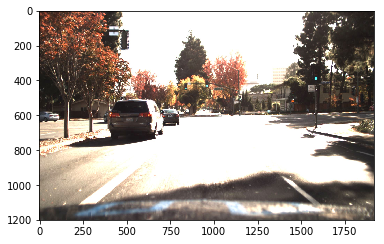

In [54]:
fileName = dataFile1['Frame'][550]
img = cv2.imread(fileName)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)            
plt.show()

1/1 [==============================] - 1s 515ms/step
{0.0, 1.0}
{0, 255}
(288, 960, 1)


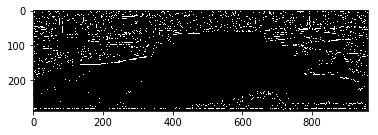

In [65]:
img = cv2.imread(fileName)
img = process_frame(img)
print(set(img.flatten()))
print(img.shape)
img = cv2.resize(img,(img.shape[1],img.shape[0]))
plt.imshow(img,cmap="gray")            
plt.show()